# Projet Calibration

### Théo MIDAVAINE & Matthieu JULIEN

### I – Densités risque neutre 

1/ Sur les prix d’option données dans le tableau ci-après, calibrer une densité risque neutre en utilisant 
la formule de Breeden-Litzenberger et la technique de Shimko. Comparer avec une densité gaussienne. 


In [1]:
import math
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random 
import math




In [2]:
data = pd.DataFrame()
data["strikes"] = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
data["prices"] = [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]
T=1 #On considère des calls 1 an
r = 0
S = 100
sigma = 0.2

In [3]:
data

strikes  prices
0       95   10.93
1       96    9.55
2       97    8.28
3       98    7.40
4       99    6.86
5      100    6.58
6      101    6.52
7      102    6.49
8      103    6.47
9      104    6.46

In [4]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


def newton_raphson_implied_vol(row, S, r, initial_guess=0.2, T=1):     
    sigma = initial_guess     
    K = row['strikes']
    price_market = row['prices']  
    for _ in range(100):           
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price_model = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  
        vega = S * np.sqrt(T) * norm.pdf(d1)  
        price_diff = price_market - price_model  
        
        if np.abs(price_diff) < 1e-8:               
            return sigma                  
        sigma += price_diff / vega  # Mise à jour de sigma
        
        if sigma < 0:               
            sigma = 0.001     
    return sigma

def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []
    for x in x_interpolated:
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

In [5]:
data["implied_vol"] = data.apply(lambda row: newton_raphson_implied_vol(row, S, r, T=T), axis=1)

In [6]:
data

strikes  prices  implied_vol
0       95   10.93     0.210948
1       96    9.55     0.189023
2       97    8.28     0.170031
3       98    7.40     0.160956
4       99    6.86     0.160079
5      100    6.58     0.165124
6      101    6.52     0.175031
7      102    6.49     0.185098
8      103    6.47     0.194908
9      104    6.46     0.204530

In [7]:
black_scholes_call_price(S, 95, T, r, 0.210948)

10.930002805693796

Interpolation des volatilités implicites

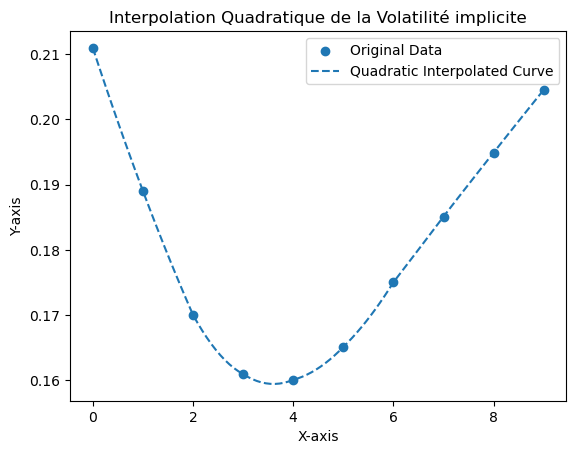

In [8]:
x_original = np.array(data.index)
y_original = np.array(data["implied_vol"])

nb_pts = 100
x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
vol_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, vol_interpolated, label='Quadratic Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Interpolation Quadratique de la Volatilité implicite')
plt.show()

Interpolation des strikes

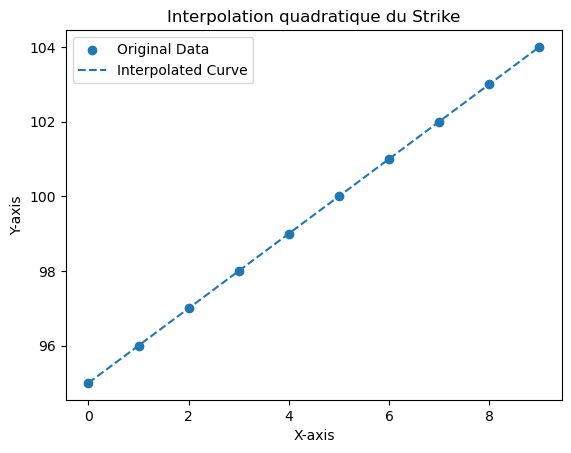

In [9]:
x_original=data.index
y_original=data["strikes"]
nb_pts=100
x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, strike_interpolated, label='Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Interpolation quadratique du Strike')
plt.show()

Calcul des prix avec Black-Scholes avec les vol et strike interpolés

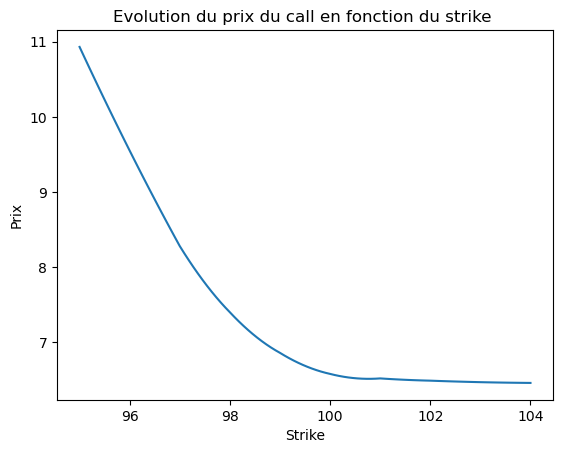

In [10]:
prices=[]

for i,j in zip(strike_interpolated,vol_interpolated):
    prices.append(black_scholes_call_price(S,i,T,r,j))

df=pd.DataFrame([prices,strike_interpolated],index=["Price","Strike"]).T
plt.plot(df["Strike"],df["Price"])
plt.title("Evolution du prix du call en fonction du strike ")
plt.ylabel("Prix")
plt.xlabel("Strike")
plt.show()

In [11]:
def neutral_risk_density(strikes , r , S , T , implied_vols ) :
    density = np.zeros(len(strikes))
    k=df["Strike"][1]-df["Strike"][0]
    
    for i , K in enumerate (strikes) :
        C_plus_k = black_scholes_call_price (S , K + k , T , r , implied_vols[i] ) 
        C_minus_k = black_scholes_call_price (S , K - k , T , r , implied_vols[i] ) 
        C_actuel = black_scholes_call_price (S , K , T , r , implied_vols[i] )

        # Formule de Breeden - Litzenberger 
        density [ i ] = np.exp( r * T ) *(( C_plus_k - 2 * C_actuel + C_minus_k ) / k ** 2)

    return density

density_risque_neutre = neutral_risk_density (strike_interpolated , r , S , T , vol_interpolated )

Afin de comparer nos deux densités, nous devons "fit" notre gaussienne 

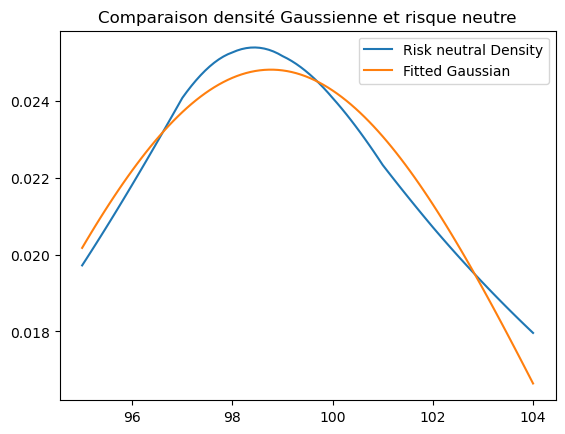

Fitted Mean: 98.7674639939289
Fitted Standard Deviation: 5.854576279872189
Fitted Amplitude (Ratio): 0.364191517778908


In [12]:
def gaussian(x, mu, sigma, ratio):
    return ratio * np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def objective(params, x, data):
    mu, sigma, ratio = params
    return np.sum((gaussian(x, mu, sigma, ratio) - data)**2)

initial_guess = [100, 5, 2]

result = minimize(objective, initial_guess, args=(df["Strike"], density_risque_neutre))

fitted_mu, fitted_sigma, fitted_ratio = result.x


plt.plot(df["Strike"], density_risque_neutre, label='Risk neutral Density')
plt.plot(df["Strike"], gaussian(df["Strike"], fitted_mu, fitted_sigma, fitted_ratio), label='Fitted Gaussian')
plt.title( "Comparaison densité Gaussienne et risque neutre")
plt.legend()
plt.show()

print("Fitted Mean:", fitted_mu)
print("Fitted Standard Deviation:", fitted_sigma)
print("Fitted Amplitude (Ratio):", fitted_ratio)

2/ Vérifier, en faisant des tirages dans cette loi implicite, si l’on trouve un prix de modèle proche du 
prix de marché pour toutes les options ci-dessus. 

In [13]:
# Simulation Monte Carlo pour valoriser une option
def valorisation_MC(S, K, T, r, pas, sigma,nb_simulations):
    dt=T/252
    paths = np.zeros((nb_simulations, pas + 1))   #on créé une matrice de taille nb_simulations x pas
    paths[:, 0] = S   #on remplit la première valeur de chaque ligne avec le spot
    
    for i in range(pas):
        paths[:, i + 1] = paths[:, i] *np.exp(dt*(r - 0.5*sigma**2) + sigma*np.sqrt(dt)* ((np.random.normal(fitted_mu,fitted_sigma,size=nb_simulations)-fitted_mu)/fitted_sigma))   #tirage dans notre loi implicite
        #pour chaque pas on calcule le prix future en utilisant le spot précédent
    option_payoffs = np.maximum(paths[:, -1] - K, 0)     #on prend ensuite le max entre notre dernier spot futur calculé - strike et 0
    option_value = np.exp(-r * T) * np.mean(option_payoffs)  # on calcule la moyenne des payoffs qu'on actualise
    
    return option_value

In [14]:
for strike,vol,market_price in zip(data["strikes"],data["implied_vol"],data["prices"]):
    option_price_mc = valorisation_MC(S, strike, T, r, 252, vol, 10000)
    print(f"Prix par simulation de Monte Carlo pour K = {strike}, Sigma = {vol:.2f} : {option_price_mc:.2f}")
    print(f"Market Price = {market_price:.2f}, Difference = {abs(option_price_mc-market_price):.2f}")

Prix par simulation de Monte Carlo pour K = 95, Sigma = 0.21 : 10.72
Market Price = 10.93, Difference = 0.21
Prix par simulation de Monte Carlo pour K = 96, Sigma = 0.19 : 9.57
Market Price = 9.55, Difference = 0.02
Prix par simulation de Monte Carlo pour K = 97, Sigma = 0.17 : 8.39
Market Price = 8.28, Difference = 0.11
Prix par simulation de Monte Carlo pour K = 98, Sigma = 0.16 : 7.57
Market Price = 7.40, Difference = 0.17
Prix par simulation de Monte Carlo pour K = 99, Sigma = 0.16 : 6.93
Market Price = 6.86, Difference = 0.07
Prix par simulation de Monte Carlo pour K = 100, Sigma = 0.17 : 6.52
Market Price = 6.58, Difference = 0.06
Prix par simulation de Monte Carlo pour K = 101, Sigma = 0.18 : 6.47
Market Price = 6.52, Difference = 0.05
Prix par simulation de Monte Carlo pour K = 102, Sigma = 0.19 : 6.43
Market Price = 6.49, Difference = 0.06
Prix par simulation de Monte Carlo pour K = 103, Sigma = 0.19 : 6.39
Market Price = 6.47, Difference = 0.08
Prix par simulation de Monte Ca

## II – Interpolation et volatilité locale

En plus du tableau donné précédemment, on va utiliser pour cette partie les prix d’options suivants 

On utilise la fonction d'interpolation quadratique, pour lisser la courbe

In [15]:
def interpolation(data,T):
    prices = []
    #interpolation of vol
    x_original = np.array(data.index)
    y_original = np.array(data["implied_vol"])
 
    nb_pts = 100
    x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
    y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
    #interpolation of strikes
    x_original=data.index
    y_original=data["strikes"]
    x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
    strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
    #Calcul des prix avec la formule de black scholes en fonction des paramêtres interpolés
    for i,j in zip(strike_interpolated,y_interpolated):
        prices.append(black_scholes_call_price(S,i,T,r,j))
   
    df=pd.DataFrame([prices,strike_interpolated,y_interpolated],index=["prices","strikes",'implied_vol']).T
    return df

In [16]:
data_12_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                'prices': [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]}
data_9_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices':[11.79 ,8.95 ,8.07 ,7.03 ,6.18 ,6.04 ,5.76 ,5.50 ,5.50 ,5.39]}
data_6_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                    'prices': [10.71 ,8.28 ,6.91 ,6.36 ,5.29 ,5.07 ,4.76 ,4.47 ,4.35 ,4.14]}
data_3_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices': [8.67, 7.14, 5.98, 4.93, 4.09, 3.99, 3.43, 3.01, 2.72, 2.53]}

df_12_months = pd.DataFrame(data_12_months)
df_9_months = pd.DataFrame(data_9_months)
df_6_months = pd.DataFrame(data_6_months)
df_3_months = pd.DataFrame(data_3_months)


# On utilise l'algorithme de Newton Raphson pour trouver les volatilités implicites

df_12_months["implied_vol"] = df_12_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 1), axis=1)
df_9_months["implied_vol"] = df_9_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 9/12), axis=1)
df_6_months["implied_vol"] = df_6_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 6/12), axis=1)
df_3_months["implied_vol"] = df_3_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 3/12), axis=1)


df_12_months = interpolation(df_12_months,1)
df_9_months = interpolation(df_9_months,0.75)
df_6_months = interpolation(df_6_months,0.5)
df_3_months = interpolation(df_3_months,0.25)

df_12_months['maturité'] =  [1]*100
df_9_months['maturité'] = [0.75]*100
df_6_months['maturité'] = [0.5]*100
df_3_months['maturité'] = [0.25]*100


df_concatenated = pd.concat([df_12_months,df_9_months, df_6_months, df_3_months])
df_concatenated.reset_index(drop=True,inplace=True)

3/ Déterminez la nappe de volatilité correspondant à ces 40 options. 

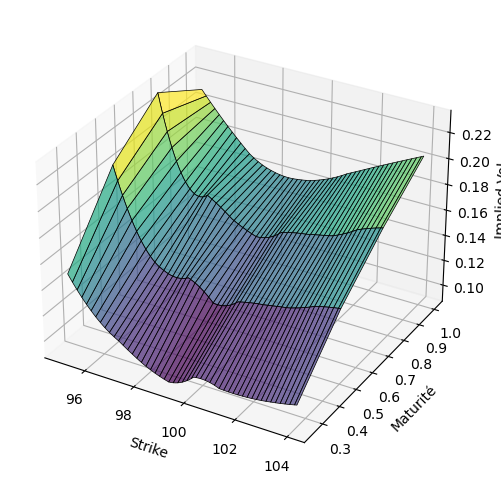

In [17]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Utilisation de plot_surface
ax.plot_surface(df_concatenated['strikes'].values.reshape(4, -1),
                df_concatenated['maturité'].values.reshape(4, -1),
                df_concatenated['implied_vol'].values.reshape(4, -1),
                cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)

# Configurations supplémentaires
ax.set_xlabel('Strike')
ax.set_ylabel('Maturité')
ax.set_zlabel('Implied Vol')

plt.show()

Proposer un prix, le plus juste 
possible, pour une option de strike 99.50 et de maturité 8 mois (justifier la méthode retenue). 

## changer le code pour pas être cramé

In [18]:
def bilinear_interpolation(x, y, points):
    
# Fvoir sur https ://fr.wikipedia.org/wiki/Interpolation_bilin%C3%A9aire
    points = sorted(points)
    (x1 , y1 , q11), (_x1 , y2, q12), (x2, _y1 , q21), (_x2 , _y2 , q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError("points do not form a rectangle")
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError("(x, y) not within the rectangle ")

    return (q11 * (x2 - x) * (y2 - y) +
    q21 * (x - x1) * (y2 - y) +
    q12 * (x2 - x) * (y - y1) +
    q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1) + 0.0)

On test l'interpolation bilinéaire avec une valeur que l'on connait pour estimer son erreur.<br>
Ici avec un Call K=99 T=1

In [19]:
x_val = 99
y_val = 1
z_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_9_months[df_9_months['strikes'] == 98]['implied_vol'].values)),
                                            (98,1,float(df_12_months[df_12_months['strikes'] == 98]['implied_vol'].values)),
                                        (100,0.75,float(df_9_months[df_9_months['strikes'] == 100]['implied_vol'].values)),
                                        (100,1,float(df_12_months[df_12_months['strikes'] == 100]['implied_vol'].values))])

In [20]:
t1 = black_scholes_call_price(100,99,1,0,float(df_12_months[df_12_months['strikes']==100]['implied_vol'].values))
print(f'Black Scholes Call price with implied vol from dataframe : {t1:.4f}')
t2 = black_scholes_call_price(100,99,1,0,z_val)
print(f'Black Scholes Call price with bilinear interpolated implied vol : {t2:.4f}')

Black Scholes Call price with implied vol from dataframe : 7.0592
Black Scholes Call price with bilinear interpolated implied vol : 6.9769


In [21]:
true_z_val = float(df_12_months[df_12_months['strikes']==100]['implied_vol'].values)
print(f'Implied vol from the dataframe : {true_z_val:.4f}')
print(f'Bilinear interpolated implied vol : {z_val:.4f}')
error = true_z_val - z_val
print(f'The error between bilinear interpolation and true value is : {error:.4f}')
 
prix_bi = black_scholes_call_price(100,99,1,0,z_val)
print(f"Prix trouvé avec l'interpolation bilinéeaire : {prix_bi:.4f}")
print(f"Prix théorique dans le dataframe: {float(df_concatenated[(df_concatenated['strikes'] == 100) & (df_concatenated['maturité'] == 1)]['prices'].values)}")

Implied vol from the dataframe : 0.1651
Bilinear interpolated implied vol : 0.1630
The error between bilinear interpolation and true value is : 0.0021
Prix trouvé avec l'interpolation bilinéeaire : 6.9769
Prix théorique dans le dataframe: 6.579999996457758


Les prix sont cohérents on l'utilisera donc pour calculer le call K=99.5 T=8/12

In [22]:
x_val = 99.5
y_val = 8/12
z_995_val = bilinear_interpolation(x_val,y_val,[(99,0.75,float(df_9_months[df_9_months['strikes'] == 98]['implied_vol'].values)),
                                        (99,0.5,float(df_6_months[df_6_months['strikes'] == 98]['implied_vol'].values)),
                                        (100,0.75,float(df_9_months[df_9_months['strikes'] == 100]['implied_vol'].values)),
                                        (100,0.5,float(df_6_months[df_6_months['strikes'] == 100]['implied_vol'].values))
                                        ]                 
                               )

La librairie interp2d est ici utilisée comme benchmark

In [23]:
from scipy.interpolate import interp2d
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
strike_prices = list(df_concatenated[df_concatenated['maturité']==1]['strikes'])
maturities = [0.5, 0.75]

implied_volatilities = [
    list(df_6_months['implied_vol'].values),
    list(df_9_months['implied_vol'].values)  
]

interp_func = interp2d(strike_prices, maturities, implied_volatilities, kind='linear')

x_target = 99.5
z_target = 8/12

implied_volatility_8_12 = interp_func(x_target, z_target)

print(f"Implied Volatility for maturity 8/12 and strike 99.5: {implied_volatility_8_12[0]:.4f}")

Implied Volatility for maturity 8/12 and strike 99.5: 0.1371


In [24]:
maturities_original = [0.25, 0.5, 0.75, 1]  # en mois
strikes_original = list(df_concatenated['strikes'])
implied_vol_original = list(df_concatenated['implied_vol'])
 
# Les valeurs à interpoler
maturity_interpolated = 8/12  # en mois
strike_interpolated = 99.50
 
# Appel de la fonction d'interpolation quadratique
x_interpolated = [maturity_interpolated]
x_original = maturities_original
y_original = implied_vol_original
 
y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
# Afficher le résultat
print(f"Le prix interpolé pour une option avec strike {strike_interpolated} et maturité {maturity_interpolated:.4f} année est : {y_interpolated[0]:.4f}")

Le prix interpolé pour une option avec strike 99.5 et maturité 0.6667 année est : 0.2074


In [25]:
print(f'Implied vol from interp2d : {implied_volatility_8_12[0]:.4f}')
print(f'Bilinear interpolated implied vol : {z_995_val:.4f}')
error = implied_volatility_8_12[0] - z_995_val
print(f'The error between bilinear interpolation and true value is : {error:.4f}')


prix_quad = black_scholes_call_price(100,99.5,8/12,0,y_interpolated[0])
print(f"Prix trouvé avec l'interpolation quadratique : {prix_quad:.4f}")
prix_bi = black_scholes_call_price(100,99.5,8/12,0,z_995_val)
print(f"Prix trouvé avec l'interpolation bilinéeaire : {prix_bi:.4f}")
prix_interp2d = black_scholes_call_price(100,99.5,8/12,0,implied_volatility_8_12[0])
print(f"Prix théorique dans le dataframe: {prix_interp2d:.4f}")

Implied vol from interp2d : 0.1371
Bilinear interpolated implied vol : 0.1446
The error between bilinear interpolation and true value is : -0.0075
Prix trouvé avec l'interpolation quadratique : 6.9850
Prix trouvé avec l'interpolation bilinéeaire : 4.9494
Prix théorique dans le dataframe: 4.7066


4/ Calibrer un modèle à volatilité locale de type SVI en suivant les étapes suivantes : 
- écrire l’algorithme de valorisation d’une option avec le modèle SVI(stochastic volatility inspired), par EDP d’une part et par 
Monte Carlo d’autre part et comparer les résultats pour plusieurs jeux de paramètres ; 


##### voir slide 69 la formule pour le modèle SVI

In [26]:
# Fonction SVI (slide 69 du cours)
def svi(param, x):
    a, b, rho, m, sigma = param
    return a + b * (rho * (x - m) + np.sqrt((x - m) ** 2 + sigma ** 2))

# Simulation Monte Carlo pour valoriser une option
def valorisation_MC(S, param,r, nb_simulations, pas, strike, maturity):
    dt=T/252
    paths = np.zeros((nb_simulations, pas + 1))
    paths[:, 0] = S   
    for i in range(pas):
        vol = svi(param, paths[:, i])   #A chaque pas on calcule notre volatilité avec le modèle SVI
        paths[:, i + 1] = paths[:, i] * np.exp((r-0.5 * vol **2) * dt + vol * np.sqrt(dt) * np.random.normal(0,1,size=nb_simulations))

    option_payoffs = np.maximum(paths[:, -1] - strike, 0)   
    option_value = np.exp(-r * maturity) * np.mean(option_payoffs)  #payoff actualisé

    return option_value

On teste la valorisation des options 12 mois et comparons à nos vraies valeurs de marché.
Pour le set de paramètres nous utilisons celui déterminé dans la suite du projet, qui minimise l'erreur moyenne.

In [27]:
# Paramètres du modèle SVI 
calibrated_params = [ 1.31037559e-01,  1.84852425e-02 ,-3.89813515e-01,  9.77848385e+01 ,1.65244084e+00]

# Valorisation de l'option par Monte Carlo
for strike,price in zip(data["strikes"],data["prices"]):
    option_value_mc = valorisation_MC(S, calibrated_params,r, 10000, 252, strike, 1)
    print(f"Prix par simulation de Monte Carlo pour K = {strike} : {option_value_mc:.2f}")
    print(f"Market Price = {price:.2f}, Difference = {abs(option_value_mc-price):.2f}")

Prix par simulation de Monte Carlo pour K = 95 : 9.77
Market Price = 10.93, Difference = 1.16
Prix par simulation de Monte Carlo pour K = 96 : 9.54
Market Price = 9.55, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 97 : 9.03
Market Price = 8.28, Difference = 0.75
Prix par simulation de Monte Carlo pour K = 98 : 8.39
Market Price = 7.40, Difference = 0.99
Prix par simulation de Monte Carlo pour K = 99 : 7.95
Market Price = 6.86, Difference = 1.09
Prix par simulation de Monte Carlo pour K = 100 : 7.43
Market Price = 6.58, Difference = 0.85
Prix par simulation de Monte Carlo pour K = 101 : 6.49
Market Price = 6.52, Difference = 0.03
Prix par simulation de Monte Carlo pour K = 102 : 6.45
Market Price = 6.49, Difference = 0.04
Prix par simulation de Monte Carlo pour K = 103 : 6.01
Market Price = 6.47, Difference = 0.46
Prix par simulation de Monte Carlo pour K = 104 : 6.13
Market Price = 6.46, Difference = 0.33


Notre algorithme de valorisation par Monte Carlo nous donne des prix proches

- estimez les cinq paramètres permettant de réduire au plus l’erreur moyenne ; 


In [28]:
def svi(param, x):
    a, b, rho, m, sigma = param
    return a + b * (rho * (x - m) + np.sqrt((x - m) ** 2 + sigma ** 2))

# Fonction de coût à minimiser
def cost_function(param, strikes, vols_market):
    vols_model = [svi(param, x) for x in strikes]
    return np.sum((vols_model - vols_market) ** 2)

# Données de marché
strikes_12m = df_12_months["strikes"]
vols_market_12m = df_12_months["implied_vol"]
strikes_9m = df_9_months["strikes"]
vols_market_9m = df_9_months["implied_vol"]
strikes_6m = df_6_months["strikes"]
vols_market_6m = df_6_months["implied_vol"]
strikes_3m = df_12_months["strikes"]
vols_market_3m = df_3_months["implied_vol"]

# Initialisation des paramètres
initial_params = [0.1, 0.1, -0.5, 100, 0.1]

# Minimisation de la fonction de coût
result_12m = minimize(cost_function, initial_params, args=(strikes_12m, vols_market_12m), method='L-BFGS-B') #optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory
result_9m = minimize(cost_function, initial_params, args=(strikes_9m, vols_market_9m), method='L-BFGS-B') #optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory
result_6m = minimize(cost_function, initial_params, args=(strikes_6m, vols_market_6m), method='L-BFGS-B') #optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory
result_3m = minimize(cost_function, initial_params, args=(strikes_3m, vols_market_3m), method='L-BFGS-B') #optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory

# Paramètres calibrés
calibrated_params_12m = result_12m.x
calibrated_params_9m = result_9m.x
calibrated_params_6m = result_6m.x
calibrated_params_3m = result_3m.x

# Affichage des résultats
print("Paramètres calibrés 12m:", calibrated_params_12m)
print("Paramètres calibrés 9m:", calibrated_params_9m)
print("Paramètres calibrés 6m:", calibrated_params_6m)
print("Paramètres calibrés 3m:", calibrated_params_3m)

Paramètres calibrés 12m: [ 1.50915432e-01  1.33252989e-02 -3.28606287e-01  9.81899908e+01
  3.49539451e-01]
Paramètres calibrés 9m: [ 1.85838966e-02  9.22258500e-01 -9.87432925e-01  9.32027814e+01
  8.88190244e-01]
Paramètres calibrés 6m: [ 2.44778313e-02  3.24054906e-01 -9.71729439e-01  9.35904296e+01
  1.32014956e+00]
Paramètres calibrés 3m: [ 9.11947925e-02  1.00407466e-02 -8.16805967e-01  9.79483089e+01
  4.75968204e-01]


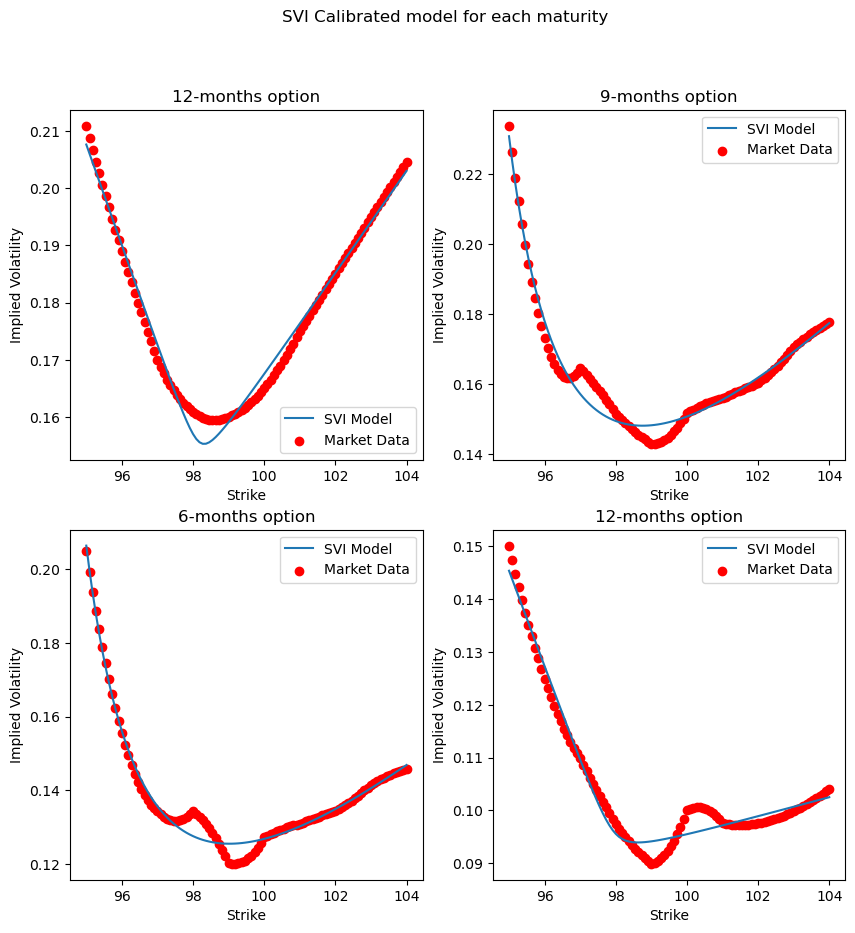

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle('SVI Calibrated model for each maturity')

# Visualisation de la surface de volatilité implicite
strikes_plot = np.linspace(min(strikes_12m), max(strikes_12m), 100)
vols_plot = [svi(calibrated_params_12m, x) for x in strikes_plot]

ax1.plot(strikes_plot, vols_plot, label='SVI Model')
ax1.scatter(strikes_12m, vols_market_12m, color='red', label='Market Data')
ax1.set_xlabel('Strike')
ax1.set_ylabel('Implied Volatility')
ax1.set_title("12-months option")
ax1.legend()

strikes_plot = np.linspace(min(strikes_9m), max(strikes_9m), 100)
vols_plot = [svi(calibrated_params_9m, x) for x in strikes_plot]

ax2.plot(strikes_plot, vols_plot, label='SVI Model')
ax2.scatter(strikes_9m, vols_market_9m, color='red', label='Market Data')
ax2.set_xlabel('Strike')
ax2.set_ylabel('Implied Volatility')
ax2.set_title("9-months option")
ax2.legend()

strikes_plot = np.linspace(min(strikes_6m), max(strikes_6m), 100)
vols_plot = [svi(calibrated_params_6m, x) for x in strikes_plot]

ax3.plot(strikes_plot, vols_plot, label='SVI Model')
ax3.scatter(strikes_6m, vols_market_6m, color='red', label='Market Data')
ax3.set_xlabel('Strike')
ax3.set_ylabel('Implied Volatility')
ax3.set_title("6-months option")
ax3.legend()

strikes_plot = np.linspace(min(strikes_3m), max(strikes_3m), 100)
vols_plot = [svi(calibrated_params_3m, x) for x in strikes_plot]

ax4.plot(strikes_plot, vols_plot, label='SVI Model')
ax4.scatter(strikes_3m, vols_market_3m, color='red', label='Market Data')
ax4.set_xlabel('Strike')
ax4.set_ylabel('Implied Volatility')
ax4.set_title("12-months option")
ax4.legend()

plt.show()


- on fixe tous les paramètres aux valeurs estimées ci-avant (sauf a et b) et on va calibrer les deux 
paramètres a et b pour chaque option : vous obtiendrez donc une nappe pour chacun de ces 
deux paramètres et vous introduirez une contrainte de régularisation de ces deux nappes dans 
votre problème d’optimisation. 

In [30]:
calibrated_params_concat = [calibrated_params_12m]+[calibrated_params_9m]+[calibrated_params_6m]+[calibrated_params_3m]

In [31]:
def svi_fixed(param, calibrated_params, x):
    a, b = param
    rho, m, sigma = calibrated_params[2:5]
    return a + b * (rho * (x - m) + np.sqrt((x - m) ** 2 + sigma ** 2))
 
# Liste des options et des prix du marché
strikes = df_concatenated["strikes"]
maturity = df_concatenated['maturité']
market_prices = df_concatenated["prices"]
vol_market= df_concatenated["implied_vol"]
 
# Fonction d'erreur pour l'optimisation
def cost_function(param, calibrated_params, strike, vol_market):
    vols_model = svi_fixed(param, calibrated_params, strike)
    return (vols_model - vol_market) ** 2

# Estimation des paramètres a et b pour chaque option
a_values = []
b_values = []
i = 0
for k, sigma in zip(strikes, vol_market):
    if k == 104.0 and i < 3:
        i += 1
    res = minimize(cost_function, [0.1, 0.1], args=(calibrated_params_concat[i], k, sigma))
    a, b = res.x
    a_values.append(a)
    b_values.append(b)

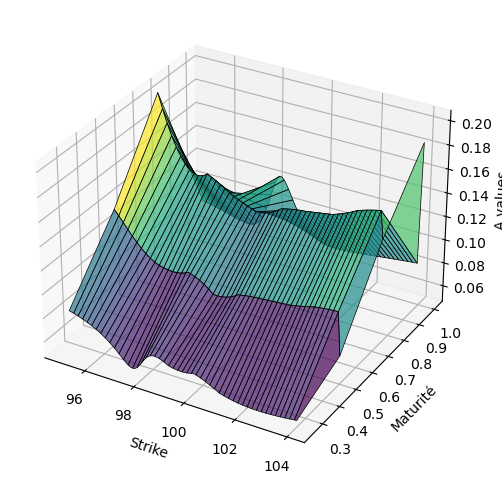

In [32]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Utilisation de plot_surface pour créer une surface 3D
ax.plot_surface(np.array(strikes).reshape(4,-1), 
                np.array(maturity).reshape(4,-1),
                np.array(a_values).reshape(4,-1), 
                cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)

# Configurations supplémentaires
ax.set_xlabel('Strike')
ax.set_ylabel('Maturité')
ax.set_zlabel('A values')

# Affichage de la figure
plt.show()

A voir si on utilise les valeurs interpolées

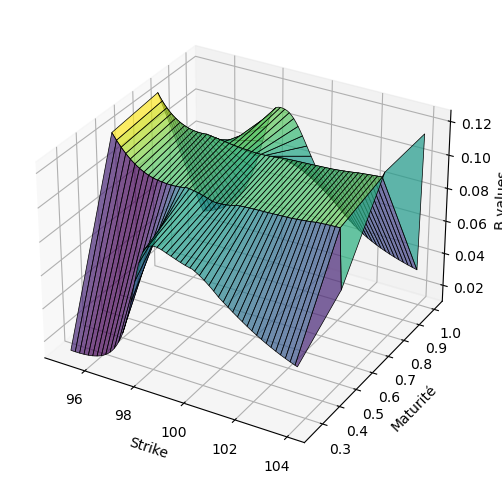

In [33]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(np.array(strikes).reshape(4,-1), 
                np.array(maturity).reshape(4,-1),
                np.array(b_values).reshape(4,-1), 
                cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)
# Configurations supplémentaires
ax.set_xlabel('Strike')
ax.set_ylabel('Maturité')
ax.set_zlabel('B values')

# Affichage de la figure
plt.show()

5/ En utilisant les nappes obtenues pour le modèle SVI (à la dernière étape), proposer encore un prix, 
le plus juste possible, pour une option de strike 99.50 et de maturité 8 mois (justifier la méthode 
retenue). 

In [34]:
df_concatenated['a_values'] = a_values
df_concatenated['b_values'] = b_values

Brouillon explication : 

interpolation de a values pour 99.5/8M interpolation de b values pour 99.5/8M

imp vol svi = svi (param [a_inter,b_inter,calibrated param])

BS(K,t,imp vol svi)


TEST DU MODEL DE BILINEARITE

In [35]:
x_val = 99
y_val = 1
z_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 98)]['a_values'].values)),
                                            (98,1,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 98)]['a_values'].values)),
                                        (99,0.75,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                        (99,1,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 99)]['a_values'].values))
                                        ]                 
                               )
z2_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 98)]['b_values'].values)),
                                            (98,1,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 98)]['b_values'].values)),
                                        (99,0.75,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                        (99,1,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 99)]['b_values'].values))
                                        ]                 
                               )

On teste l'interpolation pour les a et b values du modèle svi, avec des données que l'on connait déjà pour voir si le modèle nous sort des prix cohérents 

In [36]:
test_imp = svi([z_val,z2_val,calibrated_params_concat[0][2],calibrated_params_concat[0][3],calibrated_params_concat[0][4]],99)
price = black_scholes_call_price(100,99,1,0,test_imp)
price

6.860000099009902

Vrai prix

In [37]:
float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 99)]['prices'].values)

6.859999997306801

Voir diff entre true value et model value

In [38]:
x_val = 99.5
y_val = 8/12
a_val = bilinear_interpolation(x_val,y_val,[(99,0.5,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                            (99,0.75,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                        (100,0.5,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 100)]['a_values'].values)),
                                        (100,0.75,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 100)]['a_values'].values))
                                        ]                 
                               )
b_val = bilinear_interpolation(x_val,y_val,[(99,0.5,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                            (99,0.75,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                        (100,0.5,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 100)]['b_values'].values)),
                                        (100,0.75,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 100)]['b_values'].values))
                                        ]                 
                               )

In [39]:
calibrated_params_concat

[array([ 1.50915432e-01,  1.33252989e-02, -3.28606287e-01,  9.81899908e+01,
         3.49539451e-01]),
 array([ 1.85838966e-02,  9.22258500e-01, -9.87432925e-01,  9.32027814e+01,
         8.88190244e-01]),
 array([ 2.44778313e-02,  3.24054906e-01, -9.71729439e-01,  9.35904296e+01,
         1.32014956e+00]),
 array([ 9.11947925e-02,  1.00407466e-02, -8.16805967e-01,  9.79483089e+01,
         4.75968204e-01])]

In [40]:
def linear_interpolation(x0, y0, x1, y1, x):
    slope = (y1 - y0) / (x1 - x0)
    y = y0 + slope * (x - x0)
    return y

In [41]:
rho_8m = linear_interpolation(6,calibrated_params_concat[2][2],9,calibrated_params_concat[1][2],8)
m_8m = linear_interpolation(6,calibrated_params_concat[2][3],9,calibrated_params_concat[1][3],8)
sigma_8m = linear_interpolation(6,calibrated_params_concat[2][4],9,calibrated_params_concat[1][4],8)

voir si on douille le prof avec les paramètres du 3 mois plutot que le 9 mois

In [42]:
imp_vol_svi_8 = svi_fixed([a_val,b_val],calibrated_params_concat[3],99.5) #Calibrated param for 6 months

In [43]:
imp_vol_svi_8_inter = svi_fixed([a_val,b_val],[0,0,rho_8m,m_8m,sigma_8m],99.5) #Calibrated param for 6 months

In [44]:
price_svi = black_scholes_call_price(100,99.5,8/12,0,imp_vol_svi_8)
print(f"Prix trouvé avec l'interpolation bilinéaire et param pour 9 mois : {price_svi:.4f}")
price_svi_inter = black_scholes_call_price(100,99.5,8/12,0,imp_vol_svi_8_inter)
print(f"Prix trouvé avec l'interpolation bilinéaire de a et b et autres params interpolés pour 8 mois : {price_svi_inter:.4f}")
prix_interp2d = black_scholes_call_price(100,99.5,8/12,0,implied_volatility_8_12[0])
print(f"Prix théorique dans le calculé par interp2d: {prix_interp2d:.4f}")

Prix trouvé avec l'interpolation bilinéaire et param pour 9 mois : 4.6455
Prix trouvé avec l'interpolation bilinéaire de a et b et autres params interpolés pour 8 mois : 4.1704
Prix théorique dans le calculé par interp2d: 4.7066


Justifier notre méthode choisie

6/ écrire l’algorithme de valorisation d’une option avec le modèle PDV, par Monte Carlo (les seuls 
rendements considérés seront ceux simulés entre la date courante et la maturité) ; 



In [124]:
# Parameters for the PDV model
lambda_1 = 0.5  
lambda_2 = 0.3 
beta_0 = 0.1   
beta_1 = 0.2  
beta_2 = 0.3    

In [125]:
def K_1(t,param):
    return param[3] * np.exp(-param[3] * t)

def K_2(t,param):
    return param[4] * np.exp(-param[4] * t)

def PDV_model(i,param,x):  
    sum_K1_rt = K_1(i,param)
    sum_K2_rt_sq = K_1(i,param)
    sigma = param[0] + param[1] * sum_K1_rt + param[2] * np.sqrt(sum_K2_rt_sq)
    return sigma

In [165]:
def K_1(t,param):
    return param[3] * np.exp(-param[3] * t)

def K_2(t,param):
    return param[3] * np.exp(-param[4] * t)  #according to formula given in paper

def PDV_model(param,x,pas):  
    sum_K1_rt = sum(sum([K_1(T-t/pas,param)*((x[:,1]/x[:,0])-1) for t in range(pas)]))
    print(sum_K1_rt)
    sum_K2_rt_sq = sum(sum([K_2(T-i/pas,param)*(((x[:,1]/x[:,0])-1)**2) for t in range(pas)]))
    sigma = param[0] + param[1] * sum_K1_rt + param[2] * np.sqrt(sum_K2_rt_sq)
    return sigma



In [209]:
def K1(t,param):
    return param[3] * np.exp(-param[3] * t)

def K2(t,param):
    return param[3] * np.exp(-param[4] * t)

def R(x):
    return (x[:,1]/x[:,0])-1

def PDV_model2(param,x,t):  
    rt = R(x)
    sigma  = beta_0 + beta_1*(sum(([K1(T-i/t,param)*rt for i in range(t)]))) + beta_2*(np.sqrt(sum([K2(T-i/t,param)*(rt**2) for i in range(t)])))
    print(sigma)
    return sigma

In [210]:
def valorisation_MC_PDV(S, param,r, nb_simulations, pas, strike, T):
    dt=T/pas

    paths = np.zeros((nb_simulations, pas + 1))
    paths[:, 0:2] = S 
        
    for i in range(1,pas):
        vol = PDV_model2(param,paths[:, i-1:i+1],pas)  #A chaque pas on calcule notre volatilité avec le modèle PDV
        paths[:, i + 1] = paths[:, i] * np.exp((r-0.5 * vol **2) * dt + vol * np.sqrt(dt) * np.random.normal(0,1,size=nb_simulations))
    option_payoffs = np.maximum(paths[:, -1] - strike, 0)   
    option_value = np.exp(-r * T) * np.mean(option_payoffs)  #payoff actualisé

    return option_value

On valorise nos options 1 an et les comparons à notre prix de marché

In [211]:
param = [beta_0, beta_1, beta_2, lambda_1, lambda_2]
nb_simulations = 100
maturity=1
pas=252

for strike,price in zip(data["strikes"],data["prices"]):
    option_price = valorisation_MC_PDV(S, param,r, nb_simulations, pas, strike, maturity)
    print(f"Prix par simulation de Monte Carlo pour K = {strike} : {option_price:.2f}")
    print(f"Market Price = {price:.2f}, Difference = {abs(option_price-price):.2f}")


[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[-0.05134776 -0.09452809  0.19528133  0.12567062 -0.01538384  0.33423447
  0.17255641 -0.01773331  0.18468544  0.19023808  0.12566426  0.11506238
  0.22188292  0.05182376  0.04834041  0.09582049  0.25913397  0.44319439
  0.14468892 -0.02004277  0.04742207  0.10617673  0.21519717  0.34146358
  0.13924719  0.24613614  0.19083713  0.24866008 -0.06537282 -0.01816501
  0.06827864  0.09159148  0.37265653  0.25729512  0.03995968  0.00841657
  0.11413672  0.08340847  0.09463322 -0.08509032  0.12605714  0.19154347
  0.33027516  0.35581794  0.26557293  0.25956515  0.08069653 -0.04702608
  0.20667

[ 6.02466710e-01  3.62959251e-02  5.18960125e-01 -1.47858507e-01
  2.06881895e+00  1.84959840e-01 -2.27260029e-01 -6.64182788e-02
  1.97480617e-01  1.08449734e-01  1.17991655e-01  3.27913619e-01
  8.65940387e-01  2.52544922e+00  1.60923694e-01 -2.51367577e-01
  7.62901883e-02  3.98798609e-01 -4.77323865e-02  1.43795989e-01
  8.53378465e-01 -5.12086152e-03 -3.47064836e-01  1.13891143e-01
  5.04296108e-02  1.12194800e-01  2.59037540e-01  1.00094121e-01
 -2.54860726e-01  4.12536326e-01  8.35636598e-02  4.23434266e-01
  3.71575173e-01  9.32933126e-02  1.35233059e-01  3.82707050e+00
  3.17078364e-01  1.07673062e-01  4.63329848e-01  2.97264431e-01
  6.74484160e-02  9.96963168e+00  9.83385495e-02  1.17870536e-01
  1.73099794e-02  8.38019610e-02  7.43126769e-02  5.13008968e-01
 -1.75968664e-01  5.73436330e-01  2.53476818e-01  9.45128722e-02
  4.42287107e-01  9.63286661e-02  2.78869923e-01  1.25637461e-01
  1.90970783e+00 -1.13189599e+00 -4.26537995e-01  4.85928934e-01
  2.17466568e-01  1.15526

[ 2.51037898e-01  1.76909297e-01  1.61105890e-01  4.12817568e+00
 -9.82586895e-02  3.03732804e-01  1.02080800e-01 -1.49276807e-01
  3.27976265e-01  2.39154908e-01  3.11340551e-01  1.53973084e-01
  2.83394282e-01 -1.15581421e+00  1.06348908e-01  2.50028230e-01
 -3.51257013e-01 -2.99801790e-02  1.72326665e-01 -5.57084427e-03
  1.21380679e-01  2.03343453e+00 -6.93803291e-01  1.47414337e-01
  7.33632583e-01  2.13688334e+00 -3.53114255e-02  1.71411835e-01
 -2.13744760e-01  1.95410641e-01  9.58263565e-02  7.50227431e-02
  3.03442842e-01  3.03614956e-01 -3.39969944e-01  2.37005399e-01
  1.66861583e-01  3.51888361e-01  6.65711863e-01  1.45925566e-01
  4.20282451e+00  7.05443913e-02  1.35316414e-01  8.88351708e-02
 -6.76986127e-01  7.26752590e-01  7.24637847e-02  1.23443594e-01
  1.39139418e-02 -1.22167825e-01  3.92046609e-02 -6.20064851e-02
  1.13616425e-01  1.00734259e-01  9.13895652e-02  1.17350078e-01
  1.03653358e-01  3.46094783e-02 -2.30423089e-04  3.47073715e-01
  1.21402980e-02  9.63335

[ 2.07112532e-01 -1.24399426e+01  2.58061189e-01  8.66814635e-02
  3.19464687e-01  2.41237431e+00 -1.05134029e-01  3.89445537e-01
 -8.75953803e-02  3.20942558e-01 -1.13860588e-01  1.08425002e-02
  1.27286277e-01  5.79774486e-01  1.59001745e-01 -2.67758113e-01
 -3.58176890e-02 -4.22682937e-01  2.45819741e-01  1.96306747e-01
 -8.57273545e-01  1.37459398e-01  1.27069589e-01  9.02558198e-02
 -2.81555519e-01  1.94384774e-01  3.06100923e-01  7.02852544e-02
  2.69429925e-01  1.06265609e-01  1.25293746e-01  1.48273385e+00
  1.20260399e-01 -1.10369801e-01  6.47731793e-01  9.08057860e-01
  6.24024420e-01  1.83060880e-01  4.07443405e-01  2.76881552e-01
  1.84266831e-01  1.08474904e-01  1.57617509e-01  5.41253300e-02
  1.99363836e-01 -6.03969258e-02  7.85246223e-01 -5.10577835e-01
 -3.41836965e-01  1.70628892e-01  6.34924124e-02  1.97306987e-01
  6.93704398e-01  6.76486482e-02  1.45189611e-01  5.11980163e-01
 -5.23421908e-01  1.35835520e-01  1.54139184e-01  2.56924618e-02
  9.95451035e-02  9.71438

[ 7.98740287e-01  3.42755085e-01  2.40979811e-01 -4.74400478e+00
  1.30738877e-01  3.28025461e-01 -8.16240683e-01  1.09913583e-01
  1.52110454e-01  1.15779538e-01  5.20221224e-01  1.67117818e-01
  1.96615606e-01  3.62030946e-01 -7.39015855e-02  1.04865778e-01
 -6.94278753e-03  4.06205225e-02 -1.01460928e+01 -4.38509019e-01
  5.86559533e-02 -2.30829609e-01  8.44777887e-02 -2.95974370e+00
 -2.59554349e-01  9.10023157e-02  6.43624090e-01  9.48226721e-02
 -1.41542518e+00  4.29172439e-01  4.75803460e-02  2.38830794e-01
  1.52343952e-01  1.17275538e-01 -7.40572202e-01 -2.52694975e+00
 -1.05673329e+00  9.74635300e-02 -1.94123785e-01 -1.03862737e-01
  8.86851221e-03  3.15069617e-01 -6.36670543e-02 -3.81049361e-01
  1.77534733e-01  4.84125004e-02 -1.12405626e-02  3.16825707e-01
 -7.33476104e-01  1.15881387e-01  9.58153710e-01  4.01210115e-02
  1.69976167e-01 -6.23404084e-02  3.59969564e+00  5.12208582e+00
  9.67036843e-02 -1.90847496e-01 -2.28535054e+00  5.31417766e-01
  2.19018547e-01 -4.84910

[ 1.27192115e-01 -1.81766297e-02  3.16500297e-01  9.54852100e-01
  3.53648648e-02  2.14734520e+00  1.27935412e-02  2.85092258e-01
 -7.04258209e-02  5.72022624e-02  1.17907243e-01  1.15442291e+00
  1.19398309e-01 -6.33809888e-01  3.15329380e-01  1.62418374e-01
  2.11022145e-01  8.14205287e-02  5.68835409e-01  3.78170115e-01
  7.42724215e-02  3.81181013e-01  1.60487781e-01 -5.20898079e-01
  1.69274174e-01  6.46150848e-01  1.10053564e-01 -1.60314577e-01
  9.19650059e-02 -8.96677404e-01  7.10180893e-02  3.53818182e-01
  3.97935965e-02  1.05854589e+00  2.75002771e-01 -1.51992281e-01
  9.46807912e-02  9.71311818e-02 -1.74673527e-01  1.06151367e-01
 -2.31291496e-02 -2.43466262e+00  1.44380362e-01  4.04343222e-02
  2.18761966e-01  3.58008291e-01 -2.90279513e-03  2.16104273e-01
  7.91521764e+00  1.61181771e-01  3.07621505e-01  6.96379311e-01
  4.10753218e-02  5.59007003e-01  7.69894801e-01  8.72236791e-02
  6.82117671e-01  1.19671734e-01  1.83465185e-01 -5.04803235e-02
 -6.84754626e-01  2.76023

[ 6.77097370e-02 -1.56212651e-01  4.34387747e-01  2.62830032e-01
  8.82789038e-02  3.34048670e-01 -4.03847671e-01  2.86551632e-01
 -2.06844910e-01 -6.16502631e-03  2.59006809e-01 -4.23344648e-02
  1.90231814e-01  1.71537182e-03 -3.31555770e-02 -9.36806274e-02
 -2.99976642e-01 -4.19170494e-01 -3.32475692e+00  1.01638078e-01
  1.48443656e-01  1.15660593e-01 -1.87348833e-01  1.69588753e-01
  6.84150540e-02 -9.21522305e-01  1.45037593e-01 -3.82063332e-01
  6.07528054e+00 -6.16672767e-02  4.39186489e-02  1.43044153e+00
  7.07926903e-02  6.65298613e-01  6.03139905e-01 -4.92182458e-01
 -3.10640506e-01  2.04235493e-01  3.93317117e-02  9.82581585e-01
  1.77176177e-01  5.03926894e-03  8.93058159e-02  6.97718903e-01
  1.85644811e-01 -3.23998467e-01  8.13832354e-02  1.05437232e-01
 -2.46548243e-02 -7.00615496e-02 -2.01143676e-02  7.94353587e-02
  5.04054097e-01  2.71347025e-01  3.18115844e-01  4.52095515e-02
  1.38594413e-01  3.39970803e-01  9.11864219e-02 -1.36014738e-01
  9.71307413e-02  6.31386

[ 1.07333714e-01  2.04229759e-01  4.31283139e-02  1.75035496e-01
  1.19582645e-01  1.11610382e-01  3.69747059e-01  2.10655326e-01
  3.33161005e-01  7.98500692e-02 -7.82357738e-03  5.99506502e-02
  1.12990975e-01  1.04189068e-01  6.84824970e-02  1.10382509e-01
  3.27990631e-01 -3.27436708e-02 -2.04995786e-02  2.17473702e-01
 -7.81915556e-01 -4.99466131e-01  7.06813045e-02  2.51833795e-01
  5.05407769e-02  7.44114058e-02  8.39023490e-02 -1.56234196e-02
 -8.74487726e-03  9.08327830e-02  8.40470073e-02  3.08442886e-01
  2.97000944e-02  1.38449147e-01  2.97848070e-01  1.05781501e-01
  2.56382759e-01  5.65557491e-02 -1.89703197e-01  2.27856222e-01
  2.58431700e-01  8.50774612e-02  1.19834495e-01  1.07834948e-01
  4.59480536e-03  4.05162376e-01 -3.31690270e-01  9.52120885e-02
  1.12323400e-01 -9.01181543e-02  9.61667365e-02  9.27376740e-01
 -1.73724617e+00  2.22355338e-01 -1.07591903e-01  2.95552424e-01
  1.19648251e-01 -2.37347741e+00 -6.32732545e-01  1.99267239e-01
 -5.50302563e-01  1.54473

[ 2.22364439e-01 -4.07313809e-01 -1.13834970e-01  3.08723619e-01
  7.08244938e-02  1.04011777e-01  4.55316444e-02  8.73903870e-02
  1.55920597e-01 -2.57931007e-03  7.63318962e-01  2.14462375e-01
  1.25816415e+00  1.10951705e-01  3.75615047e-01 -9.22185223e-02
 -1.45854939e+00  2.44207469e-01  1.53997670e-01  3.14977565e-01
  9.89618042e-02 -6.93560242e-01  1.09557716e-01  1.65871130e-01
  5.87470353e-02 -9.73277913e-01  7.96963420e-02  1.74236497e-01
  1.60496035e-01  5.30219193e+00  7.79147893e-02 -6.63019761e-01
  2.79771975e+01  2.62227885e-01  5.74451112e+00  4.98968617e-01
  1.68270397e-01  1.09520832e+00 -3.23664870e-01  6.45126813e-02
  9.18979230e-01  9.86233668e-02  1.07896810e-01  1.72579104e-01
 -5.31838872e-03 -6.92284423e-01  2.27342295e-01  8.78367622e-02
  6.67202871e-01  1.46026654e-01  2.27058771e-01  2.10234629e-01
  7.42111717e-02  1.51556828e-01  9.26933563e-02  6.32800757e-02
  3.06853860e-02  1.91965989e+00  2.23883854e-01 -4.13881069e-02
  1.30068001e-01 -1.00227

[ 8.33409558e-02 -2.36240179e-01  2.29020109e+00  1.31936707e-01
  7.43940610e-02 -6.74119801e-02  1.14846528e-01  2.07746741e-01
 -2.09818312e+00 -3.36754352e-02 -6.97961820e-01  3.11897487e+00
  4.37036226e-02  1.80234631e+00  8.16891131e-02  3.12971122e-01
  1.57696673e-01  3.02801604e-01  3.42825893e-01  2.12252353e+00
  1.20496749e-01  2.93682535e-01  2.30596933e-02  7.75954670e-02
  4.19343647e-01  8.38471661e-02  3.59308192e-01  3.76360946e-01
  1.59493748e-01 -2.34239314e-01  2.22550806e-02  3.10495873e-01
  8.26785539e-02 -3.95145198e-01  1.33420770e+00  9.64092478e-02
  5.43784445e-02  1.67375087e-01  1.45026348e+00 -9.00962751e-03
  1.21442519e+00 -1.94818422e-01  1.15961627e-01  3.81914542e-02
  2.69440415e-02  5.77920278e-01  4.17339521e-01  2.89396869e-01
  1.18491729e-01  7.41058313e-02 -2.76875841e-01 -5.27001230e-02
  9.16994511e-02 -1.00360641e+00 -7.60187683e-01  3.94284678e-01
  9.66360287e-02  2.28075219e-01  7.13053711e-02  7.69610387e-01
  2.47138636e-01  2.64830

[ 1.63444100e+00 -4.72545055e-02  3.67959553e-01  6.71901047e-02
  1.15047506e-01  2.22306567e-01  1.54537317e-02 -1.97642429e-02
  1.50077995e-01  2.40150589e-01  7.52198359e-02 -2.68724023e-01
  2.41713147e-01  4.36168183e-01  2.56868709e-01 -1.44131146e-01
  9.86564321e+00  3.50171424e-01 -2.82309049e-01 -1.34244174e-02
  1.00546097e-01  7.12181985e-01  1.25172855e-01  1.15973997e-01
  3.35904844e+00  8.71950724e-02  8.09116157e-02  1.70960568e-01
  2.75139006e-02  1.99678556e-01  4.35737019e-02  2.17431576e-01
 -3.01053648e-01  6.28101810e-01  3.84901728e-02  1.07219153e-01
  1.73451299e-01 -8.52994019e-02  1.45764495e-01  2.77001869e-01
  4.21176458e-01  9.30916637e-02  7.60724576e-01  2.21414458e-01
 -4.07843957e-01 -3.32135523e+00 -1.65363381e+01 -2.12841077e+00
 -2.84722820e-02  4.38837452e-01  3.00479752e-01  3.32660694e-02
  5.56701253e-02  6.36360907e-02  1.96796486e-02 -3.87483995e-01
  1.72246180e+00 -8.66210943e-01 -1.05832499e+00 -2.92524708e-02
  4.73649358e-01  4.35393

[ 4.76601951e-01 -2.45071746e-01 -3.54239551e-01  9.63163899e-01
  1.58085286e-01  2.73406129e-01 -1.22712738e-01  2.67340888e-01
 -9.47741881e-02  3.52876370e-01  5.42275309e-01  9.56048539e-02
  3.13407807e-01  1.29743669e+00  5.01597043e-01  2.52571675e-01
  1.46197654e-01 -3.69285070e-01  8.08489256e-01 -4.98950015e-03
  2.24313275e-01  2.47916002e-01  1.21601414e-01  2.38182474e-02
 -8.94464038e+00 -1.12604621e-01 -5.26130780e-01  2.04348197e-01
 -4.22056220e-02  9.44967145e-01  2.05968500e-01  5.33262530e-02
 -4.71984210e-02 -8.42236388e-02  5.73600538e-02  4.19663051e-01
 -5.86040019e-01  1.01121767e-01  2.46305202e-01  3.61250501e-01
  9.06897511e-01  1.60395614e-01 -1.48855860e-01  5.70592936e-01
  2.56033358e-01  2.55764015e-01  1.92198964e+00  1.17093664e-01
  1.21973353e-01  1.74068412e-01  8.07644743e-02 -3.11730070e-01
  2.02173081e-01  1.40182625e-01  1.43753884e+00  2.36442062e-01
  7.72307606e-02  1.22036515e-01 -2.22794621e-01  1.20670480e+00
 -1.74984218e+00  2.43629

[ 1.15592931e-01 -9.12221021e-02  7.85682014e-02  2.59108074e-02
  7.83172521e-02  1.09944016e-01 -6.52123958e-02  1.97197793e-01
 -3.00716639e-01  8.68366329e-01  3.47181341e-02 -1.85287819e-02
  2.37276614e-02  2.48874640e-01  3.64799233e-01  9.87016325e-02
  3.00365261e-01  1.62667354e-01  9.73103612e-02  3.94879617e-02
  2.13091142e-02  5.01457261e-01  6.44855511e-01 -3.62249284e-01
  1.47608848e-01  2.66204570e+00  3.25399609e-01  1.07722562e-01
  1.93646226e-01  4.31571904e-01  9.69243503e-02  3.75390825e-02
  9.44768795e-02 -3.45063706e-01  7.01329888e-02  2.39597851e-01
 -2.66376758e-02  6.73325836e+00 -2.73688384e-01  1.13588025e-01
 -1.34642179e-01  3.43491801e-01  9.28251902e-02  7.05045366e-02
  3.84741717e-01  2.25956469e-01  1.62451522e-01  2.75721218e-03
  1.75800829e-01  6.24232997e-01  6.73484413e-02 -2.42580187e+00
  1.71917404e-01 -6.42751811e-01  8.58937459e-02  8.67305010e-01
  1.98518975e-02  7.29310174e-01  5.18186933e-01  5.59789908e-02
  6.20517372e-01  7.89043

[ 2.44504700e-01  4.07776679e-02 -6.58883400e-03  3.64738993e+00
  1.60957373e+00 -1.95303684e-02 -4.76331786e-01  7.39055350e-02
  8.65653917e-03 -6.94775781e-02  3.97579011e-02 -9.05115167e-01
 -6.75050889e-01 -6.81177116e-02  2.34489463e-01  3.41895744e-01
  6.16590720e-01  2.45725561e-01  1.98190443e+00 -2.39652339e-02
  3.23994679e+00  7.16984449e-02  1.17235304e-01  1.40641857e-01
  3.44814610e-01  2.74088710e-01  1.00198351e-01  1.44569627e-01
  4.49381381e-02  1.86221368e+00 -6.90701802e-02 -4.72288100e-01
  8.15399755e-02  5.53464326e-01  8.53951343e-02  4.15296536e-01
  5.49384900e-02  6.45251660e-01 -4.23832107e-02  7.53199714e-02
  7.59486848e-01  5.53629730e-02 -1.68408792e+00  1.80885323e-01
  2.33575626e-01  2.48950712e+00  8.50526317e-01 -8.10060431e-02
 -1.66397298e-01  1.00571916e+00  1.14440195e-01  6.30100373e-01
  1.02083986e-01  2.54256299e-01 -1.89128146e-01  6.05271217e-02
  1.35220115e-01  1.77354845e-02  1.04367372e-01  2.30648562e-01
  1.47809966e-01  8.46233

[ 6.37474295e-01 -3.61745138e-01  6.71471280e-01  1.33532441e-01
 -1.91639466e-02  6.18573983e-01 -3.87918568e-01 -3.46690075e-01
  1.61891202e-01 -2.30488502e-01  2.28250537e-01  5.58144018e+01
  4.00725803e-02  1.54872505e-01  1.33774875e-01  2.91353339e-01
  1.64307026e-01  8.17671854e-02 -3.52697353e-01 -1.72928498e-01
  9.30330440e-02 -4.04996634e-01  2.58191877e+00  1.87803102e-01
  1.06021897e-01  6.09737706e-01  2.97426764e-01 -4.00103053e-01
  7.22360707e-02  7.23686939e-02  8.16089278e-02 -4.11763591e-01
  1.54559811e-01 -7.13789359e-02  2.04509846e-01 -3.96398219e-01
  1.85927507e-01  5.51524776e+00  8.40334352e-02  1.58088835e-01
 -1.59841413e-01  8.29353957e-01  1.74926902e-01 -8.88960216e-02
  3.16090863e-01  5.29949503e-01  4.89605618e-02  5.16970946e-02
  5.29557057e-02  6.82963923e-02  1.21184298e+00 -4.42054267e-02
  6.41821950e-02  5.95340890e-01  9.50349875e-02 -9.59249034e-02
  1.63562843e-01  1.34977325e-01  1.18975494e-01 -9.65962598e-02
 -6.12343474e-02  7.03936

[ 1.79295977e-01  9.43376698e-02  1.59090856e-01  3.20180749e-01
  1.40277446e-01  2.71941311e-01 -5.88387846e+00  6.10583347e-02
  1.45490321e-01 -7.56041921e-02 -8.94847978e-02  5.73155674e-01
  7.07450401e-02 -2.44193497e-02  1.22447468e-01 -3.03574430e-01
 -2.38081223e-01  6.50447776e-02  1.02210099e-01  2.76723980e-01
  1.83628714e+00  1.40556303e-01  1.81219754e+00  1.54267886e-01
  1.92668176e-01  3.66798189e-02  1.15132488e-01  1.23736165e-01
  1.50660869e-01  2.82758961e-01  2.36514004e-01  2.42275847e-01
  1.12959234e-01  7.16247287e-02  7.03494699e-02  3.27592572e-01
  1.40206357e-02  2.89191916e-02  6.10056910e-01  4.02280328e-01
  9.05161499e-02  2.96556676e-02  1.39425627e-01  1.25460393e-01
 -1.00318225e+00 -4.28114327e-03  1.11290653e-02  3.63650370e-01
 -7.91076752e-01  7.17663430e-02  2.96888411e-01  2.49088977e-01
  1.41273283e-01 -9.86392355e-02  7.06252667e-02  9.69231222e-01
 -5.54503322e-01 -3.03842884e-03  5.34194456e-02  3.41494282e-01
  8.22511188e-02  1.85637

[ 1.57154011e-01 -1.77780606e-02  4.57310323e-01  5.94785472e-01
  1.44073762e-01  8.02876363e-02  1.16700857e+00  5.38623613e-01
  7.04862479e-02  1.50243910e-01  2.95007169e-01  5.45163187e-01
  6.22480599e-03 -1.02849078e-01  4.88581087e-02  1.33467698e-01
  2.43932686e-01 -1.07233193e-02 -3.06294100e-01  1.83852802e+00
  2.84539241e-02  3.35126836e-01 -2.69619211e-01 -1.11362105e-01
  1.13791656e-01 -1.79329702e-01  5.35576629e-03  4.07853280e-01
  5.51719412e-02  6.48375421e-01  3.01548624e-01 -2.10474465e-02
  2.87739190e-01  2.25909418e-01  2.56337322e-01  1.76949776e-01
  2.63291416e-01  1.76801845e-01 -1.65822324e-01 -2.90228729e+00
  1.75971545e+00  9.06625014e-02  1.05949437e-01  1.54481172e-01
 -2.03573990e-01 -2.77674776e-03  1.22289229e-01  1.09533552e-01
  1.66959016e-02  1.73982558e-01  2.00030672e-01  2.81354159e+00
  1.39756490e-01  5.31829587e-02  3.04225494e-02  1.63147861e-01
 -9.68114267e-02  9.95884784e-02  1.18296667e-01  1.54275828e-01
 -3.37373796e-02  7.55688

[ 1.17438606e-01  1.37608337e+00  5.13188160e+00  2.23697378e-01
  2.98360426e-01  1.00791171e-01 -1.58162112e+00 -8.99810600e-01
  8.18809612e-02  5.99408953e-02  3.96105102e-01  9.99164762e-02
  3.39163135e-01 -1.41489528e-01  2.38770044e-01  1.19466503e-01
  1.90695340e-01  4.27049839e-01 -6.33281462e-03  3.99469210e-02
  8.53542311e-03  9.16646651e-02  1.10834902e-01  1.73931510e-01
  1.60627505e-01  1.21640949e-01  5.08180508e-02 -1.66780597e-01
  7.33898244e-01  2.63933258e-01  1.07034741e-01 -1.16782424e+00
  9.34337552e-02  9.12832689e-02 -7.42255578e-02  9.79627672e-01
  4.21291403e-02  2.75626299e-01  1.13624264e-01  6.57299287e-01
 -5.11174169e+00  9.74419663e-01  1.25754291e-01  4.55658198e-01
  4.69042627e-02  7.83388240e-01  2.64832520e-01  2.21230183e-01
 -3.73456433e-03 -1.66491802e-01  1.91953606e-01  5.28256281e-01
  2.98993730e-01  1.17051164e-01 -3.50273001e-01  1.83254471e-01
  1.31967759e-01  9.35496814e+00 -9.12634558e-01  1.94986592e-01
  3.76564533e-02 -2.41349

[ 2.49853707e-01  8.80924289e-01  2.27984458e+00 -6.60367505e-01
  1.98138210e-01  3.09911723e-01  2.19587657e-01  3.78722252e-02
 -2.12300335e-02  1.77181431e-01  7.89095270e-02 -1.91452476e+00
  1.64367994e-01  2.67722313e-02  1.19412605e-01  2.86153286e-01
  1.07565297e-01  5.08220175e-01 -9.63680648e-03  1.71694111e-01
  7.83373117e-02  7.60925573e-02 -6.16030368e-01  3.18346411e-02
  6.55414837e-01  3.79443552e-02  2.84850430e-01  6.97769325e-02
  1.45465257e-01  9.31834334e-02  2.32065592e-01  2.29256210e-04
  1.95775513e-01  5.94306309e-02  2.05991663e-01  2.47748542e-01
  4.82429851e-02  1.30722865e-01  1.62467761e+00  3.47617584e-01
  1.09722042e+00  1.02214272e-01  6.17885922e-02  1.58433137e-01
  9.74968393e-02 -1.66092857e-01 -4.62886630e-01  3.97831842e-01
  1.48555608e-01  3.09002752e-01  6.56859220e-01  1.12872877e-01
  1.70876936e-01 -3.33932606e-01  5.45758256e-02 -3.57978870e-01
  2.20845685e-01  2.10141114e-01  1.35451929e-01  1.45058027e-01
 -2.50104095e-02  1.13911

[ 1.61689645e+00  8.76789317e+00  1.01179234e+00  7.31250802e-02
  4.47202849e-01  1.05153426e-01  7.00083471e-03  9.93996739e-02
  2.38161392e-01  1.51200848e+00 -1.92967743e-01 -7.65961355e-03
  1.36151969e+00  9.91603211e-02 -6.39348886e-02  1.67597599e-01
  1.64042742e-01  7.60636339e-02 -1.05354659e-01  2.28374049e+01
  2.97354832e-01  1.31756378e-01 -9.03304624e-02  2.90834070e-02
 -6.05931345e+00 -1.18240173e-01  2.65879270e-01  1.14561582e-01
 -6.86669033e-04  1.11267265e-02  1.38235122e+00  9.48389486e-02
 -8.40353231e-02  1.08226716e-01 -9.39482163e-02 -9.21470982e-01
  1.10391141e-01  7.66251277e-02 -1.04330065e+00  4.01003777e+00
  2.35760799e-01 -1.59164894e+00  6.33042241e-01  5.43847842e-01
  3.15185707e-01  9.91912390e-02  2.06141536e-01  2.28358287e-01
 -5.26806092e-04 -3.02212537e-02  1.01928502e+00 -2.38711310e-02
  1.38985808e-02  2.81881963e-01 -1.23536557e-02 -4.46463075e-01
 -2.24746665e-01  4.09417469e-01 -1.05171041e+00 -1.73172847e-01
 -4.34806331e-01 -1.06096

[ 2.55310515e-01  9.58937082e-02  3.49070642e-01 -1.18953003e-01
  1.27840207e+00  8.02483898e-01  2.38855507e-01  4.49297871e-01
  1.69639554e-01  1.23989638e+01  1.38953298e-01  2.86969361e-01
  1.01976480e-01 -6.06181101e-02  1.69643802e+00 -1.27614134e-01
  6.14094360e-01  3.24980841e-02  1.04850472e-01 -1.02329405e-01
 -2.47110238e+00  8.66312933e-02  9.78118147e-02 -1.82448363e-01
  3.03232577e-02  1.95631913e-01  4.67174044e-01  2.72465101e-01
 -1.53817284e-01  5.64627921e-01  3.47751773e-02 -2.67546112e-01
  1.79600566e-01  5.67160884e-01  1.33434220e+00 -3.93386455e-02
  2.54917106e-01  9.05348840e-02  1.64845901e-01 -6.65161852e+00
 -5.05143083e-03  9.39519503e-02  1.38977675e-01  1.13259535e-01
 -3.78258398e-02  9.14482539e-02 -2.49591794e-01  1.08512800e-01
  1.47703754e-01  1.43100516e-01  5.28021698e-02  2.43291831e-01
  5.39157856e-02  1.90052386e-01  2.28508703e-01 -1.07556966e-02
  7.32180058e-02 -9.08598010e-02  5.47026574e-02 -9.34839455e-03
  1.04506913e-01  4.18756

[ 0.20294072  0.23546237  0.25231923  0.34481177 -0.3116922   0.90542919
  0.0243601   0.10358319  0.23352933  0.04221861  0.09594678  0.21487312
  0.06613738  0.21430379 -0.21039144  0.21895938  0.02747478 -0.07848937
  0.07959598 -0.06049452  0.10251419  0.10657518 -0.08257937  0.05162567
 -0.03930593  0.03719179 -0.50836441 -0.05723566  0.35341649  0.53617768
  0.29766444 -0.3450358   0.20350282 -0.18726327  0.07249994  0.05891921
 -0.03705364  0.21644263  0.05148747 -0.12920217  1.32078291  0.13906872
 -0.0978618   0.16824362  0.046096    0.37697518  1.16411244  0.08392331
  0.42031665 -0.01482951  0.14916229  0.25035758  0.18349026  0.1701586
  0.15764818  0.69738981  0.03724856  0.03027095 -0.18905281 -0.55132474
  0.07815964  0.02423747  0.06730806  0.14616544  3.28704037  0.41337985
 -1.02906152  0.43037785 -0.00613907  0.16130915 -0.61380076  0.09710375
  0.41136295  0.13251908  0.26128722  0.23774883  0.42711576  0.27139888
  0.19756677  0.02717283  0.05632535  0.67768439  0.

[-8.03290037e-02  2.02319600e-01  2.57859131e-01  1.28183837e-01
  4.11781197e-01  3.62686996e-01  1.21992027e-01 -2.50263698e-01
  1.57192051e-01 -1.00606937e+00  5.40592336e-01  1.16193852e-01
  4.25900450e-01 -5.64427941e-01 -4.70939200e+00 -2.38018686e+00
  1.03118496e-01  1.07218046e-01  2.00138057e-01  1.40777670e-01
 -1.83650607e-01 -7.85678745e-01 -7.29278998e-02  2.65112113e-01
 -1.70663288e-01  1.98496859e-01  1.74656228e-01  7.54115798e-01
 -4.21771446e-01  2.21499810e-01  9.40427658e-02  1.12285891e-02
 -2.38163077e+00  1.05558949e-01 -2.33972676e-01  1.05203969e-01
  6.55147209e-02  6.72539903e-01  4.26321558e-01  2.20655361e-01
  2.88885909e-01  2.24261887e-01 -1.27628113e-01  3.42917087e-01
  1.98975281e-01  2.14489165e-01  1.02442114e+00 -1.57268015e-01
 -1.46419604e+00 -1.68779916e-01  2.55873653e-01 -7.69943090e+00
  6.39660573e-02 -6.97692667e-02  5.76050647e-02  2.51759496e-01
 -1.87053885e-01  1.41189347e-01 -9.57783118e-02  1.35318999e+00
 -3.53203211e-01 -2.04607

[ 1.47443392e-01 -3.10824511e-02 -3.71333526e-01  5.28027785e-02
  5.81490031e-02  3.49843094e-01  3.67497474e-01  8.26752022e-02
 -1.09945810e+00  8.83058887e-01  1.34823968e-01 -8.84094285e-03
 -6.17125663e-02  2.97387032e-02  1.01316905e-01  8.66588881e-02
  7.54721343e-02  3.51250068e-01  1.34687466e-01  9.74073943e-02
 -5.27925279e-01  5.49219369e-01  8.04383064e-02  1.09882138e-01
  6.88727684e-02 -1.24609698e-01  1.32355387e+01  2.85444669e-01
  1.21429020e+00 -4.05044369e-01  6.98932222e-02 -8.38939562e+00
  1.33991902e-01  3.51905359e-01 -1.03309710e+00  3.04785173e-01
  5.77344903e-02  6.63416310e-02  1.54521182e-01 -1.05302871e+00
  8.80743732e-02 -1.94403986e-01  2.85983528e-01  2.06602854e-01
  2.29181622e-02 -2.04489282e-02 -3.24989881e-01 -9.84097338e-01
  2.86092326e-02  8.10801956e-02  2.36237993e-01  1.69788892e-01
  8.91398815e-02 -4.95676447e-01  8.85060507e-02  1.18631334e-01
  1.16471635e-01 -2.79806373e-01 -1.02759384e-01 -1.19538016e+00
 -1.51896766e-01  2.01397

[ 5.74925029e-01 -1.05619305e-01  2.42974706e-02 -1.48443660e-01
 -2.88183404e+00  3.42694614e-01  1.48090929e-01 -7.26479217e-02
  1.10079122e-01  1.07267605e-01  1.14811637e-01  1.18751238e-01
  1.29778732e-01 -3.67102333e-02  3.04263847e-02  1.41851293e-01
 -1.48980523e+00  1.29736808e-01 -1.93548628e-01  9.06833610e-02
 -1.18436486e+00 -9.30016559e-01  3.55922265e-01  7.14812441e-02
 -8.10664479e-01 -3.19970702e-01  3.56957105e-01  5.25379125e-02
 -9.94730116e-01 -5.16166215e-03 -9.14534423e-01  1.12701090e-01
 -3.75916814e-01  2.62510500e-01 -1.19728587e+00  1.65673284e+00
  7.69823729e-03  3.52327262e-01 -9.02818433e-03  2.71820740e-01
 -7.33107511e-01  1.26374024e-01  3.63987048e-01  2.53648958e-01
  6.99848117e-01 -2.52093621e-02 -1.27866097e-01  2.05317959e-01
  6.27935461e-02  9.08163777e-02  2.47640286e-02  4.11578214e-02
  9.04075084e-01 -2.57374640e-01  5.47962492e-01  5.43592254e-01
  1.12917600e-01 -5.82102733e-01  8.12040168e-02 -2.42111194e-03
  8.66473041e-02 -5.14298

[ 1.14256495e-01 -3.65716094e-01 -5.80296676e-02 -1.05978713e-01
  9.61468893e-02 -2.19883948e-01  2.88077638e-01 -5.94129340e-02
  3.33046082e-02  2.43229807e+00  1.93992610e-01  3.00503588e-01
  4.42484800e-02  6.62537864e-02  2.96628001e-01  6.04412136e-02
  2.27591711e-01  9.41169254e-02  4.41830669e-01  2.32693578e-01
  3.16877661e-02 -5.69447913e-02  2.13515280e-01  1.24597398e-01
  2.19645528e-02  4.37232834e-02  1.44470398e+00  1.09341058e-01
 -2.41361510e-02 -6.04623639e-01  1.64811762e+00  8.81068041e-02
  3.51508083e-02  4.29202737e-01  5.93213357e-01  2.51770282e+00
  6.73952655e-01  9.77520113e-02 -9.35833162e-02  2.67740898e-01
  2.85874105e-01 -5.71475362e-02  1.72583565e-01  2.01400378e-01
  6.86915647e-02  1.45013646e-01  3.55623642e-01  1.18633323e+00
  6.56878113e-01  7.17839941e-02 -2.24745655e-01  1.02143597e-01
  1.27204847e-01  3.72063320e-01  2.05184731e-01  1.77336801e-01
 -2.33193491e-01  4.46818671e-03  1.67021337e-01  1.54819214e-01
 -9.44353625e-02  1.49174

[ 6.10948075e-02  2.24727068e-01  1.86221767e-01  4.24866715e-01
 -1.85148863e-02  9.81969816e-02 -5.49473892e-01  1.39518535e-01
  5.86144283e-02  1.14206461e-01  1.05366914e-01 -6.36763306e+00
 -4.28049184e-02  8.06775818e-02  1.34069178e-01 -1.15238551e-01
  1.30663065e-02 -8.64066756e-02  3.02027266e-02  9.32437157e-02
 -1.29270442e-01  1.55011219e-01 -8.50682563e-02  1.19117807e-01
  1.06395731e-01 -1.58025541e+00  6.00693325e-01  5.33453527e-02
  3.99409831e-01 -1.83127995e-01 -9.49833134e-02  2.79426848e-01
  1.29008691e-01  7.26594904e-02  1.05437884e-01  1.37706352e-01
  3.71174913e-01  1.62029254e+00  4.67175984e-01  2.30957041e+00
  6.51101857e-01  2.86621033e-02 -7.02848584e-02  1.95722303e-02
  1.85078554e-01  1.47000926e+00  8.05357875e-01  1.49998783e+00
  2.08388781e-01  3.76926497e-01  7.36366364e-02  4.39195207e-01
  2.21044296e-01  9.21355775e-02 -1.85973955e-01  6.41737483e-02
  2.92879904e-01  3.33548098e-01  3.45224922e-01  1.77728817e-01
  9.03461838e-02  8.49714

[ 1.61984537e-01 -1.47158648e+00  7.50702538e-02  1.17163437e-01
  1.32937975e-01  1.51320358e-01  2.12935245e-02 -4.75519965e-02
  7.25910854e-02 -1.00590485e-01  2.87397456e-01  5.93343169e-02
  1.00501993e-01  1.95216219e+00 -5.23428561e-01 -1.80714681e-01
 -2.12213824e-01 -4.53625660e-02  1.63469160e-01  5.65698830e-01
  1.65137992e-01  3.74890497e+00  1.88017709e-01  5.63549222e-02
 -6.51115186e-02  1.29613717e-01  3.26827401e-01 -1.47000425e-01
 -1.44311470e-02  1.51882951e-01  1.75526656e-01  1.05214545e-01
  5.82988241e-01 -1.23956942e-01  1.47323189e-01  9.85527266e-02
  8.68321561e-02  1.58850408e-01 -1.26594492e-01  1.79581151e-01
 -1.10856890e+00  1.60976962e-02  4.98091954e-02  1.10713292e-01
  1.40845128e-01  1.07402901e+01  3.21818766e-02  4.42603051e-02
 -2.87827612e-02  1.00580203e+00 -2.66849986e+00  7.94045528e-02
 -2.25390848e+00  5.72097424e-01 -1.37037998e-02  4.48828958e-01
  2.59367518e-01  2.37684743e-01  2.75167521e-01  1.30161654e-01
  1.94934371e-01  4.58894

[ 1.95728149e-01  5.50738641e-02  7.75585828e-03  1.60873326e-01
  4.27056268e-01  8.17286415e-02 -1.44910803e-01  2.14460548e-01
 -4.36555338e-02  7.65334770e-02  3.44916239e-02  3.26930600e-01
 -4.60167023e-02  1.81843969e-01  8.42671053e-02 -3.16192118e-01
  1.99709431e-01  2.43850840e-01  1.38749379e-01  5.12742966e-01
  8.89650647e-02 -2.86947151e-01  1.25044634e-01 -1.33737377e-01
 -5.77756970e-01 -9.67017696e-02  3.78843244e-01  5.17404518e-02
  8.93371041e-02  9.06745798e-02 -8.08081410e-01  5.23122875e-02
  7.30402293e-02 -1.98364903e+00  4.51862992e+00 -6.12321534e-01
 -3.56953473e+00  2.21909718e-01 -6.92709107e-02 -1.85576147e-01
  1.04371240e-01 -3.96999510e-01 -1.15973426e+00 -5.55767955e-02
 -2.77359578e-01  2.97005617e-01  1.18354971e-01 -1.30139307e-01
  1.40977688e-01  6.24141093e-02  5.25768690e-02 -4.68251169e-01
  1.67967364e-01  1.26579607e+00 -1.08297575e-01  1.08464604e-01
  4.31126604e-01  6.06256544e-02 -1.22759547e-02  9.62505381e-03
  4.21568479e-02  1.59226

[ 1.07591921e-01  4.33368107e-01 -3.78932092e-02  6.18189007e-01
 -1.82229332e-01 -2.80582740e-01  3.13587260e-02 -2.79065923e-01
  1.08692288e-01  5.54742928e-01 -2.10188628e-01 -6.26085055e-04
  3.39228073e-02  3.18003768e+00  5.17036049e-01 -1.93647945e-01
 -4.93321215e-02  1.60193188e-01  2.02456234e-01  6.34106121e-02
  3.83003672e-01  1.48126942e-01  2.62456626e-01  2.47036929e-01
  6.87588150e-01  8.49335973e-01  2.87596395e-02 -1.37979295e-01
  1.13849476e-01  8.79515194e-02  2.11144810e+00  7.87524377e-02
  1.95047272e-02  1.53315433e-01 -2.80919338e+00 -1.90262823e-01
  2.42262576e-01  4.25331309e-01  2.04285276e-01 -2.19365929e-02
  1.46054138e-01  1.37602879e-01  1.82179557e-01  4.11154079e-02
  7.56986107e-01 -6.77053638e-02 -3.00079400e-02  9.12963256e-02
 -5.45582804e-02  1.13294415e+00 -1.89849265e-01  1.06021368e-01
  6.59802774e-02 -1.27690011e-01  1.69969139e-01  1.74635732e-01
  4.88907138e-01  3.16729471e-01  1.43004292e-01  3.04904531e-01
 -8.24251220e-02 -6.73562

[ 1.94813152e-01 -2.99269077e-02  1.02372141e-01  4.56926042e-01
  1.26087769e+00  1.93540864e-02  2.67230378e-01 -1.25416316e-01
  3.92014099e-01  8.80626105e-02  2.54705452e-01  1.43203225e-01
  1.24987311e-01 -1.24740693e-01  5.37804219e-03  1.72186582e-01
  1.19899530e-01  1.08781989e-01  1.54289806e-01  2.34459973e+00
  9.57322169e-02  1.37267508e-01  9.09271110e-01  1.00901414e-02
  4.02211966e-02 -2.32454567e-02  2.09582978e-01  2.19486782e-01
 -1.39641202e-01  2.11654583e+00 -1.62782029e+00  1.47468954e-01
  5.18393298e-01  1.83358869e-01 -3.69558938e-02 -8.35216425e-01
  2.59637309e-01 -2.81626920e-01 -1.43249753e-01 -8.96373466e-02
  2.92648716e-01  1.76723639e-01  2.45038950e-01  8.91009334e-02
  3.68831468e-01 -3.15684596e-01  2.23996653e-01  1.08278612e+00
 -1.59050162e-01  1.50582864e-01 -6.21566276e-01 -6.42932598e-02
  1.25125735e-01  1.91727010e-01 -2.82776755e-01  1.99714077e-01
  1.07596008e-01  6.62946707e-02  1.29209875e-04  2.07185314e+00
  2.54466255e-02  2.50946

[-0.01104766  0.08616005 -0.38629732  0.0582627   0.17664802  0.14057044
  0.36941543  0.26517125 -0.03748368  0.18050201  0.30617908  0.13637168
  0.08177563  0.10307026  0.08912718  2.25088845  0.1309062   0.33810786
  0.14574594  0.20982245  0.1394118   0.09988363  0.31985905  0.13217974
 -0.20380118 -0.56790134  0.08100242  0.11266536  0.19574256  0.39354965
  0.14678162  0.05014676  0.44732256 -0.80216405  0.26278423  0.10721572
 -0.14883183  1.74321523  0.20229217  0.09747421  0.63396728  0.09105329
  0.06297734  0.55715288 -0.39379016  0.03634102  0.6586779   0.72406848
  0.03082626 -0.92432695 -0.55647474  0.11996063  0.25566225 -0.20998015
  0.08954852  0.26308976 -0.48356091  0.05967129  0.05647595  0.04015045
 -0.32971109  0.08785976  0.2669042  -0.15565367 -0.10633311 -0.12438846
 -0.03460162  0.24137251  0.24417891  0.47390719  0.09898422  0.29606741
  0.17152955 -0.30286524  0.04842347  0.04813027  0.5788457   0.15239073
  0.11903985  0.25221239  1.06659193 -1.27731191  0

[ 0.48657265 -0.15968836  0.14404711 -0.30078591  0.07578219 -0.01793277
  0.68862499  0.13579136  0.04862478 -0.43144314  1.08993559 -0.06625248
  0.2428234  -0.40125078  0.52749488  0.17610252  0.17801999  0.24078367
  0.18544718  0.07030053  0.73046788 -0.29041098  0.10537987  0.16952112
  0.08195541  0.08342288  0.25365193  0.0651513   0.58951779  0.07430727
 -1.26445046  0.3484075  -0.81592867 -0.39703328 -0.03116935  0.1030813
  0.07968579 -0.07941019  0.19948137  0.19797538  0.1743182   2.50829856
  0.20946347  4.85564664  0.16626288  0.43856087  0.23928371  0.34586337
  0.17147882  0.17187716 -0.13805736 -0.99022754  0.27318256 -0.04425383
 -0.25690021  0.41365803 -0.08420679 -0.01491979  0.10742771  0.27106528
 -4.06915133 -0.08193066  0.21338916  0.16217632  0.37967288  0.37399702
  0.23087183  0.63697227  0.09725832 -1.2007454   0.24605955 -0.06584069
  0.04180479  0.37635375  0.143695    2.45066538  0.02988681 -1.08958019
  0.11033662  0.24433891  0.65306067  0.12228797  0.

[ 8.32158318e-02 -7.31973858e-02  4.26874447e-02 -2.17948663e-01
  1.06614461e-01  1.03035410e+00  4.02141890e-01  1.05240369e-01
  9.76688606e-02  5.66930101e-01  1.80583222e-01  8.48917750e-02
  4.40878360e+00  1.55663060e-01  4.31098641e-01  6.64556795e-02
  3.35027195e-01  9.39693576e-02 -6.98795139e-03 -2.02459344e-01
  1.43949447e-01  1.79486183e-01  7.60501494e-01 -5.88037166e-01
 -5.82499278e-01  1.59329039e-01 -1.28267128e-01  3.25222926e-01
  7.82981945e-02  5.44944276e-02  2.28749816e-01  2.65097414e-01
  6.70437269e-01  2.10162940e-01  2.05578479e-01  1.19420025e-03
  1.15997799e-01  1.44772701e-01  1.10170699e-01  1.29622050e-01
  1.05019983e-01  2.53355488e-01 -2.90673947e-01  1.03178802e-01
 -3.67849731e-02 -2.42291127e+00  5.01207593e-01  1.79392348e-01
  4.28377722e-02  4.52793107e-01  1.32505777e+00  2.45320144e-02
 -1.88204053e-01  9.90736569e-02  1.04588717e+00  2.12845194e-01
  1.01886563e-01  3.07704637e-01 -1.45518782e-02 -2.63800550e-02
  1.15220263e-02 -5.93484

[ 2.42447823 -0.34291258  0.29042591  0.11180817  0.09504364  0.11827248
  0.30188737  0.09414831 -0.22496432 -0.02156452  1.67510906  0.01568087
  0.21738115 -0.40505444  0.12653952  0.36981981  0.52316087  1.02658414
  0.26567268 -1.29061392  0.52281143  0.20605679  0.04183928  0.08865422
  0.24273184  0.05302521  0.73705515  0.35813167  0.52990417  0.13278185
  0.04822226  0.20251901  0.46406215 -0.22157447  0.2005944   0.24124698
  0.02284731  1.4258688   0.15054304  0.02729887  0.48487094  0.03888351
  0.35843996 -0.05623257 -0.61388794 -0.23791286  1.01720441  0.87561163
  0.40649697  0.61129848 -0.00659826  0.00905814 -0.05144526 -4.50929346
  0.61860764  0.69329063  0.14074308  0.91348702  0.03566991  0.06292398
  1.54943053  0.27437244  0.11020912  0.26230787  0.05202199  0.42343279
  0.2165965   0.15737927 -0.04899607  0.51953444 -0.06090926 -0.14722306
  0.23267951  0.16708116  0.08405985  0.14140209  0.03516583 -2.97787071
  0.09291253 -0.11952946 -0.11321278  0.11186349  0

[ 4.75269754e-02  3.23058285e-01  1.70762946e-01  1.17046866e-01
 -1.47981572e+00  2.83027360e-02  3.06605159e-02 -3.95401215e-02
 -2.31091929e-02  9.18078014e-02  9.59043844e-02 -7.31883333e-02
  1.30225637e-01 -1.47549614e-01  3.01656024e-01  2.53112252e-02
  1.10403387e-01 -1.93361683e-02 -1.28717137e-01  2.30003676e-01
  1.01226677e-01  1.53921866e-01  1.07320307e-01  2.19564190e-02
  3.24923721e-01  4.29373744e+00  9.77564663e-05  9.45669932e-02
  1.41649154e-01 -3.56532075e-01  1.08564109e-01  1.05825358e-01
 -1.70848112e-01  5.06069756e-03  9.39656888e-02  1.58441098e-01
  2.94472410e-01  3.08629526e-01 -5.12748062e-01  2.30737289e-01
  8.00503211e-01 -1.20138225e-02  9.84066953e-02 -1.49168514e-01
  1.16210914e-01  4.02973058e-01  1.43011389e-01 -3.80329944e-02
 -1.27195786e-01 -1.76100035e-01  4.54700644e-01 -2.68596641e-01
  1.07617377e-01  2.39225859e+00  2.72456633e-02  8.71538624e+01
  3.64227296e-02  1.10427775e-01  4.49581818e+00 -4.11322542e-02
  9.13496531e-02  5.10172

[ 8.86517365e-02  4.09843724e-02  1.67201209e-01  1.37178332e-01
  7.48563198e+00  2.19596825e-01  1.36355062e-01  2.06885247e-01
 -7.31506717e-02  4.84636461e-02  5.83354569e-02  2.02095806e-01
  1.63215128e-01  6.70127423e+00  1.74552671e+00 -1.11778845e+01
 -3.64511726e-02  2.54919190e-02  6.12631026e-01 -2.59253140e-02
  1.01046201e-01  1.55074698e-01 -7.77539692e-02  3.96034063e-02
 -3.77665053e+00 -9.39508066e-01  3.62116042e-01  2.98032881e-02
  9.04584880e-02  1.47253807e-01 -3.67030269e-02 -4.81031943e-02
 -1.50657076e-03  3.24103806e-01  6.17349208e-02  4.89013071e-02
  3.77715492e-02  3.50259660e-01  9.63757742e-01  3.59069410e-01
  9.34538345e-02  2.08280457e-01 -8.64924075e+00  8.52037656e-02
  2.94750866e-01  1.47090765e-01  4.14698079e-01  4.58622533e-02
  3.90593848e-01  1.63235692e+00 -1.04979060e-02 -3.46971358e-02
  5.15325631e-02  3.68541652e-01  6.68582038e-02  1.13268220e-01
 -6.71157304e-01  8.18743721e-01 -4.26998339e-02 -1.26508746e-01
 -4.90478706e-01  1.05433

[ 1.43541742e-01  4.60856857e-01  5.21525213e-02  2.33155749e-01
  3.95725863e-02  3.02084793e-01  1.20846550e-01  1.09848058e-01
  2.70128845e-02 -4.36225006e-01  8.28453338e-02  1.53019238e-01
 -7.93444866e-01  2.88467763e-02  1.06188005e-01 -2.14812011e-01
  1.33029748e-01  1.20923339e-01 -3.72824376e-01  4.76245235e-02
  3.33194234e-01  3.64687557e-01  6.74356152e-02 -9.76497219e-02
  9.58081840e-02 -4.52984801e-02 -1.11222593e-01  1.35454294e-01
 -2.90973770e-01 -1.42838457e-01  1.82991390e-01 -2.30292196e-01
  1.39718699e-01  1.43082564e+00  2.67617563e-02  2.84917098e-01
  1.93894673e-01  3.30991674e-02 -1.56847140e-01  1.15484014e-01
  1.04881214e-01  2.46855144e-01 -4.84739535e-01  8.55959998e+00
  1.69800631e-02  2.91003713e-01  6.73500098e-02  3.22290604e-01
  1.25708423e-01 -8.49939229e-03  2.02560022e-01  1.38584749e-01
  1.20848571e-01 -3.21253621e-01 -1.45229775e-01  1.46040308e-01
 -2.84954467e-01  2.99407406e-02  1.68527956e-01  1.79212581e-01
 -1.60332122e-01  3.27331

[ 1.76372513e+00 -1.63694644e-01  7.15643330e-02  7.30741138e-02
 -4.65654327e-01 -1.51893078e+00 -1.73830142e-01  7.16304665e-01
 -2.65819415e-01 -2.63802312e-02 -5.53808935e-02 -2.58891263e-01
  9.01017563e-02  1.18307586e-01  2.40180684e-02 -1.41194316e-01
  1.03608484e+00  7.93984178e-02 -1.25139328e-01  1.33062268e-01
 -2.93822515e+00  6.96110470e-02 -1.80819688e-01  5.17535813e-01
  2.12163939e-01  1.77209976e-01  1.98434143e-01  8.59524512e-02
  1.20228521e-01  2.19767308e-01  9.49628352e-02  2.12695730e-02
 -6.91077054e-02  3.37587586e-03  7.75637808e-01 -2.04191363e-02
  2.17214802e-03  1.27554801e-01  4.07919873e-01  4.00957288e-01
 -6.02428741e-01  1.07371733e-01  1.80247021e-01  1.85564471e-01
  2.34267608e-01  1.02980622e-01  1.26347610e-01  4.11958998e-01
  1.06200404e-01 -2.87789806e-01  1.73832434e-01  3.81484635e-01
  4.97893250e-01  1.72120392e-01  1.86798747e-01 -3.31818876e-01
  1.07911325e-01 -3.28948651e-01  7.96290345e-02 -5.90598902e-02
 -5.55376808e-02  5.28159

[-9.26645821e-02  1.35150632e+00  6.55080753e-01 -1.50284948e-01
 -1.28455141e+00 -2.17465004e-02  2.44897853e-01  1.54271327e-01
  1.18360267e-01  2.17074250e-01 -2.36711698e-02  1.63723424e-01
 -6.16450270e+00  7.37133675e-02  7.35887328e-02 -1.16238866e+00
  1.00710127e-01  8.42610488e-02  2.05569254e-01  6.57654648e+00
 -2.12456104e-02 -5.64838595e-01  2.33022872e-01  9.29987575e-02
  2.39027216e-01  1.65778518e-01 -6.12338057e-02  8.37581784e-02
  1.94335346e-01  2.32842054e-01 -5.45762761e-01 -1.52090732e-01
 -6.09758549e-01  9.66468962e-02 -4.55857602e-01  1.28791109e-03
  3.96418943e-02  4.90433513e-01  3.35033773e-01  1.11912368e-01
  2.04110003e-01  9.92543112e-02 -3.61672644e-01 -1.20189479e-01
 -2.85554176e-01 -8.45469711e-02  1.98979326e-01  1.80606865e-01
 -1.83081760e-02  5.70287445e-01 -3.07275633e-01  1.06307482e-01
 -9.04070817e-02  1.36355524e-01  8.95756401e-02  2.67298626e-01
 -9.37954119e-01 -2.44858721e-01  3.38040780e-01  1.17146256e-01
  1.98323216e-01  1.89513

[ 4.18534077e-02  2.46028074e-01  3.25522218e-01 -9.29940435e-02
  2.33569174e-02  1.71263101e-01 -3.22824875e-01  1.95019398e-01
  5.40713543e+00  1.05529806e-01  4.79209878e-01 -3.32772402e-01
  6.95104247e-01  1.48715537e-01  1.85069245e-02  4.68331679e-02
  1.05910456e-01 -3.01353728e-03  2.43052273e-01  8.19944658e-02
  5.02051070e-02  1.73318487e-01  1.30457777e-01  3.58082237e-01
  6.15929580e-02  5.61879910e+00  4.57305559e-01  1.20705498e-01
  9.25912867e-02  1.05653957e-01 -3.38356024e-02  5.66871709e-02
  2.72372377e-01  9.19521297e-02  8.44023013e-02  1.48199229e-02
  3.60497055e-01  2.00788741e-01 -1.19174466e-01  1.59893440e-01
  3.55128633e-01  2.27733256e-01 -2.07971908e-01  2.15500990e+00
  3.99782152e-02  1.10642063e-01 -9.33954722e-01  1.07537470e-01
  9.33663938e-01  1.72726632e+00  2.10527648e-01  9.57139627e-02
  6.19660746e-01 -5.65519568e-02 -1.40834694e-01  1.47428850e-01
  1.89715772e+00  3.86618424e-01  1.02109805e-02  1.62453498e-01
  9.89905618e-02  1.72828

[ 9.33890877e-02  3.27802862e-02  3.28833052e-01 -4.52602761e-01
  5.01618484e-01 -4.46901901e-02  1.46677352e+00  3.14315665e-01
  4.78950618e-02  8.25279227e-02 -5.31171119e-01  1.29439944e-01
  1.40516907e-01 -9.09376242e-02  2.17377173e-01 -2.57423725e-01
 -1.90101189e-01 -1.33680667e+00  3.14552897e-02  1.20288496e-01
 -6.79469144e-01 -1.93705521e-02  9.06346805e-03  7.42055486e-02
  5.09987465e-01 -4.18246171e-02 -6.79706305e-02  8.63088417e-02
  1.00863056e-01  1.53721511e-01  5.22307091e-02  9.91269738e-02
  2.61222223e-01  5.64183388e-03 -1.72483851e-02 -1.54404193e-01
  1.06476376e-02  8.41390310e-01  2.05241012e-01 -2.44412717e-02
 -5.48981978e-01 -2.38951349e-01  3.94216250e-01  9.96746800e-02
  2.35194769e-01  1.33533265e+00  1.23900944e-01  2.44112269e-01
  3.81133754e+01  2.98481990e-01  1.02383254e-01  5.92405114e-01
  1.03109342e-01 -3.90264479e-03  4.67266310e-02  8.20364112e-01
  2.50640045e-01  8.72610556e-02  8.74372650e-02  1.54983363e-01
  8.19723626e-02 -2.55277

[-1.07706321 -0.04687212  0.1673762  -0.0348089   0.0726182   0.09432694
  0.26010636  0.1362079   0.12345047  0.64915758  0.70984273  0.25866892
 -0.83756629  0.18483283  0.22376753  0.41054237  0.16274668  0.10354806
  0.18509173  0.24752334  0.06829999  0.02508273 -0.49529249  0.09397994
  0.23332081  0.03229564  0.10135096  0.12725673  0.17103719  0.04726564
 -0.09753623  0.13805076  0.08920931 -0.47073583  0.10487842  0.19866383
 -0.2264353   0.21568539  0.12440968  0.69083424  0.03968423  0.08460954
 -0.21098505  3.21307104  0.31775212  0.07992433  0.17856227 -0.06233698
  0.20911043  0.15065226 -0.96426183 -0.0447083   0.0556248   0.10109715
  0.31842285  0.75012515  0.13996011  0.26401599  0.06917991  0.42191699
  0.0586687   0.10539549  0.09422769  0.05647893  0.06552532 -0.77676978
 -0.21187461 -0.21405055  0.27739382  0.11410232 -0.03205052  1.55567121
 -0.47217368  0.03671142 -0.21379913  0.06100363 -0.72079224 -0.10587606
  0.07497318  0.0972718   0.19079792 -0.08816602  0

[ 4.19734156e-02 -2.36809412e+00  1.08608358e-01  7.31609712e+00
  4.88752496e+00 -1.82078646e+00 -1.35221044e-01  1.17192782e-02
  8.17021302e-01  1.28530245e-01  1.08985618e-01  8.53060994e-02
  1.08485549e-01  1.40984941e-01  2.61435232e-01  1.35476612e-01
 -1.42259100e-02  1.46350117e-03  1.67445974e-01  4.95879269e-01
 -5.02661812e-01 -2.62469632e+00  5.36996299e-01 -6.72812136e-03
  3.97969412e-01  2.53087916e-01  1.59982687e+00  1.57429738e-01
 -4.71063470e-03  1.14383260e+00  1.72704468e-01  6.29262719e-02
 -1.25047872e+00 -1.44843801e-02  1.64299540e-01  4.80097499e-03
 -5.14445311e-02 -2.62207210e-01  2.48885526e-02  9.54701986e-02
  8.99296313e-02  2.89714422e-02  2.23765024e-01 -3.91726913e-03
  1.37341157e-01  4.50454433e-01  2.12145760e+00 -5.89693868e-01
 -2.69427149e+00  4.40480415e-02 -7.71573073e+00 -2.67958328e-01
 -1.63316204e+00  1.01328132e-01  2.37695380e-01  8.13999885e-02
  1.07051684e-01 -5.01876597e-02 -1.05132560e-01  1.90810575e-01
  4.92186815e-02 -2.70891

[-0.06492056  0.54609942 -0.0745456  -0.19594116  0.03316721  0.10469351
  0.05963401  0.17732446  0.08623412  0.63524598  0.1638026   0.0914083
  0.05370177  0.09950959  0.11662382  0.34638615  1.21473319  0.42321034
  0.0601161  -0.13639312 -1.27260987  0.06870301  0.18817981  0.68173037
 -0.04166529  0.38537933 -0.74955219  0.01780341 -0.45003071 -1.48076429
  0.33214213  0.5321408  -0.01688759 -0.40954957 -0.26089632  0.28602091
 -0.05588602 -0.3856732   0.026156    0.06638605 -0.05995296 -0.04205321
  0.07068483  0.05714111  0.20112935  0.13209635  0.12667335  0.15343055
  0.18784263  0.09871787  0.22985497  0.03359771 -1.20407361  0.04569154
  0.23243412  0.21530831 -0.26084307  0.07015495  1.83721911  0.06921103
  0.09889019  1.25567933 -0.54715363  0.19985709 -0.06649564  0.13128959
 -0.34293059  2.06287302 -0.18393016  0.71753826  0.12856922  0.18058195
  0.07329438 -8.37372368  0.20695912  0.47074386 -0.19418524  0.12666905
  0.05302514 -0.19340528 -0.49696959  0.26863593  0.

[ 0.31267298  0.11713852  0.01173974  2.03159759  0.10455723  0.23038252
  0.17737841  0.8123169   0.09917236  0.63558771  2.3811037   0.07990416
  0.07520665  0.02188365  0.14310663  0.11505228 -1.41794686 -1.66690898
  0.07473875  0.03494126  0.05358435  0.05337363  0.89182458  0.09369852
  0.32162223  0.17485849  0.18573603 -0.03095891  0.02319608  0.13458522
  0.11366221  0.28198863 -0.12126694 -0.04485212 -0.21904781  0.03846965
  1.20859974 -0.11156145  0.21289461  1.14951717  0.10841127  0.06092837
 -0.37516994 -0.00839907  1.05152777  0.10833495 -0.38804931  1.13737278
  1.02296401  0.09051954 -0.06102368 -0.01069031  0.03313697  0.87650753
  0.07182553 -0.04187167  0.08614708 -0.77011728 -0.49572012  0.05269491
 -4.80999393  1.8204579   0.10584     0.55417935  2.01394424  0.14836434
  0.45873882  0.46422469  0.04412383  0.31885229  0.14546173  0.71120001
  0.97842007  8.18607014  0.09381284  6.04878021 -3.64838368  0.19334836
 -0.36445433  0.09829175  0.11590146 -0.04811324 -0

[-2.56376138e-01  3.73454960e-01 -3.67279968e-02  5.65059971e-01
  5.65650352e-03  1.31933983e-01  8.21685793e-02  1.72851735e-01
  1.60516690e-01 -4.14709412e-01  6.93634962e-01  6.30410862e-01
  5.00918602e+00  4.97434512e-01  4.39515902e-02  1.71079767e-01
 -6.98773308e-02  3.57736267e+00  1.35008041e-01  4.66335602e-01
 -3.84585271e-01 -3.27490413e-01  3.55425949e-01  1.53857671e-01
  2.00487412e-01  2.32949426e+00  9.34562037e-02  4.31532509e-01
  1.97737985e-01 -1.20317486e+00 -2.52394754e-01  1.36550808e-01
  4.43783900e-02  2.18868945e+00  9.32522592e-01 -2.87386317e-02
  5.26651235e-02  4.85932235e-02  7.49305498e-02  1.46145942e-01
 -4.75389708e-01  1.82083407e-01  9.94667960e-01  1.95608842e+00
  9.79469977e-02 -1.49141006e-01  4.46783098e-01  1.93234778e+00
  1.10874815e-01  9.55269674e-02  1.53859878e-02  2.17405046e-01
  1.25292382e+00  2.75260120e-01 -6.07186309e-01  2.85477168e-01
 -1.64630753e-02  1.11769492e+00  2.74385430e-01  2.96160853e-02
  4.92008132e-01 -2.42844

[ 9.37111854e-02 -8.57493077e-02  3.63788612e-01  7.57044019e-02
  2.38064102e-01  3.80099970e-01  1.06424548e-01 -6.04834018e-02
  6.20902662e-02  1.28380558e-01 -5.91726088e-01 -4.53774303e-02
  2.15840707e-01  9.46263620e-02  1.37251523e-01  2.35879220e-01
  2.21656741e-01 -1.83823533e-01  7.45760789e-02  1.02682099e-01
  3.31079273e-01 -6.46066632e-03  2.16691921e-01  1.07041392e+00
  2.52825052e-02  1.06848150e-01  9.42935019e-01 -6.61260211e-01
  1.74362460e-01  3.44578237e-01 -2.56081081e-01  2.29870106e+00
  3.02737761e-01 -3.45214612e-02  9.77354617e-02  3.68228084e-01
  2.48550853e-02  2.51417144e-01  1.05135866e-01 -4.56701851e-03
  8.12232188e-01 -1.18629109e-01 -2.09385288e-01  2.32225286e-01
  2.07870337e-01  8.90191838e-02  1.37984591e-01  1.30639862e-01
  1.04877420e-01  1.13346090e+00 -7.00704665e-02  5.85557749e-01
 -6.04749795e-01 -3.36424471e-01 -1.43308349e+01  5.01938250e-01
  3.24422916e-01  5.32344509e-01  8.08302178e-02  8.99169392e-02
 -1.02243227e-01 -1.35499

[ 1.03005690e-01  5.36661702e-02  5.90786058e-02  1.45809003e-01
 -1.05095481e-01  4.27078239e-01  1.27002799e-01  8.19687120e-02
  1.09638484e-01  5.86760811e-02  1.46317678e-01  2.76878285e-01
  9.34688684e-02  2.99195529e-01  5.10404926e-01  4.33226902e-01
  2.12838721e-01 -1.64202592e+00 -4.50190453e-02  1.09999012e-01
 -5.50049726e-02  1.03366588e-01  4.41718878e-01  1.43773891e-01
  7.96683081e-02  1.95887137e-01  1.36301191e-01 -1.25670306e-01
  1.92564980e-01 -1.42558252e-01  1.70980704e-01 -7.61244672e-02
 -2.83351450e+00 -2.89196182e-01  4.68083771e-01  7.09550663e-02
 -2.20732674e-02 -3.41807481e-03  1.97321942e-01 -1.76495599e-01
 -4.92600101e-02  1.58829754e-01  2.90613544e-01  3.29884234e+00
  6.90019176e-02  4.33103730e-01 -1.13530845e-01 -4.14709218e-01
  1.84461468e-01  4.15732253e-02  1.52910994e-01  6.76603223e-02
  6.81218101e-01  2.01030479e-02  1.58697615e+00  9.95547067e-02
  2.40145246e-02  9.34837713e-02  3.19620393e-01  2.45139829e-03
 -1.05819400e-01  5.92817

[ 4.05105153e-02  5.59704955e-02  9.21622932e-02  1.27813177e-01
  7.56272090e-02  1.37301549e-01  7.96257133e-01 -1.61028859e-01
  5.08864914e-01  2.76096118e-01  7.63934558e-01  1.15401348e+00
  2.16063652e-01  8.66515149e-02  1.44462821e-01  1.94445448e-01
  8.67339914e-02  3.37424435e+00  1.50411294e-01  2.57323354e-01
  1.03958658e-01  1.20410489e-01 -1.67082888e+00 -1.98344408e+00
  4.44379045e+00  2.19845995e-01  2.19991644e-01  3.49395890e-01
  2.23912449e-01  1.16025933e-01  5.02241127e-01  8.53058963e-02
  9.47927672e-02  1.35866853e+01  1.70051230e-01 -1.21574155e+00
  1.08468863e-01  7.42711261e-01  8.60935519e-01  1.47378232e-01
  6.59638606e-02  7.44435733e-02  2.97925033e+00  9.71222305e-02
 -1.37102063e+00  5.76659417e-02  1.20987036e-01  2.13685692e-01
  1.63298313e-01  1.07339425e-01  6.26117749e-01  1.39792562e-01
  4.10337747e-01  9.84104067e-02  5.35158256e-01  3.90331322e-01
 -2.02520878e-01  1.20556273e-01  2.38887335e-01 -9.57278534e-02
  8.47712013e-01 -5.57475

[ 8.33082980e-02 -6.04654216e-02  5.64893205e-01  8.15995308e-02
  1.70755172e-01 -2.35335960e-01  1.24763126e-01  2.51466638e-01
  1.61578085e-01  2.14478696e-02  3.31338232e-01 -4.14280016e-02
  4.03839144e-01 -7.21489227e-02  1.96981368e-01  8.82507013e-02
  1.70885908e-02  5.21124791e-01 -4.11554700e+00 -4.24743876e+00
  9.55218101e-02  5.27103625e-01  9.81448030e-02  2.59081110e-01
  6.28006617e-02  2.42152523e-01  6.19262817e-02  8.07006206e-02
  2.02306469e-02  2.16664717e+00  1.32218107e-01  7.83358686e-02
 -4.58625480e-03  2.85217720e-01  1.14776574e-01 -4.75609904e-02
  4.84303923e-01  6.18496297e-01  1.70542133e-01 -5.04204675e-01
 -5.90486861e+00  2.36332773e-01  3.46432481e-01  2.14509386e+00
  1.28150057e-01 -4.24446599e-01 -6.56945883e-02  4.00975365e+00
  9.28912006e-01  3.49863377e-01  1.13309894e-01  2.26307670e-01
  3.95096504e-01  9.24132419e-02  2.40595136e-01  1.32383693e-02
  4.69770045e-02  1.67807407e-01  5.91500327e-01  1.60919601e-01
  1.14755220e-01  3.42887

[ 7.17998449e-01  3.54659357e-01  6.62366059e-01  6.82226187e-02
 -1.84697182e-01  1.46394545e+00  2.60503438e-01  7.22415199e-02
  9.37791147e-02  9.97871283e-02  2.42439201e-01  1.16688610e-01
  9.75300160e-01  1.68131278e-02  2.21520623e-01  4.82975179e-01
  9.33824570e-02  2.47280147e-01  1.74848825e-01 -5.38921047e+00
  2.93674866e+01 -2.01773894e-02 -9.84079469e-02  7.85451323e-02
  2.16087710e-01  2.20057441e-02  4.75636928e-01  4.28754514e-01
  2.73384344e-01  8.31316193e-01 -3.63245946e+00 -6.60664316e-02
  1.77504652e-01  1.44720653e-01  4.21687815e-02  8.16116698e-01
  1.43718903e+00 -2.67805032e-02  1.10516616e-01  2.91766599e-01
  7.45045129e-02 -5.16717643e-02 -1.76479125e-01  3.27072444e-01
 -1.49150671e+00  5.95381436e-02  9.29114774e-02 -6.42326866e-01
 -5.32532713e+00 -2.74007029e-01  2.33233334e-01  4.00985114e-01
  1.44845873e-01 -1.90776884e-01  1.77327892e-01 -5.10607493e-02
  7.29915040e-02  4.61544657e+00 -2.44264137e-01  1.32752725e-01
  1.19699587e-01  3.94995

[ 0.10936899  0.21473663  1.19016447  0.10152984  0.0314958   0.52242977
  0.07392477  0.26216342 -2.73457751  0.02256247 -0.02511423  0.05678703
  0.62622419  0.19015724  0.14172154 -0.17292005  0.13337443  0.14193519
  0.07733859  0.40172062 -1.7506899  -0.00375847 -0.11740997  0.26588478
  0.07488723  0.0810083  -0.32959073 -0.24432359  0.11785632  0.30984756
 -0.06579085  0.0786801  -0.02907692  0.67438912  0.52803535  0.15519775
 -0.16828637  0.35869741 -2.05959539  0.25954977  0.25106639  0.05159923
 -0.02883139  0.94582799  0.13710366  0.58494964  0.03254662 -0.73991732
  0.31891249 -0.26406094  0.46425107 -0.00691216  0.10810965  0.20836008
  0.11337322  0.1064422   0.00635257  0.26754838  0.09732739 -0.40716482
  0.03053744  0.23038491  0.24015822  0.04482557 -0.60304472  0.09013384
  0.47276     0.05393882 -0.03363911  0.43769612  0.10035074 -0.01964927
 -0.02937553 -0.45701246  0.54684665  0.36904531  0.19565456  0.4577407
  0.12158512  0.14405098  0.17973865  0.18545144  0.

[-3.45487246e-01  2.53934097e-02  2.58719479e-01  1.03839651e-02
  3.52499994e-01  3.33379279e-01  5.61458225e-02 -7.32141970e-03
  3.17804551e+00  9.16064531e-02  1.26903140e-01  9.12948569e-02
 -3.10112501e-02 -4.96821276e-03 -4.32744522e-01 -3.64571753e-01
  4.79183747e-02 -1.40827072e-01  8.68880404e-02  6.16139740e-01
  4.22479479e-01  1.04815362e-01  2.95608898e-01  1.25922910e-01
 -3.78660789e-02  1.26150642e+00  1.60868405e-01  1.55696760e+00
  1.71721731e-01  5.02377655e-01  4.97863050e-02  2.23972990e-01
  1.05417437e-01  1.20440876e-01  1.03041595e-01  1.04569772e-01
 -4.33183697e-01  1.08443976e-01 -1.06035811e-01 -9.84379603e-02
  1.23210645e-02  1.70122450e-01  8.87355085e-03  5.91709752e-01
  9.09630246e-02 -4.46747243e-03 -1.04964545e-01  1.37950428e-01
  2.15178912e-01  9.39417412e-02 -2.68100090e-02  9.49155624e-02
  1.84837466e-01  3.64275931e-01 -1.17348190e+00  5.85226841e-01
  7.84054008e-03  6.11413295e-02 -1.65852912e-01  4.49959444e-02
 -2.77339107e-01  2.10217

[ 1.48905668e-02 -8.37565884e-01  1.91740685e+00  6.23575219e-02
  8.98039180e-02  1.38688978e-01  1.34517354e-01 -1.06548767e-01
  2.74870219e-01  8.24603378e-02 -4.97422763e+00  1.18738944e-01
  2.00479336e-01 -3.81552770e-02  6.27682861e-02  2.47336752e-01
 -7.60828403e-01  1.25260175e-01  2.98274200e-01  2.50001669e-01
  6.29637657e-01  2.77552121e-01  2.46050468e-01  1.03960825e-01
  1.78440069e-01  1.63981813e-01  7.68362485e-02  4.85421325e+00
  7.60465446e-02  1.86201667e-01  6.82426180e-02  9.46765675e-02
  6.07354781e-01  2.92814953e-01  1.91299974e-01  1.69121236e-01
  9.45264062e-02  4.50479969e-02  2.78271129e-01  5.40527095e-01
 -8.25002763e+00  4.06830501e-01  1.16264556e-01  8.61719541e-02
 -3.10505310e-01 -8.91964082e-01 -2.54281304e-01  1.29681129e-01
  6.91908890e-02  1.15468678e-01 -2.15228616e-03  4.07797667e-01
  2.15713815e-01 -9.42577930e-01 -2.15522283e+00  2.47959453e-01
  1.43159675e-01  1.56622529e-01  9.66359667e-02  1.57871505e-01
  4.83134067e-02  2.07626

[ 3.75422786e-02  3.50474079e-02  2.21290209e-01 -3.80099788e-01
  9.23020368e-02  3.07669270e-01  2.15697735e-01 -6.02162545e-02
  1.08086258e-01  1.25488884e-01  2.04022264e-01  2.54168833e-01
  3.55477862e-01  1.20317807e-02  1.53132477e-01  9.98016422e-02
  9.85809858e-02  7.86284652e-02  2.49737435e-01  3.01625747e-01
 -3.43203294e+00  3.66319852e-01  1.53556410e-01  1.14496514e-01
  8.49900328e-02 -6.56745680e-01  6.05681251e-01  5.66852926e-02
  1.39261231e+00  1.90425467e+00  4.91842914e-02  2.88445411e-01
  3.05758389e-01  4.63900927e-01  3.55852395e-01 -1.53508737e-01
  3.04442963e-01  1.06663527e-01  1.03758052e-01  2.77990022e-01
  3.86809575e-01 -3.36962250e+00  1.33759825e-01  2.88310336e-01
  1.11492325e+00  1.37678556e-01  7.29202946e-01 -8.41834132e-02
  1.27660306e+00  5.33907440e-02  1.14771077e-01  4.12609516e-01
  5.87648586e-02  9.76741923e-02  1.52647281e-01  1.80255967e-01
  6.87398519e-02  9.49462942e-02  5.78591261e-02  8.41227619e-02
  2.87101465e-02  1.30529

[ 2.01042646e-01 -1.33596492e+01  3.69203414e-02  3.49990455e-01
  9.14392597e-02 -1.03765719e+00  1.21432841e-01  9.15420729e-02
 -3.89179644e-01  9.44588960e-02  4.68522998e-01  4.72474907e-03
  7.68864906e-02  3.28784878e-03 -9.82026907e-02  9.18887318e-02
  5.32516615e-02  6.45873310e+00  1.03743753e-01 -5.19191755e-02
 -1.45702373e-01  6.41389132e-01  2.57696961e-01 -1.06063625e+00
 -1.41873307e-01 -5.07745148e-02  1.14060307e-01  2.00324541e-01
  1.94436983e-01  1.09374572e-01  2.35281293e-01  2.58533906e-01
 -1.33679906e-03 -3.61705559e+00  2.61977742e-01  4.16072382e-02
 -1.68717274e-01  1.61013491e-01  1.18428619e+00  1.06109932e-01
  4.28804211e-02 -4.81301501e-02  1.69366231e-01  2.84383583e-01
  8.46869075e-03  1.95557039e-01  8.16028966e-02  2.75462995e-01
  9.76669616e-02  1.77064890e-01  2.90538130e-01 -9.41994609e-01
  9.19068076e-02  1.31713755e-01 -3.05897283e-02  2.29427315e+00
 -6.01051738e-01  7.84841382e-02  3.37258537e-01  3.56805587e-01
 -9.43638670e-03  8.93474

[ 1.50579343e-01  2.86994775e-01  2.48989242e-01  9.71313945e-03
  6.81999967e-01  1.09623265e-01  1.75583769e-01  2.18203095e-01
  9.71960541e-02  6.12041594e-02  4.61083160e-01  2.78152490e+00
  7.76087513e-01  3.12394875e-01 -5.92235065e-02  9.06437193e-02
 -2.73668099e+00 -3.04252194e-01  1.07040602e-01  6.33556752e-02
  1.14905326e-01  5.54075447e-01  6.08025133e-01  1.50316356e-01
  2.91955790e-01  3.46941197e-02  3.73919779e-01 -1.31022426e-01
  1.16278912e+00  8.95831036e-02 -2.05403641e+00  6.31709145e-02
 -3.14706444e-02  6.06680349e-02  2.63965003e-01  1.76040833e-02
  1.07762776e+00  7.45159281e-01  2.30528778e-01 -3.60750244e-01
 -1.27876533e-01 -3.60731822e-02  1.71788697e-01  1.07392901e+00
  8.83237040e-02  1.90138970e-01  2.81134114e-01  7.62095314e-02
 -1.97472167e-01  2.78325844e+01  2.93623557e-01  1.68610150e-01
 -7.14268502e-02  8.62169956e-02  1.01845172e-01  1.19739269e-01
 -1.14983699e+00  1.33259085e-01  1.15431346e-01 -2.90817915e-02
  1.82178051e-01  9.10784

[-1.64886404e-01  1.84014233e-01  1.93882297e-01  2.07954886e+00
 -3.83845948e-01  1.04455048e-01  2.46710193e-01  1.12240888e-02
  1.51806922e-02 -4.11614523e-02  3.55531753e-02  9.22848000e-02
  1.28572385e+00 -3.73375974e+00  7.31089195e-02  3.69541526e-02
  1.04456422e-01  3.65274809e-01  1.71760981e-01  3.86941198e-01
  1.03641473e-01  1.37647523e-01 -5.86042389e-02  9.90605645e-02
 -4.28781035e-01  2.81067035e-01  5.59460739e-01  1.16586586e-01
 -8.09082827e+00  9.08393983e-02  3.67371888e-01 -4.61309361e-01
  2.10522764e-01  7.51472458e-02 -1.40935737e-01  1.28627347e-01
  2.95412094e-01 -5.32782723e-02  2.60200773e-01  2.58215726e-02
  3.04612700e-02  5.91667147e-02  5.87799782e-01 -4.11790683e-02
  4.22536928e-01 -9.52179777e-01 -4.74403314e-01  8.77639689e-02
  5.54492548e-01  1.37209863e+00 -8.77910365e-01 -3.53989340e-02
 -3.76470272e-02  4.19330343e-02  2.04965818e-01 -5.07111148e-02
  2.04009112e-01 -1.85987546e+00 -2.89476992e-02  1.38855303e-01
  1.78745621e-02 -2.39493

[ 5.81759720e-02  2.53313702e-01  3.55131945e-01  3.90565088e-01
  7.05645388e+00  1.12379698e-01  1.73322350e-01 -1.30047610e-01
  3.06720749e-02 -2.67577391e-01  5.90290898e-01 -1.05533244e-01
 -2.37639848e-02  2.54224719e-01  2.29630466e-01  5.07271652e-01
 -9.27607188e-02  4.94446297e-02 -2.25500988e+00  5.42464316e-01
 -2.11625727e-01 -6.48536181e-02  1.50391084e-01  1.95550893e-02
 -4.97820360e-01  1.19351690e-01  9.86603947e-02  1.51033701e-01
  6.55023004e-01  1.09819260e-01  3.34609571e-01  1.13647462e+00
  2.26192310e-01  2.43179354e-02  1.18079159e-01  1.54026349e-01
  1.02781433e-01 -1.58109915e+00  1.53042069e+00  9.39200224e-02
  1.02265064e-01  1.11752657e-01 -8.24397704e-02  4.35084369e-02
  1.70447378e-02 -6.14887804e-04  1.13231540e-01  7.15399112e-02
 -3.00707059e-02  1.83890535e-01 -5.56398690e-01 -2.55175260e-01
  2.07742350e-01  1.07770442e-01 -1.23971502e-02 -2.32919832e-01
 -5.24367239e-03  6.89169462e-01  3.23970639e-03  7.38525419e-02
  4.30310074e-01  1.73353

[-5.32727710e-02  8.91320365e-02  6.67545773e-02  2.90573867e-01
 -2.96568139e-01  3.14016843e-01 -1.20485183e-01 -3.24955030e-02
 -2.28960271e-02  1.87507947e-01  5.74123554e-02  2.85131170e-02
  6.40082365e-02 -1.55881919e-01  5.92909583e-01  3.91109333e-02
  3.00544812e-01  2.19774962e-02  6.24291617e-01 -4.99849744e-02
  1.74952267e-01  1.26146924e-01 -4.65433430e-01 -5.09844233e-02
  2.66411016e-01  1.18849666e-01 -6.56998325e-02  1.54028150e-01
 -1.11978570e-01 -1.84220179e-01  1.23126115e-01 -1.44626131e-01
  1.20428532e-01  6.76472272e-02  5.17308910e-02  8.05666819e-05
  4.60393445e-02  1.86997656e-01  3.18088505e-02 -6.11818314e-01
 -1.00014663e-01 -9.97703425e-02 -1.26763284e+00 -4.38388675e-02
 -2.23809072e+00  9.51351759e-01  1.04387947e-01  1.44086499e+00
 -3.80472203e-01  8.78169722e-02  2.23698930e-01  2.20378761e-02
  1.45172368e+00  7.14911586e-02  1.69331375e-01  8.17913152e-02
  1.34100194e-01  2.81960364e-02  2.74929837e-02  2.43401908e-02
 -3.29996106e-02  4.85965

[ 2.56503610e-01 -4.55841199e-01  1.26967012e-01  7.08647307e-02
  1.91278591e-01  1.81929183e-01  5.00479272e-02  1.67063661e+00
  1.07804718e+00 -2.53847833e-02  1.81206405e-01  1.33396576e-01
  2.59296686e-01 -1.33542668e-01  1.15565190e-01  3.15468537e+00
  2.69660966e-02  2.56899050e-01  7.57315472e-02 -4.01134733e-01
  9.23054970e-02  2.67582341e-01  8.30217563e-02 -3.49205959e-02
  1.50655433e-01  3.01640375e-02 -7.46318475e-02 -1.05892682e-02
  1.35223181e-01  1.47068080e+00 -1.77468578e+00 -5.99956018e-02
  1.17038305e-01 -3.46691367e-02 -1.14121199e+00  4.23251696e-03
  2.87197960e-02 -2.54496252e-01  1.28127800e-02  1.02858991e-01
  3.36668979e-01  3.00313140e-01 -1.22070906e-01  2.50267582e-01
 -8.95114887e-01 -1.67197767e+00  8.25031043e-01 -1.42702681e-01
  1.78685395e-02  4.58862727e-02 -3.72475037e-02  5.13591655e-01
  2.39261153e-02  5.96931820e-02  7.14945747e+00  3.85228143e-01
  1.04684246e-01  5.21752127e-02  2.49996047e-01 -3.94650746e+00
  3.51075399e-01  6.54076

[ 1.71223586e-01  2.31257293e-02  6.88720800e-01  4.89354076e-01
  2.33913272e-01  4.13830159e-01  1.05807308e-01  7.62853650e-03
  1.24501957e-01  1.08508262e-01 -5.41647540e-01  5.85013515e-01
  1.25642609e-01 -7.96911672e+00 -9.87202547e-02 -4.65568007e-02
 -2.99880810e-02  1.42772732e-01  1.54322820e-01  8.37165016e-02
  1.05242731e-01  3.85122535e-01  9.70781561e-02  1.64060282e-01
  9.36428135e-02  5.51412549e-02  1.58178117e-01  1.89307072e-01
  1.22460465e-01  2.70170114e-01 -1.85825242e-01  6.53881149e-02
 -3.82976810e-01  2.49543857e-01  1.47052668e-01  2.27736917e-01
  1.16602464e-01  5.97636162e-02  1.04814951e-01  3.32045058e-01
  1.20894904e-01 -1.36103465e-01  3.09212174e-02 -2.87493210e-01
 -3.08498755e-01  4.06730292e-01  5.50371241e-01  1.82681888e-02
 -6.62835684e-02 -2.49986667e-01  7.71236325e-02  6.83794340e-02
 -5.21367178e-01 -4.27788004e-01 -9.00709388e-02  4.29854118e-01
 -4.55309746e-02  2.49445606e-01  4.59923631e-01  9.72048901e-02
  1.76051188e-01  1.03615

[-4.81608242e+00  3.58501349e-02  1.91662039e-01  3.86145381e-02
  4.08022458e-01  3.40102545e-01  9.22284626e-02  3.90864456e-01
  4.06421974e-01  2.99411783e-01  1.23797943e-01  2.53774359e-01
 -5.18359437e-02  1.74478388e-01  7.21077288e-02 -1.38005522e-01
  1.88647724e-01  1.26941051e-01  5.68112817e-02  1.42322689e-01
  8.05218855e-02 -2.78659537e-02 -7.72122622e-03  1.04012466e-01
 -5.68936607e-03 -9.26499162e-01 -1.86525713e-01  2.59569277e-02
 -1.05885277e+00  1.30713798e-01  1.64301418e-01 -8.26813699e-02
  9.28598513e-02  2.64444314e-01  2.50432715e-01  1.39220632e-01
  7.68285214e-02  1.95608092e-01  6.08859171e-01  4.07912409e-02
  3.47301605e-02  2.38707796e-01  3.19345793e-01 -6.11624510e-01
  1.25306870e-01  7.00655720e-02  1.45793706e-01  7.06746707e-02
  1.56433643e-01  5.78961967e-01 -3.31378061e-01  1.26151780e-01
  6.72522764e-02  2.38813859e-01  7.88073748e-02  4.18662617e-01
  8.12497785e-02 -5.41424998e-01  2.78876396e-02  1.41367166e-01
 -6.31567420e-02  2.42156

[ 2.14754639e-02  4.63358890e-01 -2.75441400e+00  8.40099502e-02
  4.61633517e-01  2.46216440e-01 -6.06348979e-02  3.44274075e-01
  3.37569820e-02  1.98955505e-01  5.26495501e-01  1.49090145e-01
  8.94917778e-02 -1.12537028e-01  9.53136120e-02  1.13542015e-01
  1.79679866e-01  6.97552021e-01  6.52024954e-02  1.40733866e-01
  1.71649261e-01 -6.47696388e-03  4.92440206e-02  9.40276323e-02
  1.78584839e-01  1.33175764e-01 -1.17838910e-02  1.06584476e+00
  7.48761709e-01 -2.30700898e+00  1.18092399e-01 -3.88619594e-01
 -1.72858803e-01  4.09843273e-02  9.58086147e-02 -2.22347994e+00
 -1.59780565e-02  2.34431536e-03  2.54098128e-02  4.88714914e+00
  1.62860710e-01  6.63718738e-01  4.90421238e-01  3.11059851e-01
  1.09744118e-01  2.06561737e+00 -3.82286515e-01  1.95313700e-01
 -3.22987034e-01 -1.90822972e-01  1.26730611e-01  9.27389746e-02
  3.67728736e-02  1.78066670e+00  1.26445801e-01  1.59318111e-01
 -3.10753799e-01  5.97900881e-01  9.86904907e-02 -2.51100282e-01
  6.35216107e-02  2.48139

[-5.04848116e-01 -1.26704393e-01  5.82308042e-01  5.02136011e-02
  3.79542676e-01 -7.15752008e-02  2.54681257e-01  9.56508680e-02
  1.68205169e-01  5.62459472e-02  1.90687601e-01  1.82919413e-01
 -2.71992381e-02  6.16292519e-03  1.25227252e-01  2.74355750e-01
  1.02222754e-01  8.87279167e-02  7.47178163e-02  7.17778408e-03
  5.27515262e-01  9.20453530e-02 -5.73616352e-01  3.98843677e-01
  7.29504913e-01  6.92018088e-02  1.14138906e-01  2.52788672e-02
  3.42274823e-01  7.95123276e-02  2.09476323e-01  3.18069351e-02
 -2.00181172e-01  1.29051880e-01 -4.27561732e-01 -1.06224750e+00
  2.11102895e-01 -4.09996028e-02 -2.99045582e-01  2.13119923e-01
 -2.00606305e-01 -5.07813363e-02  1.05016560e-02 -2.12503838e-01
  4.43554932e-01  1.62169527e-01 -2.56939934e-03 -6.41982470e-01
  1.69802967e-01  8.04352690e-02  4.37758907e-01 -3.55869005e-01
  5.63106017e-01  2.05759878e-01 -6.35439696e-02 -2.06783986e-01
  1.70950769e-01 -5.91954179e-03  1.28103661e-01  4.29876268e-01
  9.91427327e-02  5.56289

[ 1.08472572e-01 -1.62184447e+00  2.16970259e-02 -3.03318576e-04
  2.05718828e-01 -2.48932047e-02  2.67344451e-01  5.39016803e-02
  7.86908927e-02  1.15041685e-01  6.11023627e-02  9.36009331e-02
  9.38652589e-02  6.79716968e-02  1.10369886e-01 -5.29044076e-01
  3.89540539e-02 -1.86482068e+00 -4.58522556e-01  4.91655880e-01
  9.28299414e-02  9.09428333e-02  1.79193740e-01  1.19999652e-01
  2.24013503e-01 -1.02363797e-01 -1.01951081e+00  1.42352269e-02
  2.05549010e-01  4.11368799e-01  1.03256365e-01  2.65232206e-02
  6.62540149e-02  2.69314797e-01  1.08864605e-01  4.14386211e-01
  7.15555734e-01 -6.17636613e-02 -1.26681364e-01  3.74460196e-01
 -3.48536956e-02  1.03946103e-01 -3.99529577e-01  6.54574635e-02
 -3.02563163e-01  2.93481307e-01  9.88144987e-02 -3.20028647e-01
  2.75422851e-01  6.31375430e-01  5.22872386e-01  1.87714520e-01
  1.18788420e-01 -5.42176036e-01  5.16430330e-02  1.70495984e-01
  7.55953869e-01  5.89100314e-02  3.95400428e-02 -4.71614060e-01
 -4.14495937e-01  3.59777

[-1.31458052e-01 -5.75036536e-03  9.03724446e-02 -1.02893857e+00
  1.06337285e-01  7.16689843e-01  1.31169495e-03 -1.95969158e-01
  1.70183220e-01 -5.88830581e+00  9.48372014e-02  1.06963681e-01
 -4.69584399e-01  7.97021103e-02 -4.06202486e-01  2.69908158e-02
  3.30818996e-02  2.01381856e+00  3.11652982e-01  1.07570037e-01
  2.19667943e-01  2.26135762e-01  1.10785945e-01  2.81278515e-02
  1.17592550e-01  2.00056343e-02 -5.82879171e-02  1.35877102e-01
  2.16156767e-01  8.91597971e-02  3.44816288e-02  1.86421458e-01
 -3.74311486e-02  6.10108869e-01 -3.31953902e-01  2.38445380e-02
 -5.05156598e-01  3.96286517e-01  6.54590687e+00  1.05308842e-01
  2.28936078e-01  1.45117237e+00  7.19429071e-02  5.90397705e-01
  3.31670391e-01  4.10025759e-01  4.49488221e-01  1.37364632e+00
  9.69252923e-02  1.19027188e+00 -3.02922582e+00  2.66740559e-01
  6.40984782e-02  5.98701120e-02  3.69679467e-01  7.00947548e-02
  1.02146188e-01  5.66850704e-01  7.21550006e-04 -6.71845905e-01
  2.87605386e+00  8.61514

[-2.60873179e+00  1.31886959e-01 -2.57989428e-02  9.48322232e-02
  2.87864307e-02  2.83470457e-01 -4.24894470e-02  7.73123551e-02
  1.99525332e-01 -2.76979719e-03  1.19852201e-01  6.91887846e-01
 -1.72980759e-01  8.58161060e-02  7.76453630e-02  1.05574935e-01
 -4.56658113e-01  7.75120683e-02  8.71644308e-02 -2.19660995e-01
 -2.61908620e-01  5.09286166e-01  8.54520170e-02  6.01275802e-01
  3.89189680e-02  2.79124478e-02  9.04910558e-02  4.46030101e-03
 -4.26189549e+00  1.77777705e-01  1.31651441e-01 -1.42553842e+00
  5.50033787e-02  5.62797095e-01 -9.78697127e-01 -3.63746305e-01
  2.25348632e-01  2.34763139e-01  1.25339436e+00  8.66669447e-01
 -7.20505806e-02  3.52880532e-01  5.01138979e-02  3.85574495e-02
 -8.41945232e-04  9.89833619e-02  3.96502476e-01 -2.84210989e-01
  9.41727337e-02  3.03810240e-01 -4.20835909e-03  1.52382413e-01
 -4.23471408e+00  8.24682926e-02  6.37582630e-01  1.18946792e-01
  2.40102680e-01  2.76786973e+00  1.78144450e+00 -8.76719971e-01
  1.34019293e-01 -1.94321

[-1.80936278e-02  2.23114504e-01  2.13192049e-01  4.18154603e-02
  6.09776501e-01  1.78755054e-01  1.34878598e-01  2.18013387e-01
  1.11105469e-02  1.51048020e-01 -7.64258181e-02  1.02517630e-01
  8.01404647e-02  4.40095943e-01  5.46929450e-01  8.77814906e-02
  1.11601855e-01  1.30924810e-01 -5.11719582e-01 -5.72998399e-02
  1.35760515e-01  9.81841479e-02  1.97823560e-03  4.69087006e-01
  1.69415473e-01  1.04856102e-01  4.96468529e-01  8.10652831e-02
 -8.24350006e-02  8.23246382e-02  1.06065524e-01  5.90054969e-01
 -3.95833688e-01  1.26430050e-01  1.76836294e-01 -4.58383950e-02
  1.99385624e-01  6.16784702e-02  1.40832402e-01  1.85509704e-01
  2.36570164e-02 -5.82550099e-01 -2.33270438e-01  6.41825810e-01
 -3.08385133e-02  1.87221420e+00  2.78832866e-02  8.25736080e-02
 -3.50541137e-01 -1.41603324e-01 -4.22813803e-02 -9.48862224e-02
  1.26409197e-01  1.02603696e-01 -8.09120435e-02  7.89337239e-02
  1.48268567e-01  6.29695307e-02  9.88356019e-02  1.56826431e-01
  3.99420687e-02  1.91032

[ 7.02986244e-03  5.74903015e-02  8.48811391e-01  9.33028655e-02
 -1.88584196e-01  1.01896017e-01 -4.02300819e-02  6.51729188e-01
 -4.48761486e-01  2.77505097e-01  2.67790294e-01  2.66713644e-01
  7.53615691e-02  1.96520123e+00  1.10998359e-01 -3.10522435e-01
  6.52859048e-02 -4.80919591e-01  1.98935858e-01  1.73720985e-02
  1.41642860e-01  1.51650979e-01  1.10841942e-01  1.82910665e-01
  4.55111440e-02 -7.52025098e-01 -1.21614969e-01  3.40062423e-01
  1.79296727e+00  1.39271108e+00  1.07057145e-02 -1.38227698e-01
  4.49497397e-02  2.99944348e-02  8.96498460e-02 -1.13288512e-01
  7.96940826e-01  5.52108564e-02  3.55979411e-01 -1.01419298e-01
 -4.48402557e-01  2.99906400e-01  3.40958784e-02  1.93015808e-01
  2.12072366e-01  3.45158140e+00  1.52077412e-01  9.36956947e-02
 -1.98533401e+00  7.42044684e-02  1.38226639e-01 -4.18587541e-01
  1.44549570e-01 -1.42783340e-01  4.21205661e-02  1.96742071e-01
 -3.02926187e-03  1.90414573e-01  1.49150686e-01  1.95877669e+00
  1.74336955e-01  6.97621

[ 2.25874482e-01  2.16747606e-01  2.73607023e-02 -9.54640949e-02
  2.40755964e-01  1.49406827e-01  4.79484229e-01  2.12761908e-01
 -1.60676216e-01  6.77757925e-02  7.40999388e-02  1.01126138e-01
  5.71587555e-02 -6.97529128e-01  1.85293189e-01 -1.96595261e-01
 -5.21274269e-01  1.05986710e-01  1.77804891e-01  2.31658797e-01
  1.65930727e-01  2.54895409e-01  2.20678705e-01  3.56128691e+00
 -9.37777562e-02  3.81296969e-01  4.69203047e-01  1.26115886e-01
  2.42396377e-01 -2.42918035e-01  1.61095935e-01 -9.73011986e-01
  5.58517538e+00  6.15445090e-01  8.18419388e-01 -1.23469429e-01
 -4.35133399e-01 -6.48569789e-01  6.87391727e-02  8.36137565e-02
  9.31146728e-02  2.14697313e-01  1.06721246e-01  9.33640032e-02
 -1.96671787e-01             nan  1.33650208e-01  1.94230129e-01
  1.15028087e-01 -8.54895493e-01  1.06039269e-01  3.00178913e-01
  1.75744410e-01  5.58463104e-02  2.08605548e-01  1.00244781e-01
 -2.46539225e-01  1.03441983e-01  1.63691567e-01  3.28359576e-01
  9.04406242e-03  8.14148

[ 1.12332394e+00  1.38929395e-03  2.50252459e-01 -1.70134396e-02
 -9.49655768e-02  1.51365517e-01  3.35646343e-01 -6.43591538e-01
  2.35074437e-02 -1.31192598e-01  1.58604021e-01  3.55089918e-01
  1.17927499e-01  1.24953491e-01  3.73432313e-01  8.39061937e-02
 -1.18278975e-01  4.35894413e+00  2.06636764e-01  3.32797288e-01
 -1.78196092e-02  4.42087670e-01  1.14283449e-01  6.42018799e-01
  2.24966284e-01  7.67663608e-02  9.93771837e-02  4.78463935e-01
  2.08153173e-02  9.45736287e-02 -2.19828285e-01  1.36650923e-01
 -2.91365569e-02 -3.86638720e-01 -3.00575137e-01  1.43327736e-01
  1.85239131e-01  3.62882755e-01  8.86433721e-02  1.88164284e-01
  1.81977519e-01 -2.18920119e-01 -5.93102204e-01 -2.54258244e-01
  1.97170173e+00             nan -2.04370605e-01  1.76616934e-01
  1.08435223e-01  1.62227622e-01  7.05678998e-01  1.27436810e-01
  1.12609979e-01  3.32464944e-02  8.81214131e-03  1.07080088e-01
  1.64868278e-01 -3.38114348e-01  2.93899061e-01  2.56973814e-01
  2.19116730e-01  5.11938

[ 3.78440986e-01 -2.11163966e-01  4.67063268e+00  2.73203919e-01
 -5.25185425e-02  9.39705259e-02 -7.13882851e-02 -1.91266913e-01
  1.63897740e-01  2.70175739e-01  1.01922974e-01 -1.95727786e-01
  6.61346121e-02  2.06247618e-01 -2.05241882e+00  3.94109365e-02
  8.08258585e-02  1.32785039e-01  4.01762695e-01  5.31444046e-05
  5.93667251e-01  1.43446047e-01 -3.10095150e-01 -1.69819324e-01
 -7.39448052e-01  2.52399777e-01  3.62160322e-01 -8.99320687e-01
 -3.91507961e-01  1.28707798e+00  2.01934933e+00  1.94889139e-01
  1.18589820e-01  9.69288893e-02  1.97475445e-01  1.45423869e+00
 -1.94579782e-01  2.18669002e-01  1.30043291e+00  2.18260917e-01
  1.02743985e+00  2.11496546e-01 -8.45935514e-02  8.09352193e-02
  1.41508899e+00             nan  8.55173005e-02  3.83599139e-02
  1.21669708e-01  9.90851704e-02  1.05080742e-01  2.53092071e+00
 -1.43888742e-01 -1.22732377e-01  3.44152912e-02 -4.82736314e-01
  2.31438286e-01  2.00615571e-02  3.27738095e-02 -4.43842852e-02
  1.36492549e-01  9.08854

[ 3.74048082e-01 -3.91413445e-01  2.53101996e+00  4.88783592e-02
 -4.24559132e-02  1.41809913e-01  1.84259001e-01  1.66350664e-01
  9.90707687e-01 -1.57935671e+00  2.19071403e-01  8.28388616e-02
  8.75135222e-01  3.36657451e-01 -5.71400816e+00  1.97993540e-01
  1.52770386e-01  7.18325110e-02  4.78255616e-01  9.87895041e-02
  1.14878554e-01  6.28079157e-02  4.22300836e-02  1.10054559e-01
 -7.80357361e-02  9.97753439e-02 -4.90525185e-01  2.12751347e-01
  1.55279056e+00  3.57341508e+00  3.80740136e-01  2.30924920e-03
 -5.01191493e-02  9.92504717e-02  9.98940202e-01 -1.45204413e-01
  1.45479297e-01  2.70536802e-01  5.15177304e+00  5.14490773e-01
 -1.23284476e-01  4.11689231e-01  8.42390601e-02  9.77363498e-02
  2.36578346e-01             nan -9.48110449e-01  8.03298329e-02
  7.49593557e-02 -2.90836964e-01  1.54514138e-01  4.70427304e-01
  9.13544902e-02  9.77709371e-02  1.02242681e+00  1.12199976e-02
  1.16077500e-01  3.31553442e-02  2.11582778e-01  1.57223742e-01
  1.30611995e-01  1.25209

[ 1.45001803e-01  1.54911690e-01 -1.19770391e-02  1.30939814e+00
  1.46714506e-01 -6.05013911e-01  6.64551754e-01  1.29471510e-01
  1.02713401e-01  2.72163005e-01  6.74964603e-02  9.04458480e-02
  2.34171432e-02 -1.66963027e-01  4.50637729e-02  2.35365751e-02
  6.60300767e-02  5.57252951e-01  9.97041755e-02 -1.53055155e-01
  9.13074462e-02  1.94614518e-01  7.42731668e-01  9.97782002e-02
  3.95064277e-02  1.47781892e+00  9.63571721e-03 -4.04928146e-02
  4.74945042e-01  1.65649607e-01  2.18425783e-03  1.42607940e-01
  2.40771831e-01  8.50767976e-02  1.47822544e-01 -4.01975045e-02
  1.00824750e-01  1.88299358e-01  2.75333580e-01  6.84125681e-01
  7.54774071e-03 -1.59252762e-02  3.11267677e-01  7.99436864e-02
  8.88317220e-01             nan -4.04408958e-01  7.79582467e-02
  3.39422956e+00 -1.04411437e-01  5.50016068e-01  6.89011031e-02
 -1.25357423e-01 -6.18253443e-01  9.21658485e-02  2.06721041e-01
  2.05473490e-01  9.79811166e-02  1.04668508e-01  7.95942089e-02
  2.00446863e+00  6.39800

[ 2.58443797e-01 -2.96537960e-02 -1.96507902e-01  9.19584150e+00
 -1.58781293e+00  8.35729458e-02 -4.35570967e-02  1.06656452e-01
  5.87853385e-02 -6.13862716e-01 -3.18892023e-02 -2.46646488e+00
  4.40042496e-02 -2.06977503e-01 -1.49111532e-01  3.19770638e-01
  1.14299159e+00  1.42499850e-01  2.25761547e-01  2.65784952e-02
 -8.99593769e-02  1.63886771e-01 -1.27998038e-01  1.43783165e-01
  8.73225682e-03 -2.03758928e-01  1.24130455e-01  1.62084319e-01
 -4.57111436e-01  8.43599303e-02  6.34521183e-01  4.59359711e+00
 -5.31633432e-01  1.07133412e-01  2.72255954e-01  1.11562067e+00
 -6.82449580e-02  3.79277419e-02 -2.23735013e+00  1.25962667e-01
  1.14685035e+00  6.32479708e-01  3.81947807e-01  8.49530549e-01
 -2.86464074e+00             nan  4.16672267e-02  3.28937406e-01
 -7.66231973e-02  4.02215220e-02  2.95236544e-01  1.58708539e-01
  3.02309674e-01  2.16662481e-01  3.93698875e-01  1.45373808e-01
 -3.86279520e-01  4.63992343e-02  1.45340883e-01  4.85064498e-01
  5.35463814e-01  1.27198

[ 9.25907849e-02 -9.58906086e-01  5.49093984e-01  7.77907066e+00
  2.44239473e-01  7.97961351e-02  1.42201791e-01  1.54974181e-01
  1.01992733e-01 -1.33835359e+00  1.10376661e-01 -9.15599104e-02
  1.00523777e-01  8.51978017e-02  1.41456507e-01  1.04645752e-01
  5.53430409e-02  2.37240247e-01  1.79635458e-01 -6.47909134e-02
  3.50053515e-02  8.38996706e-02  7.98230854e-03  7.56451426e-02
  3.80628143e-01  9.60604871e-01 -1.61172269e-02  1.49289370e-01
  2.38875337e-01  1.04433204e+00  1.90123352e-01  6.75403922e-02
 -3.49066193e-01  6.11098035e-02  4.26069307e-02 -2.43348711e-01
  9.78932544e-02  1.26844699e-01 -6.82050001e-01  2.74119613e-01
 -1.11583648e+01  2.13929322e-01  5.42410722e-01  1.19714221e-01
 -8.15203911e-01             nan  5.12409551e-01  1.42798818e-01
  1.19131576e-01 -4.87650326e+00 -5.09544354e-02  1.59628968e+00
  2.47296920e-01 -1.34186665e-02  7.40759464e-02  1.09267021e-01
  2.96804308e-01 -1.65740376e+01  1.23158452e-01  8.79020599e-02
 -5.40070967e-01  7.65831

[ 2.19534870e-01  1.87786353e-01  8.10115004e-02  1.03902293e+00
  4.09033839e-01  8.70829369e-01 -1.05964487e-01 -1.34003309e+00
 -4.73028304e-01  1.42301021e-01  1.62909142e+01  5.70707076e-02
  3.44410782e-01  4.54029617e-02  6.62997549e-02  9.37992688e-03
  2.71149367e-01  8.55016583e-02  1.94425083e-02  1.19356976e-01
  1.74640346e-01  7.64845295e-02  9.45889845e-02  4.74753994e-01
  7.10558346e-01  4.66982452e-02  1.72990162e-01 -9.07338072e-01
  4.64789778e+00  3.07742682e-01 -1.83575307e-01 -1.61525639e+00
  1.26375401e-01 -1.54846317e-02  2.02240437e-01  2.29229753e-01
 -8.87891339e-01  5.61748176e-01  1.30791465e-01 -1.04133185e+00
  2.64019548e-01 -9.11179241e-02  1.04549457e-01  2.20206431e-01
  1.37844009e-01             nan -1.39330037e-01 -2.41281546e-01
  2.36698489e-01 -7.99248032e-01  4.15343358e-01 -1.44486296e-01
  2.49364974e-01  8.41443238e-01  5.34167073e-02 -1.26768696e-01
 -3.18731571e-01 -2.34707430e+00  5.67077473e-02  1.43922380e-01
  8.14052159e-02  3.26628

[ 2.47998250e-01  2.75595477e-01  4.01615198e-01 -3.15025396e-01
  6.73172666e-02  2.37455131e-01 -1.86017810e-01 -2.06946128e-02
 -7.72516613e+00  1.57817022e-01 -1.38947274e-01  1.77821555e-01
  2.07355576e-01 -1.24597088e-01  2.03555519e-01  3.41223274e-01
 -5.53978079e-02  2.19199357e-02  1.17960833e+00 -6.21689854e-02
  1.21925386e-01 -3.53463206e-01  9.38337097e-02 -1.57272266e+00
  3.39297670e-01  8.48448957e-02  2.83862868e-02  4.50530819e-01
 -1.74090956e+00 -7.05675129e-01  2.71945917e-01  9.16704837e-02
  2.14428257e-01  1.82836603e-01  3.37592454e-01  1.88015037e-01
  1.80813089e-01  1.30434018e-01  7.33400787e-01 -2.16510697e-01
  2.63922101e-01 -3.78292626e-01  3.72659979e-01 -1.02515944e-01
  6.86481135e-02             nan  1.01617180e-01 -1.44462515e-01
 -1.11330435e+01  1.47586303e-01  8.53932514e-02  1.62067216e-01
 -4.48848672e-02  1.19449693e+01  1.75747206e-01  1.75839004e-01
  1.16398776e-01 -2.79396695e-01  9.41490864e-02 -9.87614775e-01
 -4.73474178e-01  6.46970

[-6.36996783e-02 -9.00208718e-02 -7.55977844e-02 -1.68696761e-01
 -2.17593363e+00  2.19261489e-01 -9.51229797e-02 -5.09909809e-02
  3.92104340e-01 -6.72031397e-01  4.11203566e-01 -9.01385874e-02
  5.20734118e-02  4.17521222e-01  1.99931661e-01  1.14980734e-01
  5.31530240e-02  2.53518125e-01  4.20896351e-01  4.12247667e-01
  1.62141003e-01 -4.09579410e-02  5.27459839e-01  1.01408701e-01
  8.20048680e-01 -3.24219124e-01  5.78644456e-01  3.82109973e-02
  2.32879371e-01  1.86173417e-02 -5.10309895e-02  1.79609321e-01
 -5.18845188e-01  8.22621241e-02  2.80550948e-01  1.45484826e+00
  2.73839438e-01 -4.98491292e-02  6.74839172e-02 -9.56405463e-01
  4.98121875e-01  8.36952385e-02 -8.44889060e-01  8.19353814e-02
 -9.96661116e-03             nan  3.02484609e-01  1.19072860e-01
  1.08993515e-01  2.49519374e-01  9.63617068e-02  1.57001798e-01
 -1.18382824e+00  9.77820887e-02  1.10933099e-02  6.53983301e-02
  3.50456753e-02 -3.38464466e-02 -2.27059432e-01  1.81264270e+00
  1.94401342e-01  1.64945

[ 2.13655526e-01  4.13859035e-01 -6.11721635e-01 -1.76574839e-01
  2.91633810e-02  9.17367281e-02  1.67505354e-01  6.07904012e-02
  3.40991086e-01  1.65095739e+00  2.81317037e-01 -4.93745474e-01
  7.11781441e-02 -1.49762110e+00  6.98757877e-02 -2.73982355e-02
  8.23093746e-02  1.99033823e-01 -3.87617330e-02  1.62626713e-01
  4.01976640e-01  3.49941407e-01  1.66172849e-01 -2.25944742e-01
  1.43156230e-01  4.30951950e-02 -3.53648967e+00  2.78388873e-01
  6.92897355e-01  9.26820205e-02 -3.94292181e-02  2.24588026e-02
  4.56168122e-02  1.07049855e-01  1.85735887e-01  1.54716784e-01
  3.73895903e-01  1.26015927e-01  3.71943914e-01 -7.12335895e-03
 -1.40943006e+00  1.01706502e-01  4.05608999e-01  1.17115304e-01
 -4.59158158e-03             nan  2.05192932e-01 -1.67997015e-01
  6.70577215e-02 -2.88132400e+00  2.53082860e-01  1.01756689e-01
  2.61205351e-01  8.47936347e-02 -1.41991746e-02  1.00213650e-01
  2.27487377e-01 -2.50153491e-01  2.40737071e-01  4.34494669e-01
  2.10720835e-01 -1.43485

[ 1.26054412e-01  5.40895496e-02  1.51092388e-01 -3.02950041e-01
  6.98385633e-02  1.02405563e-01  1.15299359e-01  1.39202773e-01
 -4.11252249e-01 -2.67372894e-01  1.55145791e-01  1.08864289e-01
 -6.20842223e-02 -1.02664784e-01  1.24693992e-01 -1.12561456e-01
  2.19339343e-01  1.30114875e-01  3.67086423e-01  9.89763834e-02
 -6.92212843e-03  1.29200363e-01  2.71420172e-01  2.31637421e+00
  1.50070785e-01  1.10819719e+00  2.08091388e-01 -3.16490078e-01
 -6.74575109e-01  4.88328495e-01  1.42221242e-01  9.57416510e-01
  1.46165627e-01  1.72159076e-01  1.11766903e-01  1.26706439e-01
  1.29596945e-01  4.24085716e-02  1.92310245e-01 -8.26665065e-02
 -2.17479646e-02 -1.14075069e-01  7.58773516e-01  6.81330201e-01
  2.21169975e-01             nan  1.36204567e-01 -8.41178247e-04
 -1.05287747e-01  2.29653485e-02  2.51328208e-01  9.15489348e-02
 -4.37126676e-01 -2.42473955e-01 -7.87421234e-02  6.50913588e-01
  6.60945577e-01  1.61849322e-01  1.47936845e-01  2.96142278e-02
  5.99696181e-02 -5.59245

[-6.22148216e-02  4.87515929e-02  2.83581463e-01  5.24382349e-01
  4.17251841e-01  1.00114574e-01  1.26119654e-01  7.79383280e-02
  3.01702426e-01  2.51348615e-01  5.85402217e-02  5.36675736e-02
  2.55855231e-01  1.87420870e-01  1.30486017e-01 -2.89381185e-04
  1.10794071e-01 -3.78303601e-01 -2.50226082e-01 -1.50659149e-02
  1.32088982e-01  5.92559695e-01  7.46375912e-01  1.97435133e-01
  5.23029210e-01  7.21008241e-01 -3.93182315e-01  2.14141461e-01
  6.40334752e-02 -2.54877018e-02  1.85288696e-01  2.87718366e-01
  3.04185769e-02  1.23028909e-01  2.45088132e-01  4.30092316e-01
  1.14161280e-01  1.35155371e+00  8.31525570e-02 -7.85472772e-01
  2.69601928e-01 -3.50366383e-01  4.78617360e-01  4.10454014e-01
  1.85693468e-01 -1.01139203e-01  3.43999064e+00  1.20866911e-01
  1.05157360e-01  6.12874969e-01  3.16469017e-01  3.52167660e-02
  7.47370381e-02  3.51848977e-01  1.71238786e-01  3.24897197e-01
 -9.46218385e-01  7.77733557e-02  1.27556556e-01  1.55637473e-01
  5.25089305e-02 -2.40752

[ 5.97857609e-02 -1.20911117e+00  1.19340243e-01  5.88181332e-02
  5.48647601e-02  5.55449568e-01  5.94584411e-01 -3.39526125e-02
  1.45505771e-01 -3.19668525e-01  8.59543037e-02 -1.41971296e+00
  6.92189019e-03  2.03050349e-01  1.34720188e-01 -2.39811826e-02
 -2.22836872e-02  9.07446916e-02  6.10108164e+00  4.93120398e-01
  3.29604157e+00  7.23393436e-01  1.24110510e-01  8.95362869e-01
 -1.09665264e-02 -1.37307564e-01 -2.33240820e-02  2.28406292e-01
  4.44641396e-02 -9.00753562e-03 -8.81097265e-03  1.96457830e-01
  1.55138789e-01 -1.03598847e-01  4.40488892e-01  1.56098693e-01
  2.19170634e-01  3.33421982e-01  7.78224069e-02 -7.33907318e-02
  2.42719079e+00  1.91233689e-01  4.19462458e-02  1.17627204e+00
  9.66092889e-02  2.53605398e-01  5.44561635e-01  3.81045414e-01
  1.01799904e-01  4.64096547e-01  9.74367450e-02  4.17263096e-02
  9.99668141e-02  2.93332139e-01  6.63184049e-02 -4.80009488e-01
 -6.46574457e-03 -1.17036834e+00  1.98857858e+00 -1.10059299e+00
 -8.23816263e-02 -4.00704

[ 1.36867663e+00  6.20403698e-02 -1.77125818e-02 -9.17625190e-02
  3.40452557e-01  1.71068336e-01  5.85295535e-01  1.89609899e-02
  1.81802453e-03 -6.45531463e-02 -3.05881644e-02  6.10087718e-02
  9.79281491e-02 -2.53439807e-03 -1.45785969e-01  2.82111272e-01
 -8.57307978e-02 -1.74459300e-01  3.41775181e-01 -2.70264834e-01
  5.15956862e-01  2.44838390e-01  1.47528398e-01  4.81478088e-01
 -1.37645126e-01  1.20314226e-01  1.70008713e-01  1.29305969e+00
  1.18321337e-01  1.27618542e-01  2.20402666e-01  1.08858091e-01
  2.09458511e+00  6.76473536e-01 -3.56450097e-01  2.06672715e-01
  2.40502257e-02  7.15358123e-02  1.05472779e-01  1.91109531e-01
 -8.53014223e-01 -2.67636000e-01 -6.30809392e+00 -1.73921730e-01
  2.17481033e-01  1.73617152e-01  6.87403050e-02  1.89475590e-01
 -1.08662998e+00  3.38572122e-02  5.21736396e-02 -2.80668851e-01
  1.89624883e-01  6.41338302e-02  9.56922600e-02 -1.57182385e-01
  2.35317037e-01 -1.03526309e-01  6.66158713e+00  6.91935515e-02
 -1.31681463e-01 -6.13030

[ 4.36996548e-01 -2.32000657e+00 -2.62374937e-01  5.92390980e-01
 -4.22948387e-01  1.16783050e-01  5.98533644e-02  4.48724098e-01
  2.15552106e-01  1.21533556e-01  2.35444627e-01  2.09914166e+00
  4.19207144e-02 -5.05750043e-01  1.13543530e-01  5.58475906e-02
 -9.30504133e-01  7.07718622e-02 -5.13380441e-01  5.81736964e-01
  7.06289998e-01  9.81772700e-02 -7.72926790e-02 -1.68341543e-01
  1.06773419e-01  1.23999966e-01  1.54566438e-01  3.54106189e-01
  3.58739697e-01  2.75862130e-01  8.22021367e-02  8.85615550e-03
  9.99456408e-02  4.74801735e-01  4.50412424e-02 -1.24873147e+00
  1.00411530e-01  1.18032712e-01  8.49737021e-02  2.77249267e-02
  2.06922797e-02  1.16426042e+01 -7.29612539e-01  3.56844917e-01
  8.96898517e-01  5.79209236e-01  7.70251582e-02  5.40638033e-01
  1.90268596e-01  9.55596442e-02 -3.12161618e-01  1.35077973e-01
  2.45112085e+00  9.05636985e-01 -9.61104343e-02  3.45892657e-01
  1.70264956e-01  1.00292565e-01 -1.00425302e+01 -7.12567163e-02
  2.29889966e-01  1.01522

[-0.58207504 -0.02732607  0.102193    0.28648583  0.39895554  0.4541574
 -1.04623982  0.04962489  0.27251291  4.06775321  0.57008969  0.08455659
  0.65659748  0.18358924  0.05516023  0.09246201  0.18047043 -9.03322137
 -0.42557021  0.53592413  0.1016591   0.05322105  0.25994463  0.14597741
  0.1131675   0.01411765  0.09219122  0.56570795  0.7356066   0.47336013
 -0.06268517  0.07924372  0.16545813  0.26967176  0.11420576  0.12241318
 -0.68292333  0.07149723  0.50966658  0.10683179  0.08668242  0.03801602
 -0.06365601  1.63597925  0.13005683  0.17779752 -0.22437348  0.13079585
  0.45755271 -0.84706626  0.6256123   0.11714252  0.14251966  0.4978294
  0.23214357 -0.22200583  0.22876628  2.58400482  0.17964965  0.10975393
  0.2336181   0.10835507  0.07313858  0.16081173  0.35166061 -0.11942057
 -0.08606086  1.16395644  0.17503707  0.01073341  0.16726793  0.52850623
  0.13720398 -1.0727664  -0.07634665  0.0934487  -0.01497005  0.08113119
  0.10674088  2.19013834 -0.1173417  -0.19852042 -0.1

[-1.86207777e-01 -7.41464017e-02  5.96107990e-01  7.18133063e-02
  6.69485797e-02  1.99361035e-01  2.68331236e-02  1.83404285e-01
  5.68506960e-01  3.39941690e-02  3.02238121e-02  3.93750164e-02
  7.38157723e-01 -2.14339447e-01  3.86444573e-01  5.83876042e-02
 -3.36671515e-01  7.04167539e-02  1.46184653e-01  1.48573692e-01
  9.31855414e-02  5.46266615e-01 -3.12186038e-01  2.03773725e-01
  3.72496992e-01  9.19498905e-02 -6.60428044e+00  1.97119058e-01
  1.13442893e-01  2.33675750e-01  7.89860783e-02  7.96593671e-02
  2.28634055e-01 -4.93246342e-02  1.65563262e-01  2.40426461e-01
  1.15140113e-01  9.11717548e-02  2.11300435e-01  2.15854109e+00
  1.02599280e+00  3.04953078e-01 -2.19430117e-01  4.26347665e-01
  6.12341479e-02  1.60036767e-01  2.37738063e-02  9.15249693e-03
 -5.48505867e-01 -9.80843169e-02 -2.35534615e-01  7.53702013e+00
  1.37853765e-01  6.72396823e-02  5.84989097e-02 -1.50841227e-01
  2.06889836e-01  1.37897784e-01 -8.78062675e-01 -3.50742802e-01
 -1.54110647e+00  1.92022

[ 8.95445670e-02  6.82232989e-01  5.38209950e-02 -1.19246255e-01
  8.24520503e-02 -1.07112592e-01  2.98853430e-02  1.90579019e-02
 -5.05888308e-02 -6.91086049e-02  2.54271499e+00  2.27751724e+00
 -8.98966058e-02  3.84469171e-03 -1.01614339e-01  2.83693161e-01
  6.26185004e-01  2.71784920e-01  2.33539731e+01  1.87111813e-01
  5.56041989e+00  1.84704928e-01  1.39664783e-01 -1.70022420e-02
  5.94459229e-01  1.17079608e-01  2.39768308e-01  8.18531618e-02
  4.05068818e-01  2.50692093e-01  2.02084101e-01  9.93224558e-02
  2.08000570e-01  1.49560000e-01  9.75014121e-02  1.04514835e+00
  3.16877845e-01  8.46388627e-02  1.00853698e-01  7.43951987e-02
 -4.00240269e-02  3.30366437e-02  1.61758868e-01 -3.04924382e-01
 -1.74822814e-01  6.75719166e-02 -9.08376622e-02  1.28823846e-01
  1.25625817e-02  9.32697064e-02  3.34818728e-01  7.67589547e-02
 -1.06104182e-01  1.08756658e+00  8.38284022e-01  1.03711651e-01
 -1.44192288e-02  1.39079342e-01  2.61717410e-01  1.48294827e-01
  1.38048967e-01 -2.33731

[ 1.54908824e+00  9.12370265e-02  1.07839599e-01 -6.51833742e-02
  1.13073854e-01 -3.04936016e+00  4.58247463e-01  5.08792006e-02
  2.11480873e-01  3.89766578e-02  2.28440835e+00  2.55255289e-01
  1.60379271e+00 -1.19360965e-01  1.01724438e+00  3.77748109e-02
 -7.67423719e-01  5.66156495e-03  7.23595155e-01  1.15811403e-01
 -1.36052183e-02 -6.02037043e-01  7.42502986e-02  2.74309596e+00
  2.97993171e-01  4.15479867e-01  1.35002231e+00 -1.20957769e+01
 -1.26685546e-01 -1.04095332e+00  7.40386761e-02  1.88438131e-01
  2.72473100e-01  1.11756481e-01 -3.89775815e-01  6.73209626e-02
  3.17793372e-01 -5.67822286e-02  3.41206820e-01  1.32921607e-01
  8.25397905e-01  1.02941026e-01  1.68582909e-01  9.26964971e-02
 -9.48127941e-02  3.30085141e-03  1.65912867e-01  6.60393470e-02
  4.51543698e-01  4.54268841e-01  2.31386488e-02  2.53841135e-01
 -2.46855876e-01 -1.44444500e-01  3.99762509e-01  3.63302605e-02
  1.64463946e-01  1.25427319e-01  1.03686428e-01  8.82143959e-01
  1.08703503e-01  3.68618

[ 1.11927759e-01 -1.19924423e-02  1.17426866e-01  3.48287792e-01
  1.79903900e-01  3.77836679e-01  7.00950274e-02 -7.41206368e-01
  5.27469839e-01  1.71316918e-01  1.48019457e+00  2.73165432e-02
  7.58321633e-01  8.93932796e-02  1.17870922e-02  1.06300819e+00
  7.97545557e-02  1.01717462e-01  2.01961670e+00  4.95839561e-02
 -9.88264066e-02  4.14731461e-01  3.56678613e-01  9.63957949e-02
  3.03953542e-01  1.89982700e-01 -2.45214862e-01  1.82060495e-01
 -2.00661927e-01  2.60234842e-01  9.54760937e-02  1.54015695e+00
  5.40700308e-01  2.43575424e-01  7.24790420e-01 -7.53132996e-03
 -4.06518208e-02  3.50048863e-02 -7.51259006e-02  3.71650713e-02
  4.45808048e+00  1.04646215e-02  3.52242210e-01  1.41116578e-01
 -1.45795008e-01  9.58277319e-02  2.03293377e-01  5.09192547e+00
  5.84746328e-02  7.36390567e-02  1.89172341e-01  8.02523205e-02
 -1.60137039e-01  6.93689770e-01 -5.94413390e-02  9.29307998e-01
  2.95142193e-02  3.21704100e-02  1.77858345e-01 -2.11909293e-02
  9.43611772e-02  1.13263

[-1.24735970e-01  3.57801015e-01  3.11692253e+00  4.08848992e-01
  8.70231453e-03  2.21786872e-01  1.08704928e-01  8.78256819e-02
  2.10384997e-01 -5.72373267e-02  1.10061432e-01  8.54946308e-02
 -6.72559613e-02  9.70692079e-02  7.44265940e-01  6.50184204e-01
 -4.78388916e-02 -2.59682090e-02 -5.87284770e-02  2.42368780e-01
  4.82598689e-01  8.78147263e-02  8.29455076e-01 -5.37726642e-02
  6.71517815e-02  4.91537077e-02  7.70036522e-02  2.51858966e-01
 -2.63552527e-02  3.29393946e-01  3.60470070e-01  8.20116945e-01
  2.44647905e-01  5.43642435e-02  1.00633814e-01  2.62045868e-01
 -2.89930710e-01  6.72445139e-02  5.30648744e-01 -1.33470504e-01
  2.06332223e-02 -1.05149539e+00  1.09127974e-01  1.92410301e-02
  5.08231209e-01  1.07062352e+00  1.27115329e-01 -1.00165239e-01
  1.43041815e-01  3.76482725e-01  1.33327374e-01  1.66041854e-01
  1.90515339e-01  4.86557446e-02  1.48465665e+00  1.63343186e-01
  2.15086732e-01  2.08023714e-01 -2.51049787e-01  7.00288284e-01
 -4.17940295e-03 -4.44731

[ 4.45166983e+00  1.59964762e-01 -3.09036159e+00  1.16460477e-01
  1.48140322e-01  7.40854364e-01  9.17920052e-02 -1.31767184e+00
 -7.68103656e-01  4.24432398e-01  3.45321661e-01  8.38897245e-02
 -1.17319870e-01 -6.87548423e-04 -2.38050295e-03  7.11715590e-01
  1.57761036e+00  6.07412153e-02  3.38410846e-02  3.96981280e-01
  1.39658339e-01  1.91309759e-01  1.12240596e-01  1.26998066e-01
  1.21134782e-01 -1.36138809e+00  4.63498684e-01 -1.07684239e-01
  3.95599693e-01 -1.91884373e-01  1.42250918e-01  1.97820427e-01
  3.59141916e-01 -6.35835510e-02 -1.02620718e-01 -2.68547144e-01
  7.79961897e-01  7.56153040e-03  1.42677449e-01 -4.89493930e-01
 -7.60070672e-01  2.39251786e+00 -1.23175227e-02 -6.11512357e-01
  5.56900787e+00  1.75844751e-01  2.43932052e-01 -2.93173559e-01
  1.04687003e-01  1.27677182e+01 -8.79124493e-01  3.11138360e-02
  2.65093273e-01 -2.73265009e-02  1.47222694e-01  1.55354802e-02
  3.75133507e-03  1.04644449e-01 -9.11541564e-01  1.38132201e-02
 -9.66566335e-02  1.68647

[-1.51910616e-02 -2.59189866e-01  2.08826093e-01  5.52969944e-02
 -2.06113462e+00  1.07138077e-01 -3.79039361e+00  1.45185671e-01
 -3.54631759e-01  1.26191789e-01 -1.51283231e-01  1.06728629e-01
 -1.41787985e-02  8.22989293e-01  1.00750885e-02 -3.99282182e-01
 -1.43704144e-01 -2.15602942e+00  1.95682051e-01  2.89576899e-02
  9.09325228e-02 -1.17318818e-01 -1.60828621e-01  2.32650034e-01
  8.70019675e-01  1.74003942e-01  1.29418504e-01  1.16359946e-01
  2.70329940e-01  1.10551064e+00  1.22046982e-01  8.41519459e-02
  1.07829223e+00  9.69282106e-02  2.89926900e-01  2.54173071e-01
 -5.96473590e-02  2.18510894e-03  1.35109773e+00  1.22606697e-01
  1.61721980e+00  1.34463915e+00  4.61510425e-01  2.20182990e-01
 -6.12875374e-02 -4.84213056e-02  4.22066832e-01  5.02127291e-02
  2.43343124e-01  5.20150019e-02  3.74793050e-01  1.33065739e-02
  9.70245237e-02  2.31763344e-01  1.76687577e-01  2.27049307e-01
  2.79262447e-01  8.85083634e-01  2.41503390e-01  4.46752219e-02
  4.69460095e-01  3.30459

[-0.01440264  0.30309196  0.18198333  0.24818954  0.1452731   0.25603589
  0.21218535  0.2522432   0.08657414 -0.08065765  0.06768818  0.40392378
  0.15918375  0.09695341  0.08757226  0.04351668  0.09164617  0.45725434
  0.24794799 -0.46857144 -0.80588208 -0.05184399  0.02343949  0.28211386
  0.03717114  0.11321563  1.01463235 -0.10083028  0.0610219   0.00513362
  0.30562641  0.05438072  0.33682675 -0.16030491  0.10039566  0.12143204
  0.04760337 -0.01123091  0.05441734  1.01979015  1.15000847  0.17730707
  0.11319501  1.91468391  0.09844349  0.26207196  0.48116283  0.72700503
  3.55225065  0.0781783   0.05556489  0.29234475  0.19019063 -0.59291995
  0.03133684  0.30691786 -0.07236988  0.14346513 -0.0280066   3.23882908
  0.94362276 -0.05108706  0.09912605  0.32859507 -0.28688341  0.05007468
 -0.01165512  0.11917126  0.05372027  0.10741938  0.16595483 -0.54792443
  0.33545402 -0.98626308  0.2449217  -0.50687852  0.13597252  0.19116033
  0.18689191  0.10601299  0.24538463  0.09856782  0

[ 1.85480972e+00 -1.06312119e-01 -1.81563758e-01  2.04240361e+00
  1.07131181e-01  2.02137920e-01  6.35158436e-01  4.42188240e-02
  1.44045904e+00 -2.80680108e-01  7.28413576e-02  1.65219710e-02
 -1.54433639e+00  1.24024891e-01  5.68450816e+00  1.18782390e-01
 -4.67356234e-02  3.46601138e-01  1.09281391e-01  7.29907636e-02
  2.66309773e-01  3.36045393e-01  3.10225260e-01  3.39926171e-01
  1.28201269e-01 -6.14898700e-02  6.49317424e-01  1.32526880e-01
 -2.22808077e-01  1.38033093e-01  9.09689750e-01  3.35127383e-01
  1.40050956e-01  4.86093354e-01  2.11406343e-01  1.36551052e-01
 -5.37496325e-01  1.12787746e-01  7.77076918e-01  1.30917687e+00
 -2.12557943e-01 -3.76190475e+00 -1.32621293e-02  1.76146492e-01
 -9.94961824e-02 -6.54987396e-01  1.17156842e-01  1.90587563e-01
  8.59277181e-02  9.37154599e-02  1.11152898e+00 -2.14231988e-01
  7.17702324e-01 -5.01144513e+00  1.15457942e-02 -1.24825645e+00
  1.14647691e-01  1.17904251e-01  1.66386394e-01  9.13160923e-02
  1.07052322e+00  2.25285

[-1.25813374e-01  5.12283414e-01 -1.79798940e-02  1.66284868e-01
 -5.87349712e+00  6.43358543e-02  2.64885237e-01  1.12875984e-01
  9.92450759e-02  1.13473728e-01  2.96945627e-01  1.28753685e-01
  3.02992395e-02  4.85918039e-02  4.39742789e-01  2.75197878e-01
  2.17150704e+00  4.09271293e-01  1.84408033e-01  2.67286731e-01
  2.44120220e-02  1.30699235e-01 -1.91232587e-02  1.43302684e-01
  7.41057016e-02  9.37572483e-02  5.69382640e-02  1.22614061e-01
 -1.31118454e+00  5.63934502e-01  3.05801004e-01  1.68109257e-02
 -8.56359342e-01  1.37327749e+01 -5.03332347e-01  6.57362425e-01
 -2.35769135e-03  2.06919566e-01  1.22160299e-01  8.99765399e-01
  3.63397829e-02  1.27779088e-01  3.57166344e-01 -5.12839846e-01
  4.35412154e-01  1.44273508e-01  4.03834886e-01  9.37276008e-02
  2.76440902e-02 -7.00050773e-01  6.33488258e-01 -2.22483981e-01
  8.14233955e-03  9.87961228e-02  1.16652126e-01  3.64336535e+00
  2.41023085e-01 -2.42286228e-01 -2.12398080e-01  7.91634697e-02
  8.52382273e-02 -6.98834

[-0.02363522  0.1775773   0.08637095  1.96202584  0.23382141  0.03773733
  0.13289728  0.15414817  1.03146538  9.51710635  0.14562401  0.12156961
  0.01724962  0.09885085  0.08476783  0.28451776  0.38267057  0.2624764
  0.27641074  0.23634423  0.28915701  0.10956011 -0.27181444 -1.60834379
  0.19287893 -0.11903351  0.10549009 -1.40152385 -2.71748396  0.1054053
 -0.0868135   0.08272873 -0.01496925  0.09776056  0.220361   -1.07131117
  0.24530129  0.87562536  0.05716238  0.10455385  0.0480441   0.09921862
  0.14151874  0.05511715 -0.73288796  0.24037659  0.07387376  0.08642253
  0.66186025  0.04834973 -0.05174059 -0.66061121  0.1569013   0.13288743
 -0.39942288  0.13113579 -0.81314347  0.3390069   0.08811852  0.50593944
  0.09177139  0.05345451 -0.09617071  0.28319962 -0.16543856 -0.65978222
 -0.37077882  0.09769112 -0.26854615 -0.14760923  0.03221059  0.32153972
  0.45021074  0.15305582  0.04909902  0.0105837   0.1490352   0.38301781
 -1.12141308  0.09236277 -0.65786972  0.01935976 -0.1

[ 1.08256082e-01  6.65871133e-02  1.05414458e-01  2.75371554e-01
  2.87327592e-03  2.37915162e+00  2.86780381e-01  7.26211290e-01
 -6.99328346e-02 -2.02430211e+00  1.15149909e-01 -8.54839345e-02
  1.05964062e-01  7.68019777e-02  2.64935247e-01 -1.73920043e+00
  2.67612439e-01  1.49311320e-01  1.96594764e-01  9.47026803e-02
  5.43068569e-01  8.36110915e-02  4.69445990e-02  7.30887591e-02
  7.19552953e-02 -1.34528979e-02 -2.35969305e-01  2.19408884e-01
 -6.73881647e+00  1.07155779e+00  1.35280317e-01  3.86350664e-04
  1.10207269e-01  1.52355783e-01  8.00636659e-02  1.04670805e-01
 -6.80852196e-02 -6.38434797e-02  2.09324010e-01  1.55447023e-01
  4.43246774e-01  2.13867541e+00  1.51042456e-01  8.74953962e-02
  2.15099453e-01  4.07254518e-02  7.74375699e-01  1.27986212e+00
  4.92342639e-02  1.00833235e-01  2.10882559e-01  1.17671969e-01
 -3.08886008e-01  2.53496254e-01  1.73399511e-01  5.24363362e-01
  1.56314134e-01  3.25672928e-02 -1.50283243e-02 -1.45426895e-01
  7.58941508e-02  2.42777

[-2.24367143e-02  6.53636388e-02 -2.30111569e-02  2.30298726e-01
  1.17983965e+00  5.41769913e-01  1.09936251e-01 -2.67574657e-01
 -1.50018220e-01  1.07289859e-01  6.66790513e-02  1.50950724e-01
  6.19879624e-02 -7.54787794e-01  6.33799535e-02 -4.07969417e+00
  6.90721634e-02  2.47641848e+00  2.99085240e-01  9.23665336e-02
  2.68436734e-01 -2.34571250e+00  5.71327209e-01  1.76242939e-01
  1.65903120e-02  5.21166303e-01  1.02445253e-01 -6.88357856e-02
  1.80385296e-02 -4.93604809e-02 -1.01309636e-01  6.26586369e-02
  1.43619542e-01  1.08389409e-01 -8.69356068e-03  1.03312176e+00
  9.75135897e-02  9.12636902e-02  7.08990571e-02  5.65095695e-02
 -2.31304551e-01  1.39320794e-01 -1.28642847e-01  3.10082861e-01
  3.45847000e-01  1.08823227e-01  1.13922266e-01  1.05558736e-01
  8.51254656e-02  2.12398665e-01  9.74848396e-02  2.08039405e-01
  7.09093150e-01  1.73001859e-01  2.85674018e-01  6.28833855e-02
  1.56389326e-01  1.01732865e-01 -1.01531643e+00  1.79398409e-01
 -4.50857026e+00 -6.48375

[ 2.23895434e-01  1.05067294e-01  4.12617275e-01  2.07909455e-01
  8.14772024e-02  8.44115378e-02  1.11440223e+00  9.94692379e-02
  6.68602534e-02  1.20852569e-01 -8.61119999e-02  2.48078762e-01
  1.55239492e-01  3.35345578e-02  9.89101867e-02  1.21728986e-01
 -1.36113338e-01  1.38607653e-01  8.16012851e-02  2.12999985e-01
  1.32138537e-01  2.04724676e-01  1.03990489e-01 -1.65267385e-01
  1.34391626e-01  1.92137017e-01  1.29920054e-01  1.65746430e-01
  2.07653014e-01  9.87716314e-02  2.29442670e-01 -4.05538645e-01
  9.98683631e-02  3.09094670e-01 -1.94400025e-02 -5.17980861e-01
  7.99134469e-02  1.38172804e-01  6.91615200e-02  7.95560147e-01
  1.08680282e-01  1.17573938e-01  5.45683309e-01  1.14286460e-01
  8.10985835e-01 -2.04258687e-02  4.79927857e-01 -1.90310547e-01
  6.92675895e-01 -2.33560581e-02  1.23401557e-01  2.21360695e-01
 -8.17679676e-04  1.46956730e-01  1.13558721e+00  1.00867193e-01
  8.71115747e-02  4.53766030e-02  1.56041788e-01  9.59912902e-02
  4.08148322e-01  8.21136

[ -0.45891324   0.32445609  -0.33312612  -0.41625086   0.03605903
   0.17681861   0.10597451  -1.0935572    0.25670766   0.02765953
  -0.02888503   0.07434803 -15.84795579   0.09837764   0.15745898
   0.38049984   0.14002845   0.52318602  -0.36601991   0.23674094
  -0.06549275   1.57355745  -0.17730505  -0.45734383   0.06489074
  -1.09169375   0.18740253   0.4205675    0.0756407    0.15967298
   0.1601265    3.80389994   0.12391256   0.06939812   1.32449877
   0.12822942   0.10747019  -0.07759668   1.09569495   0.2221831
   0.28879566   0.22931685  -0.26039005   0.2163265    0.12576187
  -0.15368407   0.26700587   0.24145452   1.54681468  -0.14332923
   0.12648111  -0.27928534   0.29461325  -3.63945181   0.64716811
   0.05534579  -0.1739432    0.16716608 -16.58105068  -0.62809434
  -0.06383821   0.03901162   0.04640128   0.31429807   0.26055882
   0.49719747   0.07540704   0.12138828   0.06568991   0.14169153
   0.09986453   0.18378627   0.16154843   0.07775884   0.08190578
   0.017300

[ 0.02407736  0.10163381  0.00862126  0.02893267  0.09745382  0.00531503
 -1.26899155  0.79967898  0.30102782  0.47218399  0.07272692  0.08216346
 -0.2738981   0.48298007 -0.0267455  -0.10684943  0.70201384 -1.16989662
 -0.00454664  0.12268097  0.11380542  0.02753049  0.0478436   0.30763274
 -0.17032542 -0.20989542  0.5362592   0.39782545  0.08269208  0.53535035
  0.04229704  0.15922133  1.51800174  0.28290311  0.02765782  0.10664033
  1.79189428  0.36068223 -0.01855108  0.13040408  0.36582425 -0.48091098
  0.1130169   0.14274701 -0.00503426  0.5852811   1.17198924 -0.22958877
  0.09831202 -3.97457192  0.39322313  0.63394569  0.08070621 -0.26180969
  0.232188    0.22025747  0.04454418  0.35544324  0.13925996  0.19288394
 -0.33434881  0.08894032 -0.73254406  0.59210861  0.30419635  0.65594004
  0.14246076 -0.157837    0.19379626  0.12253463  0.40031859  0.01107714
  0.23295695  0.08081994 -0.78402987  1.72057967 -0.06844566  0.09030928
 -0.01946385  0.10722664  0.15375547  0.03006214 -0

[ 4.82056783e-02  3.12329793e-01  6.39085528e-02  7.60109055e-02
  8.17994222e-02  2.91469442e-01  9.00511164e-02  1.86937920e-01
 -5.83939527e-02  3.15468177e-01  1.99778238e-02  8.03319407e+00
  8.19065343e-02 -2.90761637e+00  5.49442444e-02  2.23825594e-01
 -1.86267903e-01  2.53444135e-01  1.67842312e-01  3.49678106e-02
  6.03754005e-01  9.58203756e-02  2.00791056e-01  3.97469960e-01
  3.92580870e-01  1.09855442e-01  7.89656840e-03 -9.08553529e-01
  9.78396503e-02  5.82333210e-01 -8.63865686e-02 -7.50231184e-01
  9.87129857e-01  1.65705028e+00  3.39373365e-01  4.18680683e-01
 -4.38627646e-01 -8.55119665e-02  3.03613258e-01  6.46265231e-01
 -2.95434787e-01 -9.81719930e-02 -3.29769100e-01  9.60879632e-02
  1.61244516e-01 -2.74267295e-01  8.97528084e-01  1.04955876e-01
  3.63446771e-01  1.16185742e-01  7.22164004e-01  6.48030922e-01
 -4.28035897e-03  1.18920375e-01  3.37456440e-01  1.08435496e-01
 -2.71504260e-01  6.74288958e-02  4.98475542e-02  5.72648092e-02
  1.00182335e-01  1.06619

[-4.55745806e+00 -1.16747527e+00  1.83243254e-01  9.89073764e-02
  2.44158917e-01  7.68864018e-02 -1.61433790e-01  1.33992034e-01
  1.60615355e-01 -7.58709952e-01 -1.33472148e-02  1.89003557e-01
  5.54796295e-01  1.57354685e-01 -1.31925770e-01  3.04609551e-02
  7.53499533e-01  1.05613896e-01  1.00714597e-01  1.73824727e-01
  1.38868613e-01 -1.68119303e-02  2.25458208e-01  1.24403228e-01
  1.44257146e+00 -6.86121334e+00 -7.04204283e-01  2.01021980e-01
 -1.99272475e-02  1.75728741e-01  7.60738051e-01 -5.02022761e-03
  1.44742795e-01  1.09196728e-01  4.23096854e-02  2.42208453e-01
 -1.20556088e-01  1.07040015e-01  1.01250786e-01  5.65257168e-01
  8.69341969e+00  3.22524685e-01  5.99616899e-01  1.30287667e-01
  7.40029794e-02 -1.01100398e-01 -3.72974640e-02 -5.69918958e-01
  5.57926174e-01  6.47320354e-02  9.81716919e-02  5.57930264e-02
  3.68220561e-03  1.33005886e-01 -1.59094862e-01 -6.26182585e-02
 -2.80535243e-01 -1.15853168e-02  1.32770627e-02  5.48384432e-01
  2.07413224e-01  3.15542

[ 1.30606766e-01  2.51879443e-02  9.32312549e-02  2.35648303e+01
 -9.68439118e-02  7.97413831e-02  2.12933282e-02  1.70563725e-01
  1.70494400e-01  1.20619628e+00  1.13891528e-01 -3.03638112e-01
  4.78515647e-02  5.84155698e-01 -7.70064469e-02  8.54944921e-02
 -2.33318404e-01  6.68490127e-02  1.41529889e-01  2.02942047e-01
  9.63212994e-02  4.54030573e-02  1.05496164e-01  1.09522682e-01
 -4.52462532e+00  9.81265026e-02  1.73516361e+00 -2.64202751e-02
  4.08833233e-01  5.87273490e-01  4.68090825e-02  1.89109291e-01
 -5.34724545e-01  1.18665837e-01 -9.13593887e-02  7.98075665e-02
  1.24189033e-01  2.16754777e-01  1.07843855e-01  3.29575363e-02
  9.05557547e-02  1.07291123e+01  2.47473997e-01 -1.79548004e-01
  4.86688784e-02  1.04106704e-01 -1.34422642e-02 -2.08037126e-01
  9.78486569e-02 -2.04870471e+00  1.82481612e-01  1.25844742e-01
  4.67694343e-02  4.87633738e-02  9.74937478e-02  7.48422888e-02
 -1.27976676e+01  1.59151644e-01  3.17074661e-01  1.18704395e-01
 -2.36677957e-02  4.49131

[ 1.01283317e-01  4.75486391e-02  8.77864453e-02  1.36207229e-01
 -4.12171289e-01 -6.18178418e-02  4.57825388e-01  5.01672436e-01
  8.37587997e-01  2.30478524e-01  3.33233670e-01 -3.71434855e+00
  9.10923695e-01  1.31148041e-01  4.55726112e-01 -2.84257920e-02
  1.95910161e-01  1.44585741e-01  3.35288522e-01  5.52303804e-01
  5.86324217e-02 -3.36272703e-02  3.48154583e-01 -1.08641611e-02
  2.25667884e-01  2.19183997e-01 -4.25564913e-01  5.20089445e-01
  4.77656373e-01  1.19093765e-01 -5.01973511e-02  1.52587190e-01
  1.10930220e-01  1.59186851e-01 -5.32543447e-01 -2.17190418e-01
  1.30473689e-01  2.26737739e-01  1.82175272e-02  1.99740948e-02
  1.55772807e-01  3.55343289e-01  2.58385406e-01 -3.63434943e-01
 -1.81988938e-02  8.94152720e-01  9.01698787e-02  5.07975597e-01
 -8.36238017e-01  9.79213058e-02  1.40863264e-01  1.82417272e-01
  8.78576176e-02  2.46947298e-01 -2.80346325e-01  9.34996904e-02
  1.49888540e-01 -1.13916365e-01  2.37480738e-02 -1.32227237e-01
  2.62321194e+00  1.20244

[-1.05429172e-01  1.79890546e-01  3.75072949e-02  3.05917255e-01
  1.05951072e-01  3.14771931e-03 -8.16685504e-02  3.19550276e-01
  3.76338296e-01 -5.70744572e-02  1.65139931e-01 -3.55567283e-01
 -2.33189574e-01  2.52312674e-01  6.60703180e-02 -3.77270804e-01
  4.46262300e-02  7.80827886e-01  2.17256713e-01  1.58808880e-01
 -2.05398902e-01 -3.10757916e-02 -6.19506204e-01  1.52964227e-01
 -3.22706780e-01 -2.75793051e-01  1.21160616e-01  1.16322228e-01
  1.50161387e-01 -5.70877838e-01 -5.30994668e-01  9.82215394e-02
 -5.31500175e-02  1.03892008e-01  1.11428608e-01  5.10359721e-02
  7.77143110e-02  1.18964945e-01  1.63200046e-01  1.59444744e-02
  8.51699065e-02  7.55764655e-02 -6.11120547e-02  7.75086727e-01
  1.68990417e-01  2.08306133e-01  1.57167597e-01  1.07140387e-01
  9.04079034e-02  1.16931407e-01  1.90761106e-01  1.51757463e-01
  1.98633040e-01  6.42811554e-02  1.45019122e-01  1.42995811e-02
  3.89780185e-02  1.13753301e-01  3.58900169e-02  3.60544944e-01
  2.28245435e-01 -4.13057

[ 1.39658166e-01  1.23991930e+00  3.13782645e-01 -1.62115334e-02
  2.00750664e+00  5.17951960e-01  5.60794607e-01  5.14945861e-01
  1.80369755e-01  9.87262053e-01  1.97402328e-02  4.63799956e-02
  2.15542363e-01  1.60322581e-01  3.67145011e-01 -5.50346577e-01
  1.35868707e-01 -8.00952103e-02  1.07889184e-01  1.59703711e-01
 -2.62983839e+00  2.61703726e-01  5.29117201e-01 -9.31815700e-01
  5.96912298e-02  2.32247169e-02  1.32410598e-01  1.44849776e-01
  3.37534671e-01 -1.44028962e-01 -1.90822223e-01  4.96681672e-02
  1.51704103e-01 -5.46693490e-01 -1.42403963e-01 -4.13228024e-02
 -8.86081110e-02 -1.04317905e-03  8.64867823e-02  4.19989885e-01
 -1.86084225e-02 -3.18810172e-03 -2.06657848e-01  6.63347795e-01
  2.48919061e-01  9.57742063e-02  3.75352420e+00  7.33903685e-01
  1.94397727e-01  8.09164338e-02  6.46342652e-02  4.15329192e-02
  1.84709840e-02  7.51852651e-01  1.03078435e-01  3.78201689e-02
 -3.13426935e+00  2.27418663e-01  6.51844094e-02  2.31334695e-01
  2.04016801e+00  8.75966

[ 1.04649585e-01  9.83434185e-02  4.91457572e-01  6.28532153e-03
  2.54061858e-01  5.10518065e-02  5.10238937e-02 -4.92362089e-01
  1.02373450e-01  4.06304548e-01  3.33858564e-01  2.19071773e+00
 -5.03511725e-01  3.41142155e-01  7.07761694e-02  6.24225108e-02
  1.21661532e-01  8.72118528e-02  3.54705425e+00  7.05415456e-03
 -9.71028370e-01  9.80565420e-02  1.73935053e-01  5.20160910e-01
 -1.89863461e-01  2.30823831e-01  1.41176526e-01  3.55746707e-01
  1.18415461e+00 -4.09973627e-01  2.32257881e-01  2.82470255e-01
  5.72452316e-01  6.79744302e-02 -1.15207511e-02  2.60334841e-01
  9.54446153e-02  1.18466622e-01 -5.02402457e-01 -1.74134475e-02
  5.98333766e-01  4.67479218e-02  3.87061099e-02 -3.82978310e-01
  5.82905132e-02  1.08332223e-01  9.39802286e-02  2.23357333e-01
  6.57176247e-02  1.00573995e-01  1.15930397e-01  2.47301730e-01
  2.70164060e-01 -1.69614588e-03 -4.18489208e-02  2.74868207e-01
  2.89704092e-01 -1.49264525e-02 -1.47487114e-01 -1.32683336e-01
  3.63283816e-01  1.24142

[ 9.16171565e-02 -6.84934965e-02  1.94503875e-01  1.70337437e-02
  3.99999729e-02  1.71815302e-01  2.47028237e-01  2.45763537e-02
  3.38850454e-01  1.31643459e-01  1.12928910e-01 -1.47187843e+00
  1.07265799e+00  2.39143844e-01  9.43322536e-02 -7.33260541e-01
  2.91316347e-01  1.75738761e-01  4.33827810e-02  7.85580701e-02
  7.90235181e-02 -3.02878783e-01  7.35289003e-01 -1.25200386e-01
  2.76682526e-02  6.59967340e-02  1.87121363e-01  8.34250268e-01
 -2.55179219e-02 -1.57043021e+01 -4.90883385e-02 -1.23403819e-01
  2.23155691e-01 -9.47460552e-02  3.41889427e-01  1.11937457e-01
  4.80018599e-02 -2.00164281e-02  9.16600557e-01  1.28875900e-01
  1.19034412e-01  2.49858785e+00  2.50692887e-01  4.45403753e-01
 -9.43701734e-02  6.65405785e-02  1.93628768e-01  2.15372122e-01
  3.53975473e-01  4.64600192e-01  1.05499525e-01 -4.51689214e-02
 -4.21578968e-01  1.78026588e-02  4.97835244e-01 -6.67198235e-02
  3.78704211e-01  1.00569184e-01  5.08646950e-01  1.09760570e-01
  2.42500174e-02  2.28962

[ 1.04749734e-01  1.36880621e-01  2.43315409e-02  3.76010045e+00
  2.79743589e-01  5.68434706e-02  2.19997951e-01 -1.95513908e-01
 -2.70159387e-01  1.52056841e-01  4.92529761e-01 -5.72215732e-01
  1.80349606e-03  1.33494162e-01  1.31686072e-01  1.74846812e-01
 -6.00494307e-02  1.58057262e-01  1.62362509e-01  1.12303470e-01
  1.69172935e-01  3.00604175e-01  3.07660857e-02 -1.27308917e+00
  9.10852452e-02 -1.80672266e-01  4.40152570e-01 -6.77828411e-01
 -7.89026419e-02 -1.32213061e+00 -6.21387236e-01  7.91662350e-02
  8.42250199e-01 -1.60422227e-01 -8.12465523e-01 -4.46822556e-01
  2.10270357e-01  9.03909266e-01  2.63374307e-04 -1.43964730e-01
  8.75579574e-01  1.37342118e-02  1.00708572e-01 -3.25546635e-02
 -4.64295186e-01  1.07826514e-01  4.77515176e-01 -1.50651100e-02
  1.37239344e-01  1.74914932e-03 -5.97034463e-02  1.54726695e-02
  1.25115699e-01  3.95681784e-02 -5.93399295e-02 -4.15904790e-03
  3.07965747e-01 -6.59566030e-01  6.89619666e-03  6.38812511e-01
  8.50755902e-02  4.75671

[ 1.49459884e-01  1.16106606e-01  1.04473292e-01 -1.20242656e+00
 -2.30857391e-02  1.86656764e-01  1.45858350e-01  7.34121709e-02
  7.19777718e-02  1.80517440e-01  2.81545087e-01 -4.32187467e-02
  1.27129005e-01  6.07166524e-01  2.08431104e-01  1.43254246e-02
 -1.34343097e-01  1.48823592e-01  6.68414178e-03  1.06152294e-01
  4.28368711e-02 -2.42616695e-01 -2.45990814e-01  1.57375021e-01
  2.42456609e-01  1.38257835e-02 -5.15169191e-02 -1.00436086e-02
  1.14390606e-01  2.52810125e+00  4.77780382e-01  2.26981093e-01
  3.18515953e-01  7.82718847e-02 -2.06913850e-02  9.96118619e-02
 -3.63706971e-01 -7.33134503e-01  1.90124468e-01 -4.89027723e-02
  1.22069263e-01 -1.97246803e-02  8.27123988e-02 -2.45636541e-02
  6.07921228e-02  1.27428711e-01  1.24847198e-01  3.75348708e-01
  1.62252312e-01  1.07919531e-01  8.61350391e-01  6.54491652e-02
 -2.98530364e-01  2.35904088e-01 -5.89391151e-01  6.20811030e+00
  4.62512113e-01  1.77955494e-01  1.17544112e-01 -3.44804463e+00
  5.06955178e-01  8.85693

[ 6.98650114e-02  1.00418148e-01  2.73732918e-01 -2.46358411e+00
  1.07290212e-01  1.05331069e-02  1.40092814e+00  7.91792460e-02
  5.83341840e-01  3.85174622e-02  2.52352266e-01  2.81696293e-02
  6.13131195e-01  1.40958956e-01  4.75000141e-01  7.51168580e-02
  3.97326913e-01  1.69185718e-01 -5.23178520e-01  1.45857478e-01
  9.81816124e-02  5.80751478e-02  1.43029802e-02  2.19970174e-01
  3.06991999e-02  5.00360971e-01  8.93206403e-01  1.59709187e-01
 -3.29899442e-01  1.48483050e-01  1.80351761e-01  1.63670704e-01
 -1.84269782e-01  2.39145662e-01  2.13954890e-01 -1.69944213e-01
  6.34540422e-02 -2.18812967e+00 -3.20899690e-01  5.78633045e-01
 -3.68066829e-02 -6.20736336e+00  2.04155438e-01  1.25312355e-01
 -2.20464295e-02  9.70619069e-02  1.70943685e-01 -8.34794055e-02
 -7.79621472e-01  1.14339640e-01  1.09732512e-01  1.06322346e+01
 -5.33342707e-01  4.75439531e-01  2.79733506e-01 -1.66922099e+00
  1.89277310e-01 -2.73325726e-01 -1.29903596e-02 -5.67786512e-01
  2.10368882e-01  1.15844

[ 0.21906094 -0.91206962 -2.55927078  0.01923606  0.06250143  0.12257156
  0.13239853  0.20633155  0.09786164 -0.5945604   0.40156108 -0.05500517
  0.24900641  0.49196354  0.01272379  0.13206921  0.06210296  0.19019802
  0.09641438  0.10547877  0.20818803  0.13705784 -0.08493967  0.0362432
  1.27574839 -0.23740166  0.18720324  0.60935557  0.05898996  0.43486703
  0.37704241  0.09311781 -1.70526102  0.30852608  0.12268116  0.15044011
  0.60734124  0.52025164 -0.33829054  0.08630516  0.15099242 -1.17798839
 -0.04461114  0.10690775  0.21464259  0.07338206 -0.55651189  0.08707432
  0.13215756 -0.39802054  0.25055511  0.82735775  0.0658903   0.10765035
 -0.01164738  0.12593898  0.20559179  0.1543423   0.24764006 -0.00983448
  0.08994743 -0.06626773  0.28855222  0.43270889 -0.71386899  0.07590244
  0.06586204  0.18087581 -0.0311228   0.24499023  0.29132355  0.22328877
  0.04762132 -0.0660473   0.21670595 -0.00924495  0.07537126  0.1302514
  0.08069881 -0.06374408  0.08919821  0.02884849  0.0

[ 0.11758584  0.13493582  0.1443831   0.2511243   0.33339575  0.09605466
 -0.01468826  0.04005611  0.28998051  1.34086975  0.08105608  0.03443744
  0.35388128  0.05867697  0.30345497  0.0363202   1.20658088  0.09699479
  0.17272459  0.09966194  0.27104786  0.00553619  0.01318143  0.11376333
  0.07745513 -0.03896672  0.14555738 -0.26917593 -1.1703289   0.04670294
  0.1080812   0.40637087  0.24570407  0.18437587  0.30571098  0.7022674
  0.58616535  2.26430781 -0.48977311  0.15375337  0.33626564  0.05234657
 -0.27389572  0.16294852  0.04542332 -0.02288689 -0.16117533  0.07060136
  0.33316203  0.11724813  0.14025035  2.42322265  0.08229782  0.32833425
  0.04737653 -0.01893858  0.33831639  0.95894531  0.17730359  0.29367749
 -0.03939558  0.05608779  0.31423351  0.24559439  0.10701091  0.3724341
  0.09018721  0.4554807   0.25737522  0.10765882  0.0338125   0.10521223
  0.68775772  0.07522623 -0.00546532  0.10783022  1.01988077  0.52862288
 -0.14591987  0.08358398  0.36285305 -0.03494667  0.0

estimez les cinq paramètres permettant de réduire au plus l’erreur moyenne ; 

In [ ]:
# Fonction de coût à minimiser
def cost_function(param, strikes, vols_market):
    vols_model = [svi(param, x) for x in strikes]
    return np.sum((vols_model - vols_market) ** 2)

# Données de marché
strikes_12m = df_12_months["strikes"]
vols_market_12m = df_12_months["implied_vol"]
strikes_9m = df_9_months["strikes"]
vols_market_9m = df_9_months["implied_vol"]
strikes_6m = df_6_months["strikes"]
vols_market_6m = df_6_months["implied_vol"]
strikes_3m = df_12_months["strikes"]
vols_market_3m = df_3_months["implied_vol"]

# Initialisation des paramètres
initial_params = [0.1, 0.1, -0.5, 100, 0.1]

# Minimisation de la fonction de coût
result_12m = minimize(cost_function, initial_params, args=(strikes_12m, vols_market_12m), method='L-BFGS-B') #optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory
result_9m = minimize(cost_function, initial_params, args=(strikes_9m, vols_market_9m), method='L-BFGS-B') #optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory
result_6m = minimize(cost_function, initial_params, args=(strikes_6m, vols_market_6m), method='L-BFGS-B') #optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory
result_3m = minimize(cost_function, initial_params, args=(strikes_3m, vols_market_3m), method='L-BFGS-B') #optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory

# Paramètres calibrés
calibrated_params_12m = result_12m.x
calibrated_params_9m = result_9m.x
calibrated_params_6m = result_6m.x
calibrated_params_3m = result_3m.x

# Affichage des résultats
print("Paramètres calibrés 12m:", calibrated_params_12m)
print("Paramètres calibrés 9m:", calibrated_params_9m)
print("Paramètres calibrés 6m:", calibrated_params_6m)
print("Paramètres calibrés 3m:", calibrated_params_3m)

In [130]:
    paths = np.zeros((nb_simulations, pas + 1))
    paths[:, 0:2] = S 
    paths

array([[100., 100.,   0., ...,   0.,   0.,   0.],
       [100., 100.,   0., ...,   0.,   0.,   0.],
       [100., 100.,   0., ...,   0.,   0.,   0.],
       ...,
       [100., 100.,   0., ...,   0.,   0.,   0.],
       [100., 100.,   0., ...,   0.,   0.,   0.],
       [100., 100.,   0., ...,   0.,   0.,   0.]])

In [135]:
x=paths[:, 1-1:1+1]
x

array([[100., 100.],
       [100., 100.],
       [100., 100.],
       ...,
       [100., 100.],
       [100., 100.],
       [100., 100.]])

In [140]:
sum([1,2])

3

In [175]:
[0.3*0.002 for i in range(10)]

[0.0006,
 0.0006,
 0.0006,
 0.0006,
 0.0006,
 0.0006,
 0.0006,
 0.0006,
 0.0006,
 0.0006]

In [173]:
sum([0.3*0.002 for i in range(10)])

0.005999999999999999